<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020

## Proyecto lenguaje de señas

### Integrantes:
* Deisy Tatiana Macias
* Dayana Romero
* Juan José Villegas
* Juan Sebastián Méndez

# 0. Toma de datos

Para la toma de datos, se hizo un programa en nodeJS que utiliza el modelo "handpose" de media pipe con tensor flow. Este programa nos permite, por medio de la cámara del computador, tomar las coordenadas de todos los _landmarks_ de la mano (más detalles en el diccionario), siendo mostradas en un cuadro de texto que luego era copiado y pegado a un archivo de excel. El código fuente está en el siguiente repositorio: https://github.com/jjr2040/ml-sign-language.

<img src="./Images/TomaDatos.png" width=600px>

## Proceso de adquisición de datos

1. Con el programa abierto y listo para la adquisición, el usuario hace la seña correspondiente.
1. Una vez en posición, se oprime el botón "Record". Este empieza un proceso de adquisición de coordenadas que dura 5 segundos.
1. Una vez finalizados los cinco segundos, tenemos resultados en un área de texto que luego copiamos y pegamos en nuestro archivo de excel.

_Nota: La cantidad de datos por cada muestra de cinco segundos varía dependiendo de varios factores._

* _Los fps (frames por segundo) que logra la máquina en la que ejecuta el programa (ejemplo, 11 fps en la imagen anterior). El programa genera una fila de datos por cada frame._
* _La iluminación y otro factores que ayudan a reconocer mejor el patrón analizado. Esto debido a que se configuró para que el sistema imprimiera una fila de datos si el modelo usado tenia una certeza del 99% de que lo analizado es efectivamente una mano._

_Con esto en mente, el programa genera de 20 a 40 filas por cada muestra de 5 segundos._

## Señas a reconocer

### Número 0

<img src="./Images/Cero.png" >

### Número 1

<img src="./Images/Uno.png" >
<img src="./Images/Uno_f.png" >

### Número 2

<img src="./Images/Dos.png" >

### Número 3

<img src="./Images/Tres.png" >

### Número 4

<img src="./Images/Cuatro.png" >

### Número 5

<img src="./Images/Cinco.png" >

### Número 6

<img src="./Images/Seis.png" >

### Número 7

<img src="./Images/Siete.png" >

### Número 8

<img src="./Images/Ocho.png" >

### Número 9

<img src="./Images/Nueve.png" >

### Número 10

<img src="./Images/Diez.png" >

# 1. Importando las librerias requeridas

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
from pandas_profiling import ProfileReport

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Perfilamiento y entendimiento de los datos

<img src="./Images/Landmarks.png" >

Los datos tal como vienen del programa nos arroja tres coordenadas por cada uno de los landmarks en donde la coordenada x=0 y y=0 son la esquina abajo izquierda de la imágen. El tamaño de la imágen es fija a 640x500 pixeles. Así nuestro rango para la coordenada x y y es de 0 <= x <= 640 y 0 <= y <= 500. La coordenada cero es relativa a un punto intermedio en la pantalla (que se vean todos los puntos centrados en pantalla). A medida que la mano se acerca a la cámara obtenemos valores positivos, y si se aleja nos arroja valores negativos.

In [2]:
diccionario = pd.read_csv('./data/diccionario.csv', encoding = "UTF-8")
data = pd.read_csv('./data/datos.csv', encoding = "UTF-8")

In [3]:
profile = ProfileReport(data)
profile.to_file("profile_report.html")

Se sacan los histogramas de las variables para ver cómo están distribuídas y encontrar posibilidades de mejora, tranformación y tratamientos de los datos 

In [4]:
data.hist(bins=50, figsize=(20, 15))

Podemos ver que no hay una variable que valga la pena quitar o tratar de alguna manera en especial. Podríamos standarizar o escalar sus valores pero vamos a intentar primero sin hacerlo para ver qué resultado optenemos.

# 3. Limpieza y preparación de datos

## 3.1 Limpieza de datos

Se considera que no se debe eliminar ninguna columna, porque los datos fueron tomados de una imagen y estos representan coordenadas que son necesarias en su completitud para determinar el número. Debido a esto, no consideramos aplicable un estudio de correlación. 

## 3.2 Preparación de datos

Ya que tenemos pocos datos, utilizamos una función que crea replicas de nuestro archivo de entrada agregando ruido gaussiano a cada una de las coordenadas. Con esto logramos aumentar la cantidad de datos.

In [5]:
def augment_data(data, augmentation_factor):
    noise_dataset = pd.DataFrame(columns=data.columns)
    mu, sigma = 0, 1.5
    X, y = data.drop(['clase'], axis=1), data['clase']
    
    for iteration in range(augmentation_factor):
        noise = np.random.normal(mu, sigma, X.shape)
        signal = X + noise
        signal['clase'] = y
        noise_dataset = noise_dataset.append(signal, ignore_index=True)
        
    return noise_dataset

In [6]:
X, y = data.drop(['clase'], axis=1), data['clase']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.4, random_state=33)
data_set=pd.DataFrame(columns=data.columns)
new = X_train
new['clase']=y_train
data_set=data_set.append(new, ignore_index=True)

data_generated = augment_data(data_set, 2)
data_augmented = data.append(data_generated)

X_train, y_train = data_augmented.drop(['clase'], axis=1), data_augmented['clase']



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Ya que las coordenadas X y Y están dadas en número de pixeles, las normalizamos y escalamos para que no dependan del tamaño de la imagen.

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train_ready = scaler.fit(X_train).transform(X_train)
X_test_ready = scaler.fit(X_test).transform(X_test)

y_train_1 = y_train.astype('int')
y_test_1 = y_test.astype('int')
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

# 4. Modelamiento

Se implementaron varios algoritmos para comparar los niveles de rendimiento y escoger los algoritmos que mejor se adaptan al problema.

## 4.1. Red neuronal (MLP)

In [8]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]
n_output = 11
tf.keras.backend.set_floatx('float64')

In [9]:
def build_model(n_hidden=1, n_neurons_1 = 100, n_neurons_2 = 100, dropout = 0.1, activation_hidden = 'relu', learning_rate=3e-3):
    mlp = Sequential(name='lab_6_mlp')
    first = True

    for layer in range(n_hidden):
        if first:
            mlp.add(Dense(n_neurons_1, activation=activation_hidden, name=f'hidden_layer_{layer}'))
            first = False
        else:
            mlp.add(Dense(n_neurons_2, activation=activation_hidden, name=f'hidden_layer_{layer}'))
    
    mlp.add(Dropout(dropout,name=f'dropout_layer_{dropout}'))
    mlp.add(Dense(n_output, activation='sigmoid', name= 'output_layer'))

    sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    mlp.compile(loss='categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])
    
    return mlp

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=build_model, epochs=20, batch_size=32, verbose=1,shuffle = True)

In [10]:
param_grid = dict(n_hidden = [1,2],
                  n_neurons_1 = [10, 30, 50, 100, 500, 1000],
                  n_neurons_2 = [10, 30, 50, 100, 500, 1000],
                  dropout = [0.1,0.2,0.3],
                  activation_hidden = ['relu','sigmoid'],
                  learning_rate = [0.03, 0.1, 0.3]
                  )

grid = RandomizedSearchCV(modelCV, param_grid, verbose=1, cv = 3, n_iter=10, random_state=20)
grid.fit(X_train_ready, y_train, callbacks=callbacks)

mlp_model = grid.best_estimator_
print(grid.best_params_)
print('Best score: ',grid.best_score_)
print(mlp_model)
mlp_model.model.summary()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/20
585/585 [==============================] - 1s 2ms/step - loss: 2.3382 - accuracy: 0.1860
Epoch 2/20
585/585 [==============================] - 1s 2ms/step - loss: 2.1881 - accuracy: 0.2280
Epoch 3/20
585/585 [==============================] - 1s 2ms/step - loss: 1.9626 - accuracy: 0.2529
Epoch 4/20
585/585 [==============================] - 1s 2ms/step - loss: 1.7532 - accuracy: 0.2973
Epoch 5/20
585/585 [==============================] - 1s 2ms/step - loss: 1.5878 - accuracy: 0.3362
Epoch 6/20
585/585 [==============================] - 1s 2ms/step - loss: 1.4916 - accuracy: 0.3733
Epoch 7/20
585/585 [==============================] - 1s 2ms/step - loss: 1.4202 - accuracy: 0.4060
Epoch 8/20
585/585 [==============================] - 1s 2ms/step - loss: 1.3813 - accuracy: 0.4182
Epoch 9/20
585/585 [==============================] - 1s 2ms/step - loss: 1.3307 - accuracy: 0.4465
Epoch 10/20
585/585 [==================

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 15.0min finished


877/877 [==============================] - 2s 2ms/step - loss: 2.1143 - accuracy: 0.2477
Epoch 2/20
877/877 [==============================] - 2s 2ms/step - loss: 1.2916 - accuracy: 0.5110
Epoch 3/20
877/877 [==============================] - 2s 2ms/step - loss: 0.9057 - accuracy: 0.6612
Epoch 4/20
877/877 [==============================] - 2s 2ms/step - loss: 0.7224 - accuracy: 0.7295
Epoch 5/20
877/877 [==============================] - 2s 2ms/step - loss: 0.6174 - accuracy: 0.7718
Epoch 6/20
877/877 [==============================] - 2s 2ms/step - loss: 0.5406 - accuracy: 0.7999
Epoch 7/20
877/877 [==============================] - 2s 2ms/step - loss: 0.4912 - accuracy: 0.8180
Epoch 8/20
877/877 [==============================] - 2s 2ms/step - loss: 0.4460 - accuracy: 0.8366
Epoch 9/20
877/877 [==============================] - 2s 2ms/step - loss: 0.4104 - accuracy: 0.8469
Epoch 10/20
877/877 [==============================] - 2s 2ms/step - loss: 0.3813 - accuracy: 0.8594
Epoch 11/2

## 4.2 Näive Bayes

In [11]:
NB = MultinomialNB().fit(X_train_ready,y_train_1)
NB

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## 4.3 SVM

In [12]:
parametros = {'gamma':[0.005, 5, 10],'C': [5e3, 1e4, 5e4]}

GridSearchCV(SVC(kernel='rbf'), param_grid=parametros).fit(X_train_ready, y_train_1).best_estimator_

SVC(C=5000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [13]:
svc = SVC(kernel='rbf', gamma=5, C=5000, decision_function_shape='ovr')
svc.fit(X_train_ready, y_train_1.ravel())

SVC(C=5000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

## 4.3 Random Forest

In [14]:
random_forest_clf = RandomForestClassifier(n_jobs=-1)

In [15]:
random_forest_clf.fit(X_train_ready, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

## 4.3 SGD Classifier

In [16]:
sgd_clf = SGDClassifier(n_jobs=-1, early_stopping=True, verbose=20)

In [17]:
param_grid = {
    'alpha': [1E-4, 1E-2, 1E-1, 1, 1E1],
    'max_iter': [1000, 10000, 30000]
}

grid_sgd_clf = GridSearchCV(sgd_clf, param_grid)
%time grid_sgd_clf.fit(X_train_ready, y_train_1)
grid_sgd_clf.best_params_

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 57.61, NNZs: 63, Bias: -42.909316, T: 20201, Avg. loss: 0.861398
Total training time: 0.01 seconds.
Norm: 39.84, NNZs: 63, Bias: -31.281668, T: 20201, Avg. loss: 0.333718
Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2

Norm: 28.88, NNZs: 63, Bias: -26.049028, T: 40402, Avg. loss: 0.027446
Total training time: 0.03 seconds.
Norm: 42.40, NNZs: 63, Bias: -32.740721, T: 40402, Avg. loss: 0.096394
Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 3
Norm: 24.65, NNZs: 63, Bias: -21.899003, T: 60603, Avg. loss: 0.020609
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 36.53, NNZs: 63, Bias: -27.002345, T: 60603, Avg. loss: 0.065776
Total training time: 0.06 seconds.
Norm: 21.84, NNZs: 63, Bias: -19.501834, T: 80804, Avg. loss: 0.015648
Total training time: 0.06 seconds.
-- Epoch 5-- Epoch 4

Norm: 20.40, NNZs: 63, Bias: -

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


Norm: 34.14, NNZs: 63, Bias: -12.905667, T: 101005, Avg. loss: 0.049002
Total training time: 0.06 seconds.
Norm: 36.05, NNZs: 63, Bias: -35.553499, T: 80804, Avg. loss: 0.048205
Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 6
Norm: 33.42, NNZs: 63, Bias: -32.176271, T: 101005, Avg. loss: 0.041434
Total training time: 0.10 seconds.
Norm: 32.04, NNZs: 63, Bias: -11.281275, T: 121206, Avg. loss: 0.044012
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 31.38, NNZs: 63, Bias: -29.602918, T: 121206, Avg. loss: 0.034329
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.09 seconds
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
-- Epoch 1
Norm: 47.15, NNZs: 63, Bias: -2.697880, T: 20201, Avg. loss: 1.373230
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 55.11, NNZs: 63, Bias: -2.542377, T: 20201, Avg. loss: 1.629306
Total training time: 0.01 seconds.
Norm: 37.12, NNZs: 63, Bias: -1.618972, T: 40402, Avg. loss: 0.275950
Total training time: 0.02 seco

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s


-- Epoch 3
-- Epoch 1
Norm: 30.16, NNZs: 63, Bias: -8.590416, T: 60603, Avg. loss: 0.103451
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 53.69, NNZs: 63, Bias: -12.127546, T: 20201, Avg. loss: 1.233214
Norm: 27.72, NNZs: 63, Bias: -7.954759, T: 80804, Avg. loss: 0.083171
Total training time: 0.01 seconds.
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 2
Norm: 25.96, NNZs: 63, Bias: -6.924906, T: 101005, Avg. loss: 0.072957
Total training time: 0.07 seconds.
Norm: 40.05, NNZs: 63, Bias: -10.040692, T: 40402, Avg. loss: 0.249213
Total training time: 0.04 seconds.
-- Epoch 6
-- Epoch 3
Norm: 24.83, NNZs: 63, Bias: -6.495205, T: 121206, Avg. loss: 0.068326
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.10 seconds
-- Epoch 1Norm: 34.46, NNZs: 63, Bias: -9.109895, T: 60603, Avg. loss: 0.168144

Total training time: 0.07 seconds.
Norm: 44.79, NNZs: 63, Bias: 3.931562, T: 20201, Avg. loss: 1.461294
Total training time: 0.01 seconds.
-- Epoch 4
-- Epoch 2
No

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s



Norm: 13.69, NNZs: 63, Bias: -23.872982, T: 80804, Avg. loss: 0.001835
Norm: 31.94, NNZs: 63, Bias: 4.585836, T: 60603, Avg. loss: 0.174402
Total training time: 0.05 seconds.

Total training time: 0.06 seconds.
-- Epoch 5-- Epoch 4
Norm: 12.95, NNZs: 63, Bias: -23.008721, T: 101005, Avg. loss: 0.001131
Norm: 29.70, NNZs: 63, Bias: 3.581242, T: 80804, Avg. loss: 0.146152
Total training time: 0.07 seconds.

Total training time: 0.08 seconds.
-- Epoch 6
Norm: 12.36, NNZs: 63, Bias: -22.294441, T: 121206, Avg. loss: 0.001122-- Epoch 5
Norm: 27.90, NNZs: 63, Bias: 2.377575, T: 101005, Avg. loss: 0.129774
Total training time: 0.10 seconds.

Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.10 seconds-- Epoch 6

Norm: 26.80, NNZs: 63, Bias: 2.377776, T: 121206, Avg. loss: 0.121589
Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.12 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memo

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s



Norm: 20.21, NNZs: 63, Bias: -18.761084, T: 80804, Avg. loss: 0.012217Norm: 31.65, NNZs: 63, Bias: -20.876902, T: 80804, Avg. loss: 0.045053
Total training time: 0.07 seconds.

Total training time: 0.07 seconds.
-- Epoch 5
-- Epoch 5
Norm: 29.08, NNZs: 63, Bias: -18.374484, T: 101005, Avg. loss: 0.036548
Total training time: 0.09 seconds.
Norm: 18.55, NNZs: 63, Bias: -17.113842, T: 101005, Avg. loss: 0.010778
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 27.26, NNZs: 63, Bias: -16.400792, T: 121206, Avg. loss: 0.032597
Total training time: 0.10 seconds.
-- Epoch 6
Convergence after 6 epochs took 0.10 seconds
-- Epoch 1
Norm: 17.21, NNZs: 63, Bias: -15.862677, T: 121206, Avg. loss: 0.009786Norm: 60.08, NNZs: 63, Bias: -61.413071, T: 20201, Avg. loss: 0.948562
Total training time: 0.01 seconds.

-- Epoch 2
Total training time: 0.12 seconds.
Norm: 47.19, NNZs: 63, Bias: -48.925031, T: 40402, Avg. loss: 0.091987
Total training time: 0.02 seconds.
Convergence after 6 epochs took 0.13

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


Convergence after 6 epochs took 0.14 seconds
Norm: 42.28, NNZs: 63, Bias: -5.941541, T: 40402, Avg. loss: 0.371926
Total training time: 0.04 seconds.
-- Epoch 1
-- Epoch 3
Norm: 50.29, NNZs: 63, Bias: 1.701240, T: 20201, Avg. loss: 1.544614
Norm: 37.05, NNZs: 63, Bias: -6.168611, T: 60603, Avg. loss: 0.246680
Total training time: 0.06 seconds.
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 4
Norm: 38.17, NNZs: 63, Bias: 0.411496, T: 40402, Avg. loss: 0.285764
Total training time: 0.04 seconds.
Norm: 33.99, NNZs: 63, Bias: -6.187009, T: 80804, Avg. loss: 0.201627
Total training time: 0.09 seconds.
-- Epoch 3
-- Epoch 5
Norm: 33.55, NNZs: 63, Bias: 0.859557, T: 60603, Avg. loss: 0.191981
Total training time: 0.06 seconds.
Norm: 32.15, NNZs: 63, Bias: -5.665996, T: 101005, Avg. loss: 0.177350
Total training time: 0.11 seconds.
-- Epoch 4
-- Epoch 6
Norm: 30.67, NNZs: 63, Bias: -5.904765, T: 121206, Avg. loss: 0.162549
Total training time: 0.13 seconds.
Norm: 30.98, NNZs: 63, Bias:

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s


-- Epoch 3
-- Epoch 6
Norm: 27.18, NNZs: 63, Bias: -7.725920, T: 121206, Avg. loss: 0.066405
Total training time: 0.11 seconds.
Norm: 36.66, NNZs: 63, Bias: -13.231615, T: 60603, Avg. loss: 0.156811
Total training time: 0.05 seconds.
Convergence after 6 epochs took 0.12 seconds
-- Epoch 4
-- Epoch 1
Norm: 33.44, NNZs: 63, Bias: -11.277969, T: 80804, Avg. loss: 0.128750
Total training time: 0.07 seconds.
Norm: 43.65, NNZs: 63, Bias: 5.728974, T: 20201, Avg. loss: 1.529474
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 31.03, NNZs: 63, Bias: -10.708613, T: 101005, Avg. loss: 0.113786
Total training time: 0.09 seconds.
-- Epoch 2
-- Epoch 6
Norm: 34.61, NNZs: 63, Bias: 3.167637, T: 40402, Avg. loss: 0.389260Norm: 29.72, NNZs: 63, Bias: -9.388459, T: 121206, Avg. loss: 0.102430
Total training time: 0.10 seconds.

Total training time: 0.04 seconds.
Convergence after 6 epochs took 0.11 seconds
-- Epoch 1
-- Epoch 3
Norm: 45.19, NNZs: 63, Bias: 22.003687, T: 20201, Avg. loss: 1.212720
To

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 3

Norm: 36.59, NNZs: 63, Bias: -28.552950, T: 60603, Avg. loss: 0.061828Norm: 23.44, NNZs: 63, Bias: -19.453897, T: 60603, Avg. loss: 0.016539
Total training time: 0.06 seconds.

Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 4
Norm: 21.00, NNZs: 63, Bias: -17.043473, T: 80804, Avg. loss: 0.015221
Total training time: 0.09 seconds.
Norm: 32.65, NNZs: 63, Bias: -24.867490, T: 80804, Avg. loss: 0.043948
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 19.52, NNZs: 63, Bias: -15.273289, T: 101005, Avg. loss: 0.012473
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 30.05, NNZs: 63, Bias: -21.900646, T: 101005, Avg. loss: 0.037438
Total training time: 0.11 seconds.
Norm: 18.14, NNZs: 63, Bias: -14.002110, T: 121206, Avg. loss: 0.010985
Total training time: 0.11 seconds.
-- Epoch 6
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
Norm: 62.14, NNZs: 63, Bias: -62.311950, T: 20201, Avg. loss: 0.938148
Total training time: 0.01 seconds.
Norm: 28.12, NN

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Norm: 54.09, NNZs: 63, Bias: -0.896562, T: 20201, Avg. loss: 1.745412
Total training time: 0.01 seconds.
-- Epoch 1
-- Epoch 2
Norm: 50.74, NNZs: 63, Bias: -0.643279, T: 20201, Avg. loss: 1.467150
Total training time: 0.02 seconds.
Norm: 40.78, NNZs: 63, Bias: -2.910660, T: 40402, Avg. loss: 0.363630
Total training time: 0.03 seconds.
-- Epoch 2
-- Epoch 3
Norm: 38.50, NNZs: 63, Bias: -0.362069, T: 40402, Avg. loss: 0.296773
Total training time: 0.04 seconds.
Norm: 35.46, NNZs: 63, Bias: -4.305007, T: 60603, Avg. loss: 0.243112
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 4
Norm: 33.55, NNZs: 63, Bias: -0.583080, T: 60603, Avg. loss: 0.196002
Total training time: 0.06 seconds.
Norm: 32.64, NNZs: 63, Bias: -4.583174, T: 80804, Avg. loss: 0.205020
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 5
Norm: 30.97, NNZs: 63, Bias: -0.093179, T: 80804, Avg. loss: 0.157356
Total training time: 0.08 seconds.
Norm: 31.09, NNZs: 63, Bias: -4.933095, T: 101005, Avg. loss: 0.177939
T

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


Norm: 27.85, NNZs: 63, Bias: -8.832830, T: 101005, Avg. loss: 0.075547
Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 6
Norm: 26.38, NNZs: 63, Bias: -8.239390, T: 121206, Avg. loss: 0.070453
Total training time: 0.10 seconds.
Norm: 30.81, NNZs: 63, Bias: -8.885146, T: 101005, Avg. loss: 0.128283Convergence after 6 epochs took 0.10 seconds

Total training time: 0.09 seconds.
-- Epoch 1
-- Epoch 6
Norm: 44.68, NNZs: 63, Bias: 7.672763, T: 20201, Avg. loss: 1.536234
Total training time: 0.01 seconds.
Norm: 29.18, NNZs: 63, Bias: -8.458299, T: 121206, Avg. loss: 0.117033
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds
-- Epoch 2
-- Epoch 1
Norm: 34.68, NNZs: 63, Bias: 4.674922, T: 40402, Avg. loss: 0.377522
Total training time: 0.04 seconds.
Norm: 45.35, NNZs: 63, Bias: 16.145139, T: 20201, Avg. loss: 1.210490
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 3
Norm: 36.26, NNZs: 63, Bias: 9.377219, T: 40402, Avg. loss: 0.264528
Total training t

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Norm: 12.09, NNZs: 63, Bias: -21.713304, T: 121206, Avg. loss: 0.001173
Total training time: 0.05 seconds.
Convergence after 6 epochs took 0.06 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 38.60, NNZs: 63, Bias: -27.098689, T: 20202, Avg. loss: 0.314943Norm: 55.26, NNZs: 63, Bias: -41.297751, T: 20202, Avg. loss: 0.847604
Total training time: 0.02 seconds.

Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2
Norm: 27.09, NNZs: 63, Bias: -21.746094, T: 40404, Avg. loss: 0.027786
Norm: 42.19, NNZs: 63, Bias: -30.647352, T: 40404, Avg. loss: 0.094597
Total training time: 0.03 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3
Norm: 35.23, NNZs: 63, Bias: -25.295111, T: 60606, Avg. loss: 0.058503
Norm: 22.91, NNZs: 63, Bias: -18.407132, T: 60606, Avg. loss: 0.017174
Total training time: 0.06 seconds.

Total training time: 0.05 seconds.
-- Epoch 4
-- Epo

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s


-- Epoch 1Norm: 44.34, NNZs: 63, Bias: -43.203332, T: 40404, Avg. loss: 0.098720
Total training time: 0.02 seconds.

-- Epoch 3
Norm: 38.27, NNZs: 63, Bias: -36.994246, T: 60606, Avg. loss: 0.056951
Total training time: 0.03 seconds.
Norm: 62.50, NNZs: 63, Bias: -28.903639, T: 20202, Avg. loss: 1.313336
Total training time: 0.01 seconds.
-- Epoch 4
-- Epoch 2
Norm: 34.90, NNZs: 63, Bias: -32.624930, T: 80808, Avg. loss: 0.045910
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 48.20, NNZs: 63, Bias: -20.417385, T: 40404, Avg. loss: 0.145677
Total training time: 0.04 seconds.
Norm: 32.60, NNZs: 63, Bias: -29.386605, T: 101010, Avg. loss: 0.039455
Total training time: 0.06 seconds.
-- Epoch 6
-- Epoch 3
Norm: 30.44, NNZs: 63, Bias: -27.072603, T: 121212, Avg. loss: 0.033147
Total training time: 0.07 seconds.
Convergence after 6 epochs took 0.08 seconds
Norm: 41.07, NNZs: 63, Bias: -17.298546, T: 60606, Avg. loss: 0.082925
Total training time: 0.05 seconds.
-- Epoch 1
-- Epoch 4
Norm: 

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.5s remaining:    0.1s


-- Epoch 4
Norm: 12.56, NNZs: 63, Bias: -19.706055, T: 60606, Avg. loss: 0.002264
Total training time: 0.04 seconds.
Norm: 28.86, NNZs: 63, Bias: 4.818114, T: 80808, Avg. loss: 0.155307
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 11.77, NNZs: 63, Bias: -18.731254, T: 80808, Avg. loss: 0.001457
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 5
Norm: 11.02, NNZs: 63, Bias: -18.067541, T: 101010, Avg. loss: 0.000973
Total training time: 0.06 seconds.
Norm: 27.22, NNZs: 63, Bias: 4.235543, T: 101010, Avg. loss: 0.138620-- Epoch 6

Total training time: 0.08 seconds.
-- Epoch 6Norm: 10.44, NNZs: 63, Bias: -17.527572, T: 121212, Avg. loss: 0.000968
Total training time: 0.08 seconds.

Convergence after 6 epochs took 0.08 seconds
Norm: 26.06, NNZs: 63, Bias: 3.526689, T: 121212, Avg. loss: 0.128369
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds


[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 57.56, NNZs: 63, Bias: -43.604331, T: 20202, Avg. loss: 0.849976Norm: 36.02, NNZs: 63, Bias: -23.357154, T: 20202, Avg. loss: 0.312762
Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2
Norm: 25.96, NNZs: 63, Bias: -19.000952, T: 40404, Avg. loss: 0.024778

Total training time: 0.04 seconds.
Norm: 42.45, NNZs: 63, Bias: -32.667715, T: 40404, Avg. loss: 0.096459
Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3
Norm: 21.75, NNZs: 63, Bias: -16.237564, T: 60606, Avg. loss: 0.016523
Norm: 36.16, NNZs: 63, Bias: -26.835347, T: 60606, Avg. loss: 0.060317
Total training time: 0.06 seconds.

Total training time: 0.06 seconds.
-- Epoch 4-- Epoch 4

Norm: 19.64, NNZs: 63, Bias: -14.135824, T: 80808, Avg. loss: 0.012840Norm: 32.42, NNZs: 63, Bias: -22.885660, T: 80808, Avg. loss: 0.047554
Total 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 4
-- Epoch 5
Norm: 32.75, NNZs: 63, Bias: -30.739743, T: 101010, Avg. loss: 0.039361
Total training time: 0.08 seconds.
Norm: 37.10, NNZs: 63, Bias: -14.652391, T: 80808, Avg. loss: 0.061620
Total training time: 0.08 seconds.
-- Epoch 6
-- Epoch 5
Norm: 30.88, NNZs: 63, Bias: -28.149386, T: 121212, Avg. loss: 0.033660
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.10 seconds
-- Epoch 1
Norm: 34.24, NNZs: 63, Bias: -12.882932, T: 101010, Avg. loss: 0.053151
Total training time: 0.11 seconds.
Norm: 55.72, NNZs: 63, Bias: -0.699624, T: 20202, Avg. loss: 1.693431
Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 6
Norm: 41.60, NNZs: 63, Bias: -2.979204, T: 40404, Avg. loss: 0.354638

Total training time: 0.02 seconds.
Norm: 32.34, NNZs: 63, Bias: -11.695088, T: 121212, Avg. loss: 0.044902
Total training time: 0.13 seconds.
-- Epoch 3Convergence after 6 epochs took 0.14 seconds

-- Epoch 1
Norm: 35.95, NNZs: 63, Bias: -5.050983, T: 60606, Avg. loss: 0.2455

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s



-- Epoch 1
Norm: 28.73, NNZs: 63, Bias: -9.607756, T: 80808, Avg. loss: 0.084459
Total training time: 0.06 seconds.
Norm: 56.07, NNZs: 63, Bias: -17.749513, T: 20202, Avg. loss: 1.355993
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 5
Norm: 41.97, NNZs: 63, Bias: -14.457528, T: 40404, Avg. loss: 0.246972
Total training time: 0.02 seconds.
Norm: 27.18, NNZs: 63, Bias: -8.355079, T: 101010, Avg. loss: 0.077216
Total training time: 0.07 seconds.
-- Epoch 3
-- Epoch 6
Norm: 26.09, NNZs: 63, Bias: -7.693508, T: 121212, Avg. loss: 0.069483
Total training time: 0.09 seconds.
Norm: 36.18, NNZs: 63, Bias: -12.327086, T: 60606, Avg. loss: 0.167796
Total training time: 0.03 seconds.
Convergence after 6 epochs took 0.09 seconds
-- Epoch 1
-- Epoch 4
Norm: 45.01, NNZs: 63, Bias: 4.491461, T: 20202, Avg. loss: 1.476249
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 33.01, NNZs: 63, Bias: -10.628067, T: 80808, Avg. loss: 0.138643
Total training time: 0.05 seconds.
Norm: 35.05, NNZs: 63

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.



Norm: 16.38, NNZs: 63, Bias: -26.050903, T: 40404, Avg. loss: 0.002721Convergence after 6 epochs took 0.11 seconds

Total training time: 0.04 seconds.
-- Epoch 3
Norm: 14.24, NNZs: 63, Bias: -24.438066, T: 60606, Avg. loss: 0.001989
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 13.23, NNZs: 63, Bias: -23.304345, T: 80808, Avg. loss: 0.001654
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 12.58, NNZs: 63, Bias: -22.427504, T: 101010, Avg. loss: 0.001406
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 12.15, NNZs: 63, Bias: -21.719135, T: 121212, Avg. loss: 0.001347
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.08 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 60.31, NNZs: 63, Bias: -48.368860, T: 20201, Avg. loss: 0.854042Norm: 37.58, NNZs: 63, Bias: -24.223277, T: 20201, Avg. loss: 0.326219
Total training time: 0.01 seconds.

Total

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 2
-- Epoch 2Norm: 41.26, NNZs: 63, Bias: -5.105646, T: 40402, Avg. loss: 0.336597
Norm: 36.98, NNZs: 63, Bias: -1.991551, T: 40402, Avg. loss: 0.282083
Total training time: 0.04 seconds.

Total training time: 0.03 seconds.
-- Epoch 3-- Epoch 3
Norm: 36.07, NNZs: 63, Bias: -4.609057, T: 60603, Avg. loss: 0.234448
Norm: 32.81, NNZs: 63, Bias: -1.608578, T: 60603, Avg. loss: 0.189425
Total training time: 0.07 seconds.

Total training time: 0.06 seconds.
-- Epoch 4-- Epoch 4

Norm: 32.91, NNZs: 63, Bias: -5.033709, T: 80804, Avg. loss: 0.195163
Total training time: 0.09 seconds.
Norm: 29.78, NNZs: 63, Bias: -1.502664, T: 80804, Avg. loss: 0.150688
Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 5
Norm: 28.22, NNZs: 63, Bias: -1.067699, T: 101005, Avg. loss: 0.129976
Total training time: 0.09 seconds.
Norm: 30.94, NNZs: 63, Bias: -5.325866, T: 101005, Avg. loss: 0.170617
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 27.07, NNZs: 63, Bias: -1.330426, T: 121206, Avg. los

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


Norm: 44.91, NNZs: 63, Bias: 1.316092, T: 20201, Avg. loss: 1.420540
Total training time: 0.01 seconds.
-- Epoch 4
-- Epoch 2
Norm: 31.63, NNZs: 63, Bias: -8.330799, T: 80804, Avg. loss: 0.134902
Norm: 34.12, NNZs: 63, Bias: -0.026361, T: 40402, Avg. loss: 0.341206
Total training time: 0.03 seconds.
Total training time: 0.08 seconds.
-- Epoch 3
-- Epoch 5
Norm: 30.41, NNZs: 63, Bias: -0.274391, T: 60603, Avg. loss: 0.250017
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 29.66, NNZs: 63, Bias: -7.141267, T: 101005, Avg. loss: 0.118127
Norm: 27.76, NNZs: 63, Bias: -0.698828, T: 80804, Avg. loss: 0.204759
Total training time: 0.06 seconds.Total training time: 0.11 seconds.

-- Epoch 5
-- Epoch 6
Norm: 26.21, NNZs: 63, Bias: -0.793106, T: 101005, Avg. loss: 0.184496
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 28.25, NNZs: 63, Bias: -6.629140, T: 121206, Avg. loss: 0.109993
Total training time: 0.13 seconds.
Norm: 25.21, NNZs: 63, Bias: -0.795923, T: 121206, Avg. loss: 0.171563

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 35.17, NNZs: 63, Bias: -27.285758, T: 20201, Avg. loss: 0.305791Norm: 58.23, NNZs: 63, Bias: -46.594598, T: 20201, Avg. loss: 0.821614
Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2
Norm: 25.64, NNZs: 63, Bias: -22.398284, T: 40402, Avg. loss: 0.022272
Norm: 43.90, NNZs: 63, Bias: -33.498833, T: 40402, Avg. loss: 0.107407
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3
Norm: 36.84, NNZs: 63, Bias: -27.351113, T: 60603, Avg. loss: 0.061901
Norm: 21.42, NNZs: 63, Bias: -19.583146, T: 60603, Avg. loss: 0.014944
Total training time: 0.06 seconds.

Total training time: 0.06 seconds.
-- Epoch 4-- Epoch 4
Norm: 19.55, NNZs: 63, Bias: -17.445735, T: 80804, Avg. loss: 0.012751
Norm: 33.00, NNZs: 63, Bias: -23.130728, T: 80804, Avg. loss: 0.048535
Total 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 5
Norm: 34.08, NNZs: 63, Bias: -12.470119, T: 101005, Avg. loss: 0.052605
Total training time: 0.07 seconds.
Norm: 37.56, NNZs: 63, Bias: -38.591570, T: 80804, Avg. loss: 0.047678
Total training time: 0.08 seconds.
-- Epoch 6
-- Epoch 5
Norm: 32.18, NNZs: 63, Bias: -11.468815, T: 121206, Avg. loss: 0.046313
Total training time: 0.09 seconds.
Norm: 34.79, NNZs: 63, Bias: -35.080976, T: 101005, Avg. loss: 0.039462
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.10 seconds
-- Epoch 6
Norm: 32.79, NNZs: 63, Bias: -32.298118, T: 121206, Avg. loss: 0.034113
-- Epoch 1
Norm: 55.71, NNZs: 63, Bias: -1.630317, T: 20201, Avg. loss: 1.757355
Total training time: 0.12 seconds.
Total training time: 0.01 seconds.Convergence after 6 epochs took 0.12 seconds

-- Epoch 1
-- Epoch 2
Norm: 50.27, NNZs: 63, Bias: 4.175134, T: 20201, Avg. loss: 1.485107
Total training time: 0.01 seconds.
Norm: 42.27, NNZs: 63, Bias: -4.370682, T: 40402, Avg. loss: 0.373799
Total training time:

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


-- Epoch 3
-- Epoch 1
Norm: 56.87, NNZs: 63, Bias: -20.744142, T: 20201, Avg. loss: 1.387049
Total training time: 0.01 seconds.
Norm: 32.17, NNZs: 63, Bias: -10.012586, T: 60603, Avg. loss: 0.106108
Total training time: 0.05 seconds.
-- Epoch 4
-- Epoch 2
Norm: 29.41, NNZs: 63, Bias: -8.637281, T: 80804, Avg. loss: 0.083099
Total training time: 0.07 seconds.
Norm: 42.96, NNZs: 63, Bias: -16.612032, T: 40402, Avg. loss: 0.243260
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 5
Norm: 36.92, NNZs: 63, Bias: -13.400063, T: 60603, Avg. loss: 0.165006
Total training time: 0.05 seconds.
Norm: 27.62, NNZs: 63, Bias: -8.209300, T: 101005, Avg. loss: 0.073427
Total training time: 0.09 seconds.
-- Epoch 4
-- Epoch 6
Norm: 33.46, NNZs: 63, Bias: -11.735667, T: 80804, Avg. loss: 0.129752
Total training time: 0.07 seconds.
Norm: 26.50, NNZs: 63, Bias: -7.994809, T: 121206, Avg. loss: 0.067024-- Epoch 5

Total training time: 0.12 seconds.
Norm: 31.50, NNZs: 63, Bias: -10.878735, T: 101005, Av

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 36.75, NNZs: 63, Bias: -17.103693, T: 20201, Avg. loss: 0.333760Norm: 59.23, NNZs: 63, Bias: -44.279911, T: 20201, Avg. loss: 0.837926
Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2
Norm: 25.90, NNZs: 63, Bias: -14.284885, T: 40402, Avg. loss: 0.023502
Norm: 43.40, NNZs: 63, Bias: -33.967308, T: 40402, Avg. loss: 0.091883
Total training time: 0.03 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3
Norm: 36.75, NNZs: 63, Bias: -28.070936, T: 60603, Avg. loss: 0.059933
Norm: 21.14, NNZs: 63, Bias: -12.539542, T: 60603, Avg. loss: 0.014226
Total training time: 0.06 seconds.

Total training time: 0.05 seconds.
-- Epoch 4-- Epoch 4
Norm: 18.83, NNZs: 63, Bias: -11.150932, T: 80804, Avg. loss: 0.011450
Norm: 32.70, NNZs: 63, Bias: -24.282525, T: 80804, Avg. loss: 0.046423
Total 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Norm: 35.94, NNZs: 63, Bias: -35.452494, T: 80804, Avg. loss: 0.050377
Total training time: 0.08 seconds.
Norm: 38.29, NNZs: 63, Bias: -16.092925, T: 80804, Avg. loss: 0.063150
Total training time: 0.07 seconds.
-- Epoch 5
-- Epoch 5
Norm: 33.24, NNZs: 63, Bias: -32.320253, T: 101005, Avg. loss: 0.042618
Total training time: 0.10 seconds.
Norm: 35.32, NNZs: 63, Bias: -14.338238, T: 101005, Avg. loss: 0.051592
Total training time: 0.09 seconds.
-- Epoch 6
-- Epoch 6
Norm: 31.38, NNZs: 63, Bias: -29.728591, T: 121206, Avg. loss: 0.037010
Total training time: 0.12 seconds.
Norm: 33.20, NNZs: 63, Bias: -12.891432, T: 121206, Avg. loss: 0.044815
Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 53.91, NNZs: 63, Bias: 2.301339, T: 20201, Avg. loss: 1.694404
Total training time: 0.02 seconds.
Norm: 49.63, NNZs: 63, Bias: 1.084649, T: 20201, Avg. loss: 1.485242
Total training time: 0.01 secon

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


Norm: 49.55, NNZs: 63, Bias: -16.642725, T: 20201, Avg. loss: 0.947859
Total training time: 0.01 seconds.
Norm: 27.90, NNZs: 63, Bias: -0.208901, T: 121206, Avg. loss: 0.127778
Total training time: 0.14 seconds.
Convergence after 6 epochs took 0.14 seconds
-- Epoch 2
-- Epoch 1
Norm: 37.28, NNZs: 63, Bias: -14.189111, T: 40402, Avg. loss: 0.168337
Total training time: 0.04 seconds.
Norm: 55.82, NNZs: 63, Bias: -15.461728, T: 20201, Avg. loss: 1.325910
Total training time: 0.01 seconds.
-- Epoch 3
-- Epoch 2
Norm: 42.04, NNZs: 63, Bias: -13.164975, T: 40402, Avg. loss: 0.266540
Total training time: 0.03 seconds.
Norm: 32.40, NNZs: 63, Bias: -11.312050, T: 60603, Avg. loss: 0.111898
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 3
Norm: 29.55, NNZs: 63, Bias: -10.086097, T: 80804, Avg. loss: 0.090796
Total training time: 0.09 seconds.
Norm: 36.71, NNZs: 63, Bias: -10.706600, T: 60603, Avg. loss: 0.175840
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 4
Norm: 27.62, NNZs: 

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 58.45, NNZs: 63, Bias: -43.352846, T: 20202, Avg. loss: 0.892300Norm: 35.58, NNZs: 63, Bias: -20.242761, T: 20202, Avg. loss: 0.304799
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 43.76, NNZs: 63, Bias: -32.143333, T: 40404, Avg. loss: 0.101617
Total training time: 0.03 seconds.
Norm: 25.08, NNZs: 63, Bias: -16.578715, T: 40404, Avg. loss: 0.025467
-- Epoch 3
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 36.73, NNZs: 63, Bias: -26.822502, T: 60606, Avg. loss: 0.057481
Total training time: 0.06 seconds.
Norm: 21.43, NNZs: 63, Bias: -14.114856, T: 60606, Avg. loss: 0.014576
-- Epoch 4
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 32.61, NNZs: 63, Bias: -22.881071, T: 80808, Avg. loss: 0.047234
Total training time: 0.08 seconds.
Norm: 19.12, NNZs: 63, Bias: -12.603074, 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Norm: 46.33, NNZs: 63, Bias: -47.534357, T: 40404, Avg. loss: 0.100212
Total training time: 0.04 seconds.
Norm: 47.42, NNZs: 63, Bias: -21.157706, T: 40404, Avg. loss: 0.147694
Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 3
Norm: 39.82, NNZs: 63, Bias: -40.718897, T: 60606, Avg. loss: 0.062672
Total training time: 0.07 seconds.
Norm: 40.57, NNZs: 63, Bias: -17.009450, T: 60606, Avg. loss: 0.086381
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 4
Norm: 35.68, NNZs: 63, Bias: -36.255352, T: 80808, Avg. loss: 0.047976
Total training time: 0.09 seconds.
Norm: 36.59, NNZs: 63, Bias: -14.500191, T: 80808, Avg. loss: 0.062144
Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 5
Norm: 34.48, NNZs: 63, Bias: -12.344282, T: 101010, Avg. loss: 0.052671
Total training time: 0.09 seconds.
Norm: 33.56, NNZs: 63, Bias: -32.615842, T: 101010, Avg. loss: 0.041204
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 32.32, NNZs: 63, Bias: -11.448830, T: 121212, Avg. loss: 0.045972
T

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


Norm: 46.33, NNZs: 63, Bias: 16.322624, T: 20202, Avg. loss: 1.236903
Total training time: 0.01 seconds.
Norm: 34.51, NNZs: 63, Bias: 0.978302, T: 40404, Avg. loss: 0.369948
Total training time: 0.04 seconds.
-- Epoch 2
-- Epoch 3
Norm: 30.36, NNZs: 63, Bias: 1.398056, T: 60606, Avg. loss: 0.261696
Total training time: 0.07 seconds.
Norm: 35.72, NNZs: 63, Bias: 10.077927, T: 40404, Avg. loss: 0.270901
Total training time: 0.04 seconds.
-- Epoch 4
-- Epoch 3
Norm: 31.34, NNZs: 63, Bias: 7.725496, T: 60606, Avg. loss: 0.188898
Total training time: 0.06 seconds.
Norm: 27.83, NNZs: 63, Bias: 0.431564, T: 80808, Avg. loss: 0.216022
Total training time: 0.09 seconds.
-- Epoch 4
-- Epoch 5
Norm: 26.36, NNZs: 63, Bias: 0.106988, T: 101010, Avg. loss: 0.194051
Total training time: 0.11 seconds.
Norm: 28.86, NNZs: 63, Bias: 5.767027, T: 80808, Avg. loss: 0.156821-- Epoch 6
Norm: 25.24, NNZs: 63, Bias: -0.131603, T: 121212, Avg. loss: 0.180483
Total training time: 0.12 seconds.

Total training ti

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 36.45, NNZs: 63, Bias: -21.181004, T: 20202, Avg. loss: 0.342418
Total training time: 0.01 seconds.
Norm: 55.51, NNZs: 63, Bias: -40.461573, T: 20202, Avg. loss: 0.843045
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 25.67, NNZs: 63, Bias: -17.183233, T: 40404, Avg. loss: 0.023581
Total training time: 0.04 seconds.
Norm: 41.46, NNZs: 63, Bias: -30.934945, T: 40404, Avg. loss: 0.095868
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
Norm: 35.28, NNZs: 63, Bias: -25.336406, T: 60606, Avg. loss: 0.061282
Total training time: 0.06 seconds.
Norm: 21.60, NNZs: 63, Bias: -14.600713, T: 60606, Avg. loss: 0.016440
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 4
Norm: 18.86, NNZs: 63, Bias: -13.223622, T: 80808, Avg. loss: 0.012794
Total training time: 0.08 seconds.
Norm: 31.70, NNZs: 63, Bias: -21.678884, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


-- Epoch 3
Norm: 41.41, NNZs: 63, Bias: -18.249235, T: 60606, Avg. loss: 0.083714-- Epoch 6
Norm: 32.01, NNZs: 63, Bias: -30.497161, T: 121212, Avg. loss: 0.036873
Total training time: 0.07 seconds.

Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.09 seconds-- Epoch 4

-- Epoch 1Norm: 37.50, NNZs: 63, Bias: -15.003682, T: 80808, Avg. loss: 0.065980
Norm: 54.92, NNZs: 63, Bias: -4.065146, T: 20202, Avg. loss: 1.573220
Total training time: 0.09 seconds.
-- Epoch 5
Total training time: 0.01 seconds.

Norm: 34.63, NNZs: 63, Bias: -13.079669, T: 101010, Avg. loss: 0.052863-- Epoch 2
Total training time: 0.11 seconds.

Norm: 41.29, NNZs: 63, Bias: -5.766600, T: 40404, Avg. loss: 0.349206-- Epoch 6
Norm: 32.47, NNZs: 63, Bias: -11.826453, T: 121212, Avg. loss: 0.047491
Total training time: 0.04 seconds.

-- Epoch 3Total training time: 0.13 seconds.

Norm: 35.84, NNZs: 63, Bias: -5.571628, T: 60606, Avg. loss: 0.249304Convergence after 6 epochs took 0.14 seconds
-- Epoch 1

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.4s


-- Epoch 6
Norm: 26.02, NNZs: 63, Bias: -8.176815, T: 121212, Avg. loss: 0.067968
Total training time: 0.07 seconds.
Norm: 27.75, NNZs: 63, Bias: -0.709351, T: 121212, Avg. loss: 0.122596
Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.08 seconds
-- Epoch 1
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1Norm: 55.69, NNZs: 63, Bias: -17.836751, T: 20202, Avg. loss: 1.325861
Total training time: 0.01 seconds.

-- Epoch 2
Norm: 41.56, NNZs: 63, Bias: -14.708835, T: 40404, Avg. loss: 0.253198Norm: 44.72, NNZs: 63, Bias: 3.741490, T: 20202, Avg. loss: 1.495782
Total training time: 0.02 seconds.

Total training time: 0.03 seconds.
-- Epoch 3-- Epoch 2
Norm: 34.42, NNZs: 63, Bias: 0.542212, T: 40404, Avg. loss: 0.364609
Norm: 36.19, NNZs: 63, Bias: -12.020356, T: 60606, Avg. loss: 0.171870
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 4-- Epoch 3
Norm: 32.58, NNZs: 63, Bias: -10.614687, T: 80808, Avg. loss: 0.136573

Total trainin

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


-- Epoch 2
Norm: 35.90, NNZs: 63, Bias: 10.265953, T: 40404, Avg. loss: 0.275335
Total training time: 0.04 seconds.
Norm: 14.80, NNZs: 63, Bias: -24.305961, T: 40404, Avg. loss: 0.001531
Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 3
Norm: 31.80, NNZs: 63, Bias: 6.680532, T: 60606, Avg. loss: 0.188016
Total training time: 0.06 seconds.
Norm: 13.57, NNZs: 63, Bias: -22.550192, T: 60606, Avg. loss: 0.002370
Total training time: 0.05 seconds.
-- Epoch 4
-- Epoch 4
Norm: 12.90, NNZs: 63, Bias: -21.450294, T: 80808, Avg. loss: 0.001682
Total training time: 0.07 seconds.
Norm: 29.07, NNZs: 63, Bias: 5.409618, T: 80808, Avg. loss: 0.154840
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 27.34, NNZs: 63, Bias: 4.321990, T: 101010, Avg. loss: 0.138910
Total training time: 0.10 seconds.
Norm: 12.02, NNZs: 63, Bias: -20.789897, T: 101010, Avg. loss: 0.001318
-- Epoch 6
Total training time: 0.10 seconds.
Norm: 26.31, NNZs: 63, Bias: 3.604873, T: 121212, Avg. loss: 0.125948

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


Norm: 39.64, NNZs: 63, Bias: -16.261388, T: 60603, Avg. loss: 0.078447
Total training time: 0.05 seconds.
-- Epoch 4
-- Epoch 4
Norm: 35.84, NNZs: 63, Bias: -13.326283, T: 80804, Avg. loss: 0.059729
Total training time: 0.07 seconds.
Norm: 35.72, NNZs: 63, Bias: -35.220610, T: 80804, Avg. loss: 0.046058
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 33.49, NNZs: 63, Bias: -11.681584, T: 101005, Avg. loss: 0.051986
Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 6
Norm: 31.61, NNZs: 63, Bias: -10.325224, T: 121206, Avg. loss: 0.045195
Total training time: 0.09 seconds.
Norm: 33.08, NNZs: 63, Bias: -31.957971, T: 101005, Avg. loss: 0.040592
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.10 seconds
-- Epoch 1
-- Epoch 6
Norm: 55.21, NNZs: 63, Bias: -1.642921, T: 20201, Avg. loss: 1.701023
Total training time: 0.01 seconds.
Norm: 31.01, NNZs: 63, Bias: -29.456658, T: 121206, Avg. loss: 0.034142
Total training time: 0.13 seconds.
Convergence after 6 epochs 

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s


-- Epoch 3
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 31.01, NNZs: 63, Bias: -9.406973, T: 60603, Avg. loss: 0.103468
Norm: 53.57, NNZs: 63, Bias: -14.292444, T: 20201, Avg. loss: 1.270621
Total training time: 0.01 seconds.
Total training time: 0.04 seconds.
-- Epoch 2
-- Epoch 4
Norm: 40.19, NNZs: 63, Bias: -11.202272, T: 40402, Avg. loss: 0.239374
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 28.24, NNZs: 63, Bias: -8.017903, T: 80804, Avg. loss: 0.080443
Total training time: 0.06 seconds.Norm: 35.24, NNZs: 63, Bias: -9.886764, T: 60603, Avg. loss: 0.168237

Total training time: 0.03 seconds.
-- Epoch 4
-- Epoch 5
Norm: 31.84, NNZs: 63, Bias: -8.470056, T: 80804, Avg. loss: 0.136492
Total training time: 0.04 seconds.
Norm: 26.22, NNZs: 63, Bias: -7.223650, T: 101005, Avg. loss: 0.075156
Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 6
Norm: 29.59, NNZs: 63, Bias: -7.716915, T: 101005, Avg. loss: 0.118013
Total training time: 0.05 seconds.
Norm: 25.06,

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


-- Epoch 6
-- Epoch 4
Norm: 13.11, NNZs: 63, Bias: -21.782181, T: 80804, Avg. loss: 0.001436Norm: 26.78, NNZs: 63, Bias: 1.993299, T: 121206, Avg. loss: 0.119923
Total training time: 0.12 seconds.

Total training time: 0.06 seconds.
-- Epoch 5Convergence after 6 epochs took 0.13 seconds

Norm: 12.49, NNZs: 63, Bias: -20.922205, T: 101005, Avg. loss: 0.001210
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 11.80, NNZs: 63, Bias: -20.297756, T: 121206, Avg. loss: 0.000879
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.09 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 58.77, NNZs: 63, Bias: -46.194299, T: 20201, Avg. loss: 0.825916Norm: 36.42, NNZs: 63, Bias: -23.242953, T: 20201, Avg. loss: 0.317263
Total training time: 0.01 seconds.
-- Epoch 2
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 43.80, NNZs: 63, Bias: -34.633373, T: 40402, Avg. l

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


Norm: 19.32, NNZs: 63, Bias: -15.551893, T: 80804, Avg. loss: 0.012429
Total training time: 0.08 seconds.

Total training time: 0.08 seconds.
-- Epoch 5
Norm: 17.98, NNZs: 63, Bias: -13.802567, T: 101005, Avg. loss: 0.009640-- Epoch 5
Norm: 30.39, NNZs: 63, Bias: -20.801070, T: 101005, Avg. loss: 0.040296
Total training time: 0.10 seconds.

Total training time: 0.09 seconds.
-- Epoch 6-- Epoch 6
Norm: 16.87, NNZs: 63, Bias: -12.732289, T: 121206, Avg. loss: 0.009038

Total training time: 0.11 seconds.
Norm: 28.23, NNZs: 63, Bias: -18.472370, T: 121206, Avg. loss: 0.034388
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.12 seconds
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
-- Epoch 1
Norm: 58.02, NNZs: 63, Bias: -57.276753, T: 20201, Avg. loss: 0.921279
Total training time: 0.01 seconds.
Norm: 60.30, NNZs: 63, Bias: -28.688852, T: 20201, Avg. loss: 1.351593
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 45.23, NNZs: 63, Bias: -45.669285, T: 40402, 

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s


Norm: 31.24, NNZs: 63, Bias: 0.743011, T: 80804, Avg. loss: 0.153585
Total training time: 0.05 seconds.

-- Epoch 5
Norm: 29.25, NNZs: 63, Bias: 0.634882, T: 101005, Avg. loss: 0.133400
Total training time: 0.06 seconds.
Norm: 34.14, NNZs: 63, Bias: -5.463955, T: 80804, Avg. loss: 0.197498
Total training time: 0.08 seconds.
-- Epoch 6
-- Epoch 5Norm: 27.88, NNZs: 63, Bias: 0.568777, T: 121206, Avg. loss: 0.122241
Total training time: 0.07 seconds.

Convergence after 6 epochs took 0.08 seconds
-- Epoch 1
Norm: 32.08, NNZs: 63, Bias: -6.040216, T: 101005, Avg. loss: 0.177031Norm: 49.53, NNZs: 63, Bias: -16.482316, T: 20201, Avg. loss: 0.968084
Total training time: 0.00 seconds.

Total training time: 0.10 seconds.
-- Epoch 2
-- Epoch 6Norm: 37.17, NNZs: 63, Bias: -13.693750, T: 40402, Avg. loss: 0.161191
Total training time: 0.02 seconds.

-- Epoch 3
Norm: 32.91, NNZs: 63, Bias: -11.176420, T: 60603, Avg. loss: 0.107494
Total training time: 0.03 seconds.
Norm: 30.75, NNZs: 63, Bias: -5.79

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.5s remaining:    0.1s


-- Epoch 6
Norm: 30.89, NNZs: 63, Bias: 1.657623, T: 60603, Avg. loss: 0.262816
Total training time: 0.06 seconds.
Norm: 29.66, NNZs: 63, Bias: -9.675791, T: 121206, Avg. loss: 0.103015
Total training time: 0.10 seconds.
-- Epoch 4
Convergence after 6 epochs took 0.11 seconds
-- Epoch 1
Norm: 28.26, NNZs: 63, Bias: 1.497169, T: 80804, Avg. loss: 0.225347
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 26.86, NNZs: 63, Bias: 1.010973, T: 101005, Avg. loss: 0.195688
Total training time: 0.09 seconds.
Norm: 44.37, NNZs: 63, Bias: 18.637284, T: 20201, Avg. loss: 1.180531
Total training time: 0.01 seconds.
-- Epoch 6
-- Epoch 2
Norm: 25.74, NNZs: 63, Bias: 0.579924, T: 121206, Avg. loss: 0.181248
Total training time: 0.10 seconds.
Norm: 35.42, NNZs: 63, Bias: 11.205376, T: 40402, Avg. loss: 0.271679Convergence after 6 epochs took 0.11 seconds
-- Epoch 1
Total training time: 0.04 seconds.

Norm: 22.44, NNZs: 63, Bias: -23.444619, T: 20201, Avg. loss: 0.108626-- Epoch 3

Total training ti

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 37.91, NNZs: 63, Bias: -30.795807, T: 20201, Avg. loss: 0.320820
Total training time: 0.01 seconds.
Norm: 56.86, NNZs: 63, Bias: -46.167535, T: 20201, Avg. loss: 0.798626
Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2

Norm: 43.43, NNZs: 63, Bias: -34.644927, T: 40402, Avg. loss: 0.098056Norm: 28.18, NNZs: 63, Bias: -24.055606, T: 40402, Avg. loss: 0.027095
Total training time: 0.03 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3
Norm: 36.89, NNZs: 63, Bias: -28.591220, T: 60603, Avg. loss: 0.061107
Norm: 23.86, NNZs: 63, Bias: -20.950429, T: 60603, Avg. loss: 0.016915
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 4-- Epoch 4
Norm: 21.29, NNZs: 63, Bias: -18.568347, T: 80804, Avg. loss: 0.014756

Total training time: 0.07 seconds.
Norm: 33.10, NNZs: 63, Bias: -24.708357, 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 4
-- Epoch 4
Norm: 38.05, NNZs: 63, Bias: -15.780173, T: 80804, Avg. loss: 0.064062
Total training time: 0.07 seconds.
Norm: 38.72, NNZs: 63, Bias: -41.052700, T: 80804, Avg. loss: 0.054684
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 35.31, NNZs: 63, Bias: -14.030215, T: 101005, Avg. loss: 0.051105
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 6
Norm: 33.32, NNZs: 63, Bias: -12.616232, T: 121206, Avg. loss: 0.045643
Total training time: 0.10 seconds.
Norm: 35.78, NNZs: 63, Bias: -37.320536, T: 101005, Avg. loss: 0.045387
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.10 seconds
-- Epoch 1
-- Epoch 6
Norm: 52.31, NNZs: 63, Bias: -1.299243, T: 20201, Avg. loss: 1.714590
Total training time: 0.01 seconds.
Norm: 33.83, NNZs: 63, Bias: -34.357886, T: 121206, Avg. loss: 0.040002
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 40.91, NNZs: 63, Bias: -3.207608, T: 40402, Avg. loss: 0.364209
Total training time: 0.02 seconds.
Convergence after

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.4s


-- Epoch 1

Norm: 29.19, NNZs: 63, Bias: -9.222603, T: 80804, Avg. loss: 0.089255
Total training time: 0.07 seconds.
Norm: 55.81, NNZs: 63, Bias: -18.522979, T: 20201, Avg. loss: 1.381037
Total training time: 0.01 seconds.
-- Epoch 5
-- Epoch 2
Norm: 27.48, NNZs: 63, Bias: -8.339035, T: 101005, Avg. loss: 0.078917
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 42.42, NNZs: 63, Bias: -13.319213, T: 40402, Avg. loss: 0.253039
Total training time: 0.03 seconds.Norm: 26.21, NNZs: 63, Bias: -7.781611, T: 121206, Avg. loss: 0.070913
Total training time: 0.09 seconds.

Convergence after 6 epochs took 0.10 seconds
-- Epoch 1
-- Epoch 3
Norm: 44.76, NNZs: 63, Bias: 6.926446, T: 20201, Avg. loss: 1.507726
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 36.46, NNZs: 63, Bias: -11.228423, T: 60603, Avg. loss: 0.180521
Total training time: 0.05 seconds.
Norm: 34.53, NNZs: 63, Bias: 4.501255, T: 40402, Avg. loss: 0.379996
Total training time: 0.02 seconds.
-- Epoch 4
-- Epoch 3
Norm: 30.18,

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Norm: 14.00, NNZs: 63, Bias: -23.726879, T: 60603, Avg. loss: 0.002204
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 28.97, NNZs: 63, Bias: 5.570226, T: 80804, Avg. loss: 0.154689
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 27.35, NNZs: 63, Bias: 4.667336, T: 101005, Avg. loss: 0.139296
Total training time: 0.08 seconds.
Norm: 13.04, NNZs: 63, Bias: -22.634382, T: 80804, Avg. loss: 0.001541
Total training time: 0.08 seconds.
-- Epoch 6
-- Epoch 5
Norm: 26.17, NNZs: 63, Bias: 3.908619, T: 121206, Avg. loss: 0.127048
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.09 seconds
Norm: 12.47, NNZs: 63, Bias: -21.781131, T: 101005, Avg. loss: 0.001273
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 12.00, NNZs: 63, Bias: -21.077384, T: 121206, Avg. loss: 0.001121
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memo

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 2
-- Epoch 3
Norm: 38.22, NNZs: 63, Bias: 1.081376, T: 40404, Avg. loss: 0.287336
Total training time: 0.04 seconds.
Norm: 36.59, NNZs: 63, Bias: -4.511646, T: 60606, Avg. loss: 0.243991
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 4
Norm: 33.26, NNZs: 63, Bias: -5.267887, T: 80808, Avg. loss: 0.200104
Total training time: 0.06 seconds.
Norm: 33.43, NNZs: 63, Bias: -0.133718, T: 60606, Avg. loss: 0.198214-- Epoch 5
Norm: 31.23, NNZs: 63, Bias: -5.055426, T: 101010, Avg. loss: 0.180476
Total training time: 0.06 seconds.
-- Epoch 4
Total training time: 0.08 seconds.

-- Epoch 6Norm: 30.70, NNZs: 63, Bias: -0.672011, T: 80808, Avg. loss: 0.159273
Norm: 29.93, NNZs: 63, Bias: -5.150752, T: 121212, Avg. loss: 0.164821
Total training time: 0.08 seconds.

Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds-- Epoch 5

Norm: 28.92, NNZs: 63, Bias: -0.435423, T: 101010, Avg. loss: 0.135938
Total training time: 0.10 seconds.
-- Epoch 1
-- Epoch 6
Nor

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


-- Epoch 6Convergence after 6 epochs took 0.13 seconds

Norm: 28.95, NNZs: 63, Bias: -7.849740, T: 121212, Avg. loss: 0.109750-- Epoch 1
Norm: 45.30, NNZs: 63, Bias: 3.368351, T: 20202, Avg. loss: 1.428996
Total training time: 0.12 seconds.

Total training time: 0.01 seconds.
-- Epoch 2Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 34.79, NNZs: 63, Bias: 0.803119, T: 40404, Avg. loss: 0.362645
Norm: 47.08, NNZs: 63, Bias: 18.298938, T: 20202, Avg. loss: 1.213261
Total training time: 0.03 seconds.

Total training time: 0.01 seconds.
-- Epoch 3-- Epoch 2
Norm: 30.44, NNZs: 63, Bias: 1.147788, T: 60606, Avg. loss: 0.261172
Norm: 36.39, NNZs: 63, Bias: 10.215119, T: 40404, Avg. loss: 0.268793
Total training time: 0.03 seconds.

Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 4
Norm: 31.72, NNZs: 63, Bias: 7.063932, T: 60606, Avg. loss: 0.192336
Norm: 28.19, NNZs: 63, Bias: 0.869023, T: 80808, Avg. loss: 0.216851
Total training time: 0.07 seconds.

Total training time: 

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


Convergence after 6 epochs took 0.08 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 40.06, NNZs: 63, Bias: -31.174219, T: 20202, Avg. loss: 0.347942Norm: 59.42, NNZs: 63, Bias: -47.427196, T: 20202, Avg. loss: 0.817482
Total training time: 0.02 seconds.

Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2
Norm: 28.42, NNZs: 63, Bias: -25.483245, T: 40404, Avg. loss: 0.026562
Norm: 44.23, NNZs: 63, Bias: -36.361394, T: 40404, Avg. loss: 0.103353
Total training time: 0.03 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


Norm: 24.51, NNZs: 63, Bias: -21.373269, T: 60606, Avg. loss: 0.018836Norm: 37.44, NNZs: 63, Bias: -30.087310, T: 60606, Avg. loss: 0.066475

Total training time: 0.06 seconds.Total training time: 0.06 seconds.

-- Epoch 4-- Epoch 4
Norm: 21.83, NNZs: 63, Bias: -18.882430, T: 80808, Avg. loss: 0.014875
Norm: 33.99, NNZs: 63, Bias: -25.384484, T: 80808, Avg. loss: 0.051313
Total training time: 0.08 seconds.

Total training time: 0.08 seconds.
-- Epoch 5-- Epoch 5

Norm: 31.26, NNZs: 63, Bias: -22.385816, T: 101010, Avg. loss: 0.042909
Total training time: 0.09 seconds.
Norm: 19.90, NNZs: 63, Bias: -17.128921, T: 101010, Avg. loss: 0.012380
Total training time: 0.10 seconds.
-- Epoch 6
-- Epoch 6
Norm: 18.71, NNZs: 63, Bias: -15.690732, T: 121212, Avg. loss: 0.011377
Norm: 29.01, NNZs: 63, Bias: -20.248954, T: 121212, Avg. loss: 0.036436Total training time: 0.12 seconds.

Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Convergence after 6 epochs

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s



Norm: 50.19, NNZs: 63, Bias: 2.141217, T: 20202, Avg. loss: 1.484372Norm: 54.71, NNZs: 63, Bias: -3.183739, T: 20202, Avg. loss: 1.688099
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 38.22, NNZs: 63, Bias: 1.164072, T: 40404, Avg. loss: 0.291325Norm: 41.45, NNZs: 63, Bias: -5.099083, T: 40404, Avg. loss: 0.353083
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3

Norm: 36.10, NNZs: 63, Bias: -5.081975, T: 60606, Avg. loss: 0.251103Norm: 33.76, NNZs: 63, Bias: 0.352718, T: 60606, Avg. loss: 0.194318
Total training time: 0.06 seconds.

Total training time: 0.06 seconds.
-- Epoch 4-- Epoch 4
Norm: 33.18, NNZs: 63, Bias: -5.700082, T: 80808, Avg. loss: 0.205200
Norm: 30.97, NNZs: 63, Bias: -0.106268, T: 80808, Avg. loss: 0.151203
Total training time: 0.08 seconds.

Total training time: 0.08 seconds.
-- Epoch 5-- Epoch 5

Norm: 29.18, NNZs: 63, Bias: -0.022747, T: 101010, Avg. loss: 0.135654
Tot

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 2.92, NNZs: 63, Bias: -3.816994, T: 20201, Avg. loss: 0.165010Norm: 2.83, NNZs: 63, Bias: -2.805435, T: 20201, Avg. loss: 0.081742
Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2
Norm: 2.83, NNZs: 63, Bias: -3.533272, T: 40402, Avg. loss: 0.124890
Norm: 2.82, NNZs: 63, Bias: -2.775737, T: 40402, Avg. loss: 0.059050
Total training time: 0.04 seconds.

Total training time: 0.03 seconds.
-- Epoch 3
Norm: 2.81, NNZs: 63, Bias: -2.760252, T: 60603, Avg. loss: 0.057906-- Epoch 3
Norm: 2.78, NNZs: 63, Bias: -3.374080, T: 60603, Avg. loss: 0.124753
Total training time: 0.06 seconds.

Total training time: 0.06 seconds.
-- Epoch 4-- Epoch 4
Norm: 2.81, NNZs: 63, Bias: -2.748390, T: 80804, Avg. loss: 0.057991
Norm: 2.75, NNZs: 63, Bias: -3.275147, T: 80804, Avg. loss: 0.124655
Total training time: 0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s


-- Epoch 4
Norm: 1.16, NNZs: 63, Bias: -1.187829, T: 20201, Avg. loss: 0.220311
Total training time: 0.01 seconds.
Norm: 1.71, NNZs: 63, Bias: -2.243220, T: 80804, Avg. loss: 0.165008
Total training time: 0.07 seconds.
-- Epoch 2
-- Epoch 5
Norm: 1.69, NNZs: 63, Bias: -2.157119, T: 101005, Avg. loss: 0.164420
Total training time: 0.09 seconds.
Norm: 0.96, NNZs: 63, Bias: -1.075038, T: 40402, Avg. loss: 0.182558
Total training time: 0.04 seconds.
-- Epoch 6
-- Epoch 3Norm: 1.67, NNZs: 63, Bias: -2.088584, T: 121206, Avg. loss: 0.164350
Total training time: 0.10 seconds.

Convergence after 6 epochs took 0.11 seconds
-- Epoch 1
Norm: 0.87, NNZs: 63, Bias: -1.036805, T: 60603, Avg. loss: 0.181273Norm: 1.39, NNZs: 63, Bias: -1.243939, T: 20201, Avg. loss: 0.195967
Total training time: 0.01 seconds.

Total training time: 0.06 seconds.
-- Epoch 2
-- Epoch 4
Norm: 1.29, NNZs: 63, Bias: -1.126611, T: 40402, Avg. loss: 0.158019
Total training time: 0.03 seconds.
Norm: 0.82, NNZs: 63, Bias: -1.02

[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


-- Epoch 3
-- Epoch 11
Norm: 1.35, NNZs: 63, Bias: -0.676981, T: 60603, Avg. loss: 0.136755
Total training time: 0.08 seconds.
Norm: 0.68, NNZs: 63, Bias: -1.007080, T: 222211, Avg. loss: 0.180608
Total training time: 0.25 seconds.
-- Epoch 4
Convergence after 11 epochs took 0.27 seconds
Norm: 1.31, NNZs: 63, Bias: -0.714147, T: 80804, Avg. loss: 0.136608
Total training time: 0.10 seconds.
-- Epoch 1
-- Epoch 5
Norm: 1.28, NNZs: 63, Bias: -0.751140, T: 101005, Avg. loss: 0.136752
Total training time: 0.12 seconds.
Norm: 1.21, NNZs: 63, Bias: -0.904286, T: 20201, Avg. loss: 0.195533
Total training time: 0.01 seconds.
-- Epoch 6
-- Epoch 2
Norm: 1.26, NNZs: 63, Bias: -0.777260, T: 121206, Avg. loss: 0.136659
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 0.78, NNZs: 63, Bias: -0.772302, T: 20201, Avg. loss: 0.188338
Total training time: 0.01 seconds.
Norm: 1.03, NNZs: 63, Bias: -0.984375, T: 40402, Avg. loss: 0.162351
Total training time:

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s


-- Epoch 3-- Epoch 2
Norm: 0.74, NNZs: 63, Bias: -0.746617, T: 60603, Avg. loss: 0.148706
Norm: 2.30, NNZs: 63, Bias: -2.312623, T: 40402, Avg. loss: 0.012473
Total training time: 0.04 seconds.

Total training time: 0.06 seconds.
-- Epoch 3
-- Epoch 4
Norm: 2.29, NNZs: 63, Bias: -2.241147, T: 60603, Avg. loss: 0.011974
Total training time: 0.05 seconds.
Norm: 0.70, NNZs: 63, Bias: -0.776213, T: 80804, Avg. loss: 0.148379
Total training time: 0.08 seconds.
-- Epoch 4
-- Epoch 5
Norm: 2.27, NNZs: 63, Bias: -2.205575, T: 80804, Avg. loss: 0.011797
Norm: 0.67, NNZs: 63, Bias: -0.802072, T: 101005, Avg. loss: 0.148229
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 0.65, NNZs: 63, Bias: -0.815804, T: 121206, Avg. loss: 0.148111Total training time: 0.08 seconds.

Total training time: 0.11 seconds.
-- Epoch 5
Norm: 2.26, NNZs: 63, Bias: -2.177311, T: 101005, Avg. loss: 0.011795Convergence after 6 epochs took 0.12 seconds

Total training time: 0.10 seconds.
-- Epoch 6
Norm: 2.27, NNZs: 63,

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 2.82, NNZs: 63, Bias: -3.404632, T: 20201, Avg. loss: 0.163144Norm: 2.87, NNZs: 63, Bias: -2.294450, T: 20201, Avg. loss: 0.075950
Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2
Norm: 2.85, NNZs: 63, Bias: -2.352869, T: 40402, Avg. loss: 0.052728
Norm: 2.69, NNZs: 63, Bias: -3.180926, T: 40402, Avg. loss: 0.130247
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3

Norm: 2.84, NNZs: 63, Bias: -2.374892, T: 60603, Avg. loss: 0.051401Norm: 2.64, NNZs: 63, Bias: -3.050625, T: 60603, Avg. loss: 0.130191
Total training time: 0.06 seconds.

Total training time: 0.07 seconds.
-- Epoch 4-- Epoch 4

Norm: 2.84, NNZs: 63, Bias: -2.396001, T: 80804, Avg. loss: 0.051361Norm: 2.60, NNZs: 63, Bias: -2.964110, T: 80804, Avg. loss: 0.129897
Total training time: 0

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Norm: 2.45, NNZs: 63, Bias: -3.804955, T: 60603, Avg. loss: 0.134223
Total training time: 0.06 seconds.
Norm: 1.65, NNZs: 63, Bias: -1.919164, T: 60603, Avg. loss: 0.165537
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 4
Norm: 1.61, NNZs: 63, Bias: -1.849404, T: 80804, Avg. loss: 0.165083
Total training time: 0.08 seconds.
Norm: 2.41, NNZs: 63, Bias: -3.740374, T: 80804, Avg. loss: 0.133896
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 2.39, NNZs: 63, Bias: -3.686302, T: 101005, Avg. loss: 0.133924
Total training time: 0.10 seconds.
Norm: 1.59, NNZs: 63, Bias: -1.798022, T: 101005, Avg. loss: 0.164934
Total training time: 0.10 seconds.
-- Epoch 6
-- Epoch 6
Norm: 1.57, NNZs: 63, Bias: -1.749759, T: 121206, Avg. loss: 0.164723
Total training time: 0.12 seconds.
Norm: 2.37, NNZs: 63, Bias: -3.647587, T: 121206, Avg. loss: 0.134018
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.13 seconds
Convergence after 6 epochs took 0.14 seconds
-- Epoch

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


Norm: 0.88, NNZs: 63, Bias: -0.294155, T: 60603, Avg. loss: 0.148726
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 0.52, NNZs: 63, Bias: -0.799816, T: 80804, Avg. loss: 0.159727
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 0.84, NNZs: 63, Bias: -0.378041, T: 80804, Avg. loss: 0.148231
Total training time: 0.09 seconds.
Norm: 0.49, NNZs: 63, Bias: -0.836586, T: 101005, Avg. loss: 0.159481
Total training time: 0.10 seconds.
-- Epoch 5
-- Epoch 6
Norm: 0.80, NNZs: 63, Bias: -0.436808, T: 101005, Avg. loss: 0.148017
Total training time: 0.11 seconds.
Norm: 0.46, NNZs: 63, Bias: -0.854724, T: 121206, Avg. loss: 0.159238
Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 6
-- Epoch 1
Norm: 0.78, NNZs: 63, Bias: -0.487449, T: 121206, Avg. loss: 0.147748
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.14 seconds
Norm: 2.19, NNZs: 63, Bias: -2.382161, T: 20201, Avg. loss: 0.021673
Total training time: 0.01 seconds.
-- Epoch

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 2.84, NNZs: 63, Bias: -3.116924, T: 20201, Avg. loss: 0.161153Norm: 2.85, NNZs: 63, Bias: -2.358567, T: 20201, Avg. loss: 0.077501
Total training time: 0.01 seconds.

Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2

Norm: 2.87, NNZs: 63, Bias: -2.365818, T: 40402, Avg. loss: 0.056478
Total training time: 0.03 seconds.
Norm: 2.73, NNZs: 63, Bias: -2.949063, T: 40402, Avg. loss: 0.125305
Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 3Norm: 2.86, NNZs: 63, Bias: -2.373695, T: 60603, Avg. loss: 0.054852
Total training time: 0.05 seconds.

Norm: 2.68, NNZs: 63, Bias: -2.848848, T: 60603, Avg. loss: 0.125552-- Epoch 4
Norm: 2.87, NNZs: 63, Bias: -2.367101, T: 80804, Avg. loss: 0.054910
Total training time: 0.06 seconds.

Total training time: 0.07 seconds.
-- Epoch 4
Norm: 2.66, NNZs: 63, Bias: -2.775435, T: 80804, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s



Total training time: 0.06 seconds.
-- Epoch 5-- Epoch 4

Norm: 1.55, NNZs: 63, Bias: -1.905133, T: 101005, Avg. loss: 0.166897
Total training time: 0.09 seconds.
Norm: 2.42, NNZs: 63, Bias: -3.574204, T: 80804, Avg. loss: 0.133021
Total training time: 0.09 seconds.
-- Epoch 6
-- Epoch 5
Norm: 1.53, NNZs: 63, Bias: -1.848542, T: 121206, Avg. loss: 0.166917
Total training time: 0.10 seconds.
Norm: 2.39, NNZs: 63, Bias: -3.532954, T: 101005, Avg. loss: 0.132731
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.11 seconds
-- Epoch 1
-- Epoch 6
Norm: 1.07, NNZs: 63, Bias: -0.851698, T: 20201, Avg. loss: 0.224083
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.38, NNZs: 63, Bias: -3.485865, T: 121206, Avg. loss: 0.133263
Total training time: 0.13 seconds.
Norm: 0.90, NNZs: 63, Bias: -0.879747, T: 40402, Avg. loss: 0.183286
Total training time: 0.02 seconds.
Convergence after 6 epochs took 0.14 seconds
-- Epoch 3
-- Epoch 1
Norm: 0.82, NNZs: 63, Bias: -0.913331, T: 6

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


-- Epoch 6
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 1.09, NNZs: 63, Bias: -0.995011, T: 121206, Avg. loss: 0.139991
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.08 seconds
Norm: 1.13, NNZs: 63, Bias: -0.966841, T: 20201, Avg. loss: 0.200157
Total training time: 0.01 seconds.
-- Epoch 1
-- Epoch 2
Norm: 0.76, NNZs: 63, Bias: -0.723876, T: 20201, Avg. loss: 0.193864
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.60, NNZs: 63, Bias: -0.803173, T: 40402, Avg. loss: 0.161731
Total training time: 0.02 seconds.
Norm: 0.97, NNZs: 63, Bias: -1.040911, T: 40402, Avg. loss: 0.163606
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.53, NNZs: 63, Bias: -0.847965, T: 60603, Avg. loss: 0.160321
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.89, NNZs: 63, Bias: -1.079847, T: 60603, Avg. loss: 0.162850
Total training time: 0.06 seconds.
Norm: 0.48, NNZs: 63, Bias: -0.874406, T: 80804, Avg. loss: 0.159816
Total training time: 0.0

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Norm: 0.74, NNZs: 63, Bias: -0.586184, T: 121206, Avg. loss: 0.148238Norm: 2.28, NNZs: 63, Bias: -2.301415, T: 60603, Avg. loss: 0.011249
Total training time: 0.06 seconds.

Total training time: 0.11 seconds.
-- Epoch 4
Convergence after 6 epochs took 0.12 seconds
Norm: 2.27, NNZs: 63, Bias: -2.258843, T: 80804, Avg. loss: 0.011099
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 2.26, NNZs: 63, Bias: -2.226693, T: 101005, Avg. loss: 0.011193
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 2.26, NNZs: 63, Bias: -2.202241, T: 121206, Avg. loss: 0.011082
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.09 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 2.83, NNZs: 63, Bias: -3.387242, T: 20202, Avg. loss: 0.162401
Total training time: 0.01 seconds.Norm: 2.85, NNZs: 63, Bias: -1.888821, T: 20202, Avg. loss: 0.085608

Total training time: 0.02 seco

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s



Total training time: 0.12 seconds.
Norm: 0.74, NNZs: 63, Bias: -1.089283, T: 101010, Avg. loss: 0.181372
Total training time: 0.06 seconds.
Convergence after 6 epochs took 0.13 seconds-- Epoch 6
-- Epoch 1

Norm: 1.36, NNZs: 63, Bias: -0.824868, T: 20202, Avg. loss: 0.200755Norm: 0.71, NNZs: 63, Bias: -1.080954, T: 121212, Avg. loss: 0.181346
Total training time: 0.08 seconds.

Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.09 seconds-- Epoch 2
Norm: 1.22, NNZs: 63, Bias: -0.896489, T: 40404, Avg. loss: 0.159186
-- Epoch 1
Norm: 1.51, NNZs: 63, Bias: -0.443813, T: 20202, Avg. loss: 0.164622
Total training time: 0.04 seconds.

Total training time: 0.01 seconds.
-- Epoch 3-- Epoch 2

Norm: 1.16, NNZs: 63, Bias: -0.936781, T: 60606, Avg. loss: 0.158283
Total training time: 0.05 seconds.
Norm: 1.34, NNZs: 63, Bias: -0.652518, T: 40404, Avg. loss: 0.139718
-- Epoch 4
Total training time: 0.03 seconds.
Norm: 1.12, NNZs: 63, Bias: -0.952052, T: 80808, Avg. loss: 0.15803

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s


-- Epoch 1
-- Epoch 3
Norm: 0.55, NNZs: 63, Bias: -0.871652, T: 60606, Avg. loss: 0.160078
Total training time: 0.04 seconds.
Norm: 1.06, NNZs: 63, Bias: 0.031732, T: 20202, Avg. loss: 0.180114
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 0.50, NNZs: 63, Bias: -0.892914, T: 80808, Avg. loss: 0.159581
Total training time: 0.05 seconds.
-- Epoch 2
-- Epoch 5
Norm: 0.92, NNZs: 63, Bias: -0.245800, T: 40404, Avg. loss: 0.150745
Total training time: 0.03 seconds.
-- Epoch 3Norm: 0.47, NNZs: 63, Bias: -0.906904, T: 101010, Avg. loss: 0.159347
Norm: 0.85, NNZs: 63, Bias: -0.392934, T: 60606, Avg. loss: 0.149177

Total training time: 0.08 seconds.Total training time: 0.05 seconds.

-- Epoch 4-- Epoch 6
Norm: 0.80, NNZs: 63, Bias: -0.472936, T: 80808, Avg. loss: 0.148564

Total training time: 0.07 seconds.
Norm: 0.45, NNZs: 63, Bias: -0.917017, T: 121212, Avg. loss: 0.159251
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds
-- Epoch 1
-- Epoch 5
Norm: 2.31, 

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 2.78, NNZs: 63, Bias: -3.148579, T: 20202, Avg. loss: 0.160006
Total training time: 0.01 seconds.
Norm: 2.89, NNZs: 63, Bias: -2.869350, T: 20202, Avg. loss: 0.078437
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 2.69, NNZs: 63, Bias: -2.962400, T: 40404, Avg. loss: 0.127698Norm: 2.84, NNZs: 63, Bias: -2.791433, T: 40404, Avg. loss: 0.054782
Total training time: 0.04 seconds.

-- Epoch 3
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 2.85, NNZs: 63, Bias: -2.752673, T: 60606, Avg. loss: 0.054536
Total training time: 0.06 seconds.
Norm: 2.64, NNZs: 63, Bias: -2.871344, T: 60606, Avg. loss: 0.126991
-- Epoch 4
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 2.86, NNZs: 63, Bias: -2.710084, T: 80808, Avg. loss: 0.054225
Total training time: 0.08 seconds.
Norm: 2.62, NNZs: 63, Bias: -2.793017, T: 80808, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Norm: 1.68, NNZs: 63, Bias: -2.107102, T: 40404, Avg. loss: 0.168527
Total training time: 0.03 seconds.
Norm: 2.41, NNZs: 63, Bias: -3.478679, T: 80808, Avg. loss: 0.133410
Total training time: 0.07 seconds.
-- Epoch 5
-- Epoch 3
Norm: 2.38, NNZs: 63, Bias: -3.433028, T: 101010, Avg. loss: 0.133579
Total training time: 0.09 seconds.
Norm: 1.62, NNZs: 63, Bias: -1.981707, T: 60606, Avg. loss: 0.166740
Total training time: 0.06 seconds.
-- Epoch 6
-- Epoch 4Norm: 2.36, NNZs: 63, Bias: -3.394342, T: 121212, Avg. loss: 0.133638
Total training time: 0.10 seconds.

Convergence after 6 epochs took 0.10 seconds
-- Epoch 1
Norm: 1.59, NNZs: 63, Bias: -1.894077, T: 80808, Avg. loss: 0.166344
Total training time: 0.08 seconds.
Norm: 1.10, NNZs: 63, Bias: -1.156254, T: 20202, Avg. loss: 0.225997
Total training time: 0.01 seconds.
-- Epoch 5
-- Epoch 2
Norm: 0.90, NNZs: 63, Bias: -1.088371, T: 40404, Avg. loss: 0.183535
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.56, NNZs: 63, Bias: -1.83

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


Norm: 0.48, NNZs: 63, Bias: -0.884463, T: 101010, Avg. loss: 0.159235
Total training time: 0.05 seconds.

Total training time: 0.11 seconds.
-- Epoch 4
-- Epoch 6
Norm: 0.75, NNZs: 63, Bias: -0.617221, T: 80808, Avg. loss: 0.148306
Total training time: 0.07 seconds.
Norm: 0.46, NNZs: 63, Bias: -0.894542, T: 121212, Avg. loss: 0.159139
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.14 seconds-- Epoch 5

-- Epoch 1
Norm: 2.30, NNZs: 63, Bias: -2.486933, T: 20202, Avg. loss: 0.023576Norm: 0.72, NNZs: 63, Bias: -0.660171, T: 101010, Avg. loss: 0.148143
Total training time: 0.10 seconds.

Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.69, NNZs: 63, Bias: -0.692569, T: 121212, Avg. loss: 0.148053-- Epoch 2
Norm: 2.26, NNZs: 63, Bias: -2.341952, T: 40404, Avg. loss: 0.011577
Total training time: 0.12 seconds.

Total training time: 0.03 seconds.
Convergence after 6 epochs took 0.13 seconds-- Epoch 3

Norm: 2.25, NNZs: 63, Bias: -2.270531, T: 60606, Avg. loss: 0.011

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 2.83, NNZs: 63, Bias: -2.583360, T: 20201, Avg. loss: 0.084963Norm: 2.83, NNZs: 63, Bias: -3.516466, T: 20201, Avg. loss: 0.162224
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 2.76, NNZs: 63, Bias: -3.294951, T: 40402, Avg. loss: 0.126048Norm: 2.78, NNZs: 63, Bias: -2.603753, T: 40402, Avg. loss: 0.059322
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 3

Norm: 2.79, NNZs: 63, Bias: -2.600386, T: 60603, Avg. loss: 0.058777Norm: 2.72, NNZs: 63, Bias: -3.168115, T: 60603, Avg. loss: 0.125053
Total training time: 0.08 seconds.

Total training time: 0.08 seconds.
-- Epoch 4
-- Epoch 4Norm: 2.80, NNZs: 63, Bias: -2.602849, T: 80804, Avg. loss: 0.058307

Total training time: 0.11 seconds.
Norm: 2.70, NNZs: 63, Bias: -3.076091, T: 80804, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Norm: 1.78, NNZs: 63, Bias: -2.448536, T: 40402, Avg. loss: 0.167579
Total training time: 0.03 seconds.
Norm: 2.59, NNZs: 63, Bias: -3.666512, T: 40402, Avg. loss: 0.130540
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
Norm: 1.73, NNZs: 63, Bias: -2.281187, T: 60603, Avg. loss: 0.165875
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 2.55, NNZs: 63, Bias: -3.540024, T: 60603, Avg. loss: 0.129536
Total training time: 0.07 seconds.
Norm: 1.69, NNZs: 63, Bias: -2.170590, T: 80804, Avg. loss: 0.165088
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 4
Norm: 1.67, NNZs: 63, Bias: -2.090252, T: 101005, Avg. loss: 0.164666
Total training time: 0.07 seconds.
Norm: 2.52, NNZs: 63, Bias: -3.459125, T: 80804, Avg. loss: 0.129453
Total training time: 0.08 seconds.
-- Epoch 6
-- Epoch 5
Norm: 1.65, NNZs: 63, Bias: -2.021183, T: 121206, Avg. loss: 0.164479
Total training time: 0.10 seconds.
Norm: 2.49, NNZs: 63, Bias: -3.408237, T: 101005, Avg. loss: 0.129478
Total training time

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s


Total training time: 0.01 seconds.
Norm: 1.19, NNZs: 63, Bias: -1.036525, T: 80804, Avg. loss: 0.156570
Total training time: 0.10 seconds.
-- Epoch 2
-- Epoch 5Norm: 1.48, NNZs: 63, Bias: -0.362971, T: 40402, Avg. loss: 0.136360
Total training time: 0.03 seconds.

-- Epoch 3
Norm: 1.16, NNZs: 63, Bias: -1.043848, T: 101005, Avg. loss: 0.156592
Total training time: 0.13 seconds.
Norm: 1.41, NNZs: 63, Bias: -0.472679, T: 60603, Avg. loss: 0.136477
Total training time: 0.05 seconds.
-- Epoch 6
-- Epoch 4
Norm: 1.15, NNZs: 63, Bias: -1.042414, T: 121206, Avg. loss: 0.156544
Total training time: 0.14 seconds.
Norm: 1.36, NNZs: 63, Bias: -0.560063, T: 80804, Avg. loss: 0.136343
Total training time: 0.07 seconds.
Convergence after 6 epochs took 0.16 seconds
-- Epoch 5
-- Epoch 1
Norm: 1.33, NNZs: 63, Bias: -0.612209, T: 101005, Avg. loss: 0.136243
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 1.21, NNZs: 63, Bias: -0.957922, T: 20201, Avg. loss: 0.191138
Total training time: 0.02 second

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 2.89, NNZs: 63, Bias: -2.689479, T: 20201, Avg. loss: 0.075420Norm: 2.71, NNZs: 63, Bias: -2.983128, T: 20201, Avg. loss: 0.171349
Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 2.84, NNZs: 63, Bias: -2.664229, T: 40402, Avg. loss: 0.052070Norm: 2.61, NNZs: 63, Bias: -2.824825, T: 40402, Avg. loss: 0.130165
Total training time: 0.03 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3

Norm: 2.84, NNZs: 63, Bias: -2.642937, T: 60603, Avg. loss: 0.052053
Total training time: 0.06 seconds.
Norm: 2.56, NNZs: 63, Bias: -2.735749, T: 60603, Avg. loss: 0.130159
Total training time: 0.06 seconds.
-- Epoch 4-- Epoch 4

Norm: 2.84, NNZs: 63, Bias: -2.619154, T: 80804, Avg. loss: 0.051354
Total training time: 0.09 seconds.
Norm: 2.54, NNZs: 63, Bias: -2.653954, T: 80804, Avg. l

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s



-- Epoch 3
Norm: 1.65, NNZs: 63, Bias: -1.872569, T: 60603, Avg. loss: 0.165069
Total training time: 0.07 seconds.
Norm: 2.40, NNZs: 63, Bias: -3.506269, T: 60603, Avg. loss: 0.134532
Total training time: 0.07 seconds.
-- Epoch 4-- Epoch 4
Norm: 1.62, NNZs: 63, Bias: -1.807158, T: 80804, Avg. loss: 0.164636
Norm: 2.37, NNZs: 63, Bias: -3.452044, T: 80804, Avg. loss: 0.134229
Total training time: 0.09 seconds.

Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 1.59, NNZs: 63, Bias: -1.762940, T: 101005, Avg. loss: 0.164374
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 2.35, NNZs: 63, Bias: -3.410534, T: 101005, Avg. loss: 0.134189
Total training time: 0.12 seconds.
Norm: 1.58, NNZs: 63, Bias: -1.724766, T: 121206, Avg. loss: 0.164397
Total training time: 0.12 seconds.
-- Epoch 6
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 2.33, NNZs: 63, Bias: -3.372494, T: 121206, Avg. loss: 0.134421
Total training time: 0.13 seconds.
Convergence after 6 epochs too

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s



Total training time: 0.13 seconds.
-- Epoch 7
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 1.05, NNZs: 63, Bias: -1.010690, T: 141407, Avg. loss: 0.158075
Total training time: 0.13 seconds.
Norm: 1.49, NNZs: 63, Bias: -0.476633, T: 20201, Avg. loss: 0.167432
Total training time: 0.01 seconds.
-- Epoch 2
Convergence after 7 epochs took 0.14 seconds
Norm: 1.31, NNZs: 63, Bias: -0.699493, T: 40402, Avg. loss: 0.140176
Total training time: 0.02 seconds.
-- Epoch 1
-- Epoch 3
Norm: 1.25, NNZs: 63, Bias: -1.452419, T: 20201, Avg. loss: 0.202927
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.24, NNZs: 63, Bias: -0.802186, T: 60603, Avg. loss: 0.139427
Total training time: 0.04 seconds.
Norm: 1.08, NNZs: 63, Bias: -1.386986, T: 40402, Avg. loss: 0.162206
Total training time: 0.02 seconds.
-- Epoch 3-- Epoch 4

Norm: 1.19, NNZs: 63, Bias: -0.843807, T: 80804, Avg. loss: 0.139331Norm: 1.00, NNZs: 63, Bias: -1.345307, T: 60603, Avg. loss: 0.161392
Total training time: 0.0

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s


-- Epoch 4
Norm: 0.95, NNZs: 63, Bias: -0.114678, T: 40402, Avg. loss: 0.149980
Norm: 0.50, NNZs: 63, Bias: -0.870974, T: 80804, Avg. loss: 0.159713
Total training time: 0.06 seconds.
Total training time: 0.04 seconds.
-- Epoch 5
-- Epoch 3
Norm: 0.89, NNZs: 63, Bias: -0.269108, T: 60603, Avg. loss: 0.148826
Total training time: 0.07 seconds.
Norm: 0.46, NNZs: 63, Bias: -0.892303, T: 101005, Avg. loss: 0.159531
Total training time: 0.09 seconds.
-- Epoch 4
-- Epoch 6
Norm: 0.85, NNZs: 63, Bias: -0.352786, T: 80804, Avg. loss: 0.148198
Total training time: 0.08 seconds.
Norm: 0.44, NNZs: 63, Bias: -0.905465, T: 121206, Avg. loss: 0.159302
Total training time: 0.11 seconds.
-- Epoch 5
Convergence after 6 epochs took 0.12 seconds
Norm: 0.81, NNZs: 63, Bias: -0.416073, T: 101005, Avg. loss: 0.147889
Total training time: 0.10 seconds.
-- Epoch 1-- Epoch 6

Norm: 0.79, NNZs: 63, Bias: -0.465321, T: 121206, Avg. loss: 0.147749
Total training time: 0.11 seconds.
Norm: 2.15, NNZs: 63, Bias: -2.

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 2.79, NNZs: 63, Bias: -3.056732, T: 20201, Avg. loss: 0.161755Norm: 2.92, NNZs: 63, Bias: -2.766761, T: 20201, Avg. loss: 0.080905
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2
Norm: 2.90, NNZs: 63, Bias: -2.675842, T: 40402, Avg. loss: 0.056066
Norm: 2.71, NNZs: 63, Bias: -2.883338, T: 40402, Avg. loss: 0.127084
Total training time: 0.04 seconds.
Total training time: 0.04 seconds.

-- Epoch 3-- Epoch 3

Norm: 2.89, NNZs: 63, Bias: -2.625331, T: 60603, Avg. loss: 0.055469
Total training time: 0.06 seconds.
Norm: 2.66, NNZs: 63, Bias: -2.789353, T: 60603, Avg. loss: 0.126104
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 4
Norm: 2.64, NNZs: 63, Bias: -2.719033, T: 80804, Avg. loss: 0.125775Norm: 2.88, NNZs: 63, Bias: -2.596975, T: 80804, Avg. loss: 0.054822
Total training time: 0

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


Norm: 0.71, NNZs: 63, Bias: -0.845337, T: 121206, Avg. loss: 0.181498
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds
Norm: 1.10, NNZs: 63, Bias: -1.022429, T: 80804, Avg. loss: 0.158181
Total training time: 0.10 seconds.-- Epoch 1

Norm: 1.43, NNZs: 63, Bias: -0.547234, T: 20201, Avg. loss: 0.171427
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 1.08, NNZs: 63, Bias: -1.017675, T: 101005, Avg. loss: 0.158080
Total training time: 0.11 seconds.
-- Epoch 2
-- Epoch 6
Norm: 1.25, NNZs: 63, Bias: -0.779438, T: 40402, Avg. loss: 0.141321
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.06, NNZs: 63, Bias: -1.025059, T: 121206, Avg. loss: 0.157977
Total training time: 0.13 seconds.
Norm: 1.17, NNZs: 63, Bias: -0.871291, T: 60603, Avg. loss: 0.140662
Total training time: 0.04 seconds.
-- Epoch 4
-- Epoch 7
Norm: 1.13, NNZs: 63, Bias: -0.911029, T: 80804, Avg. loss: 0.140496
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.05, NNZs: 63, Bias: -1.0

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s


-- Epoch 5
-- Epoch 2
Norm: 0.62, NNZs: 63, Bias: -0.803195, T: 40402, Avg. loss: 0.161586Norm: 0.87, NNZs: 63, Bias: -1.271491, T: 101005, Avg. loss: 0.162098
Total training time: 0.12 seconds.

Total training time: 0.04 seconds.
-- Epoch 6
-- Epoch 3
Norm: 0.54, NNZs: 63, Bias: -0.844167, T: 60603, Avg. loss: 0.160230Norm: 0.84, NNZs: 63, Bias: -1.249537, T: 121206, Avg. loss: 0.162088
Total training time: 0.14 seconds.

Total training time: 0.06 seconds.
Convergence after 6 epochs took 0.15 seconds
-- Epoch 1
-- Epoch 4
Norm: 0.97, NNZs: 63, Bias: -0.236496, T: 20201, Avg. loss: 0.176787
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.49, NNZs: 63, Bias: -0.874038, T: 80804, Avg. loss: 0.159814
Total training time: 0.09 seconds.
Norm: 0.85, NNZs: 63, Bias: -0.449445, T: 40402, Avg. loss: 0.150209
Total training time: 0.02 seconds.
-- Epoch 5
-- Epoch 3
Norm: 0.78, NNZs: 63, Bias: -0.551433, T: 60603, Avg. loss: 0.148918
Total training time: 0.03 seconds.
Norm: 0.46, NNZs: 63, 

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 6
Norm: 2.24, NNZs: 63, Bias: -1.980612, T: 121206, Avg. loss: 0.011179
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.09 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 2.80, NNZs: 63, Bias: -2.251861, T: 20202, Avg. loss: 0.078513Norm: 2.68, NNZs: 63, Bias: -2.705249, T: 20202, Avg. loss: 0.166048
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2
Norm: 2.59, NNZs: 63, Bias: -2.606628, T: 40404, Avg. loss: 0.130202
Norm: 2.82, NNZs: 63, Bias: -2.295416, T: 40404, Avg. loss: 0.057337
Total training time: 0.04 seconds.

Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 3

Norm: 2.83, NNZs: 63, Bias: -2.323752, T: 60606, Avg. loss: 0.055948Norm: 2.55, NNZs: 63, Bias: -2.534356, T: 60606, Avg. loss: 0.129348
Total training time: 0.06 seconds.

Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Norm: 0.76, NNZs: 63, Bias: -1.008883, T: 80808, Avg. loss: 0.181724
Total training time: 0.05 seconds.
-- Epoch 1
-- Epoch 5
Norm: 1.34, NNZs: 63, Bias: -1.000085, T: 20202, Avg. loss: 0.195584
Total training time: 0.02 seconds.
Norm: 0.72, NNZs: 63, Bias: -1.016544, T: 101010, Avg. loss: 0.181569
Total training time: 0.07 seconds.
-- Epoch 2
-- Epoch 6
Norm: 1.21, NNZs: 63, Bias: -0.997038, T: 40404, Avg. loss: 0.159310
Total training time: 0.04 seconds.
Norm: 0.69, NNZs: 63, Bias: -1.018480, T: 121212, Avg. loss: 0.181366
Total training time: 0.10 seconds.
-- Epoch 3Convergence after 6 epochs took 0.11 seconds
Norm: 1.15, NNZs: 63, Bias: -1.003142, T: 60606, Avg. loss: 0.158524
-- Epoch 1

Total training time: 0.07 seconds.
Norm: 1.51, NNZs: 63, Bias: -1.075020, T: 20202, Avg. loss: 0.167550
Total training time: 0.01 seconds.
-- Epoch 4-- Epoch 2

Norm: 1.34, NNZs: 63, Bias: -1.077931, T: 40404, Avg. loss: 0.138071Norm: 1.11, NNZs: 63, Bias: -1.015509, T: 80808, Avg. loss: 0.158146


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


-- Epoch 6

Norm: 0.76, NNZs: 63, Bias: -0.803827, T: 20202, Avg. loss: 0.190767Norm: 0.85, NNZs: 63, Bias: -1.217512, T: 121212, Avg. loss: 0.161512
Total training time: 0.08 seconds.

Total training time: 0.02 seconds.
-- Epoch 7
Norm: 0.83, NNZs: 63, Bias: -1.210414, T: 141414, Avg. loss: 0.161595-- Epoch 2
Norm: 0.62, NNZs: 63, Bias: -0.848508, T: 40404, Avg. loss: 0.161280
Total training time: 0.10 seconds.

Total training time: 0.04 seconds.
Convergence after 7 epochs took 0.11 seconds
-- Epoch 3-- Epoch 1

Norm: 1.02, NNZs: 63, Bias: -0.107629, T: 20202, Avg. loss: 0.176399Norm: 0.55, NNZs: 63, Bias: -0.873056, T: 60606, Avg. loss: 0.160061
Total training time: 0.06 seconds.

Total training time: 0.01 seconds.
-- Epoch 4-- Epoch 2

Norm: 0.50, NNZs: 63, Bias: -0.897169, T: 80808, Avg. loss: 0.159604
Total training time: 0.09 seconds.
Norm: 0.88, NNZs: 63, Bias: -0.369262, T: 40404, Avg. loss: 0.150490
Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 5

Norm: 0.47, NNZs: 63,

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


Norm: 2.23, NNZs: 63, Bias: -2.091521, T: 101010, Avg. loss: 0.011135
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 2.23, NNZs: 63, Bias: -2.076250, T: 121212, Avg. loss: 0.011125
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.10 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 2.92, NNZs: 63, Bias: -3.713702, T: 20202, Avg. loss: 0.171008Norm: 2.81, NNZs: 63, Bias: -2.405003, T: 20202, Avg. loss: 0.075787
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 2.84, NNZs: 63, Bias: -2.415492, T: 40404, Avg. loss: 0.057102Norm: 2.79, NNZs: 63, Bias: -3.447287, T: 40404, Avg. loss: 0.127364
Total training time: 0.04 seconds.

Total training time: 0.05 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


-- Epoch 3-- Epoch 3

Norm: 2.84, NNZs: 63, Bias: -2.434476, T: 60606, Avg. loss: 0.056011
Total training time: 0.07 seconds.
Norm: 2.74, NNZs: 63, Bias: -3.279642, T: 60606, Avg. loss: 0.126575
Total training time: 0.07 seconds.
-- Epoch 4-- Epoch 4

Norm: 2.72, NNZs: 63, Bias: -3.167385, T: 80808, Avg. loss: 0.125967Norm: 2.84, NNZs: 63, Bias: -2.439075, T: 80808, Avg. loss: 0.055571
Total training time: 0.10 seconds.

Total training time: 0.10 seconds.
-- Epoch 5-- Epoch 5

Norm: 2.69, NNZs: 63, Bias: -3.092200, T: 101010, Avg. loss: 0.125987Norm: 2.84, NNZs: 63, Bias: -2.437608, T: 101010, Avg. loss: 0.055430
Total training time: 0.13 seconds.

Total training time: 0.13 seconds.
-- Epoch 6
-- Epoch 6
Norm: 2.67, NNZs: 63, Bias: -3.023333, T: 121212, Avg. loss: 0.126217
Total training time: 0.14 seconds.
Norm: 2.84, NNZs: 63, Bias: -2.445052, T: 121212, Avg. loss: 0.055345
Total training time: 0.15 seconds.
Convergence after 6 epochs took 0.15 seconds
-- Epoch 1
Convergence after 6 

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s



Total training time: 0.06 seconds.
Norm: 0.92, NNZs: 63, Bias: -1.077155, T: 60606, Avg. loss: 0.162369
Total training time: 0.06 seconds.
-- Epoch 4-- Epoch 4
Norm: 0.88, NNZs: 63, Bias: -1.084723, T: 80808, Avg. loss: 0.162096
Norm: 1.20, NNZs: 63, Bias: -0.933583, T: 80808, Avg. loss: 0.138885
Total training time: 0.09 seconds.

Total training time: 0.08 seconds.
-- Epoch 5-- Epoch 5
Norm: 1.17, NNZs: 63, Bias: -0.958777, T: 101010, Avg. loss: 0.138789
Norm: 0.85, NNZs: 63, Bias: -1.096173, T: 101010, Avg. loss: 0.161919
Total training time: 0.11 seconds.

Total training time: 0.11 seconds.
-- Epoch 6-- Epoch 6
Norm: 1.15, NNZs: 63, Bias: -0.967580, T: 121212, Avg. loss: 0.138875
Norm: 0.82, NNZs: 63, Bias: -1.107677, T: 121212, Avg. loss: 0.161911
Total training time: 0.13 seconds.

Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.14 secondsConvergence after 6 epochs took 0.14 seconds
-- Epoch 1
-- Epoch 1
Norm: 0.77, NNZs: 63, Bias: -0.809356, T: 20202, Avg. l

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


Convergence after 6 epochs took 0.12 seconds
Norm: 2.23, NNZs: 63, Bias: -1.924698, T: 40404, Avg. loss: 0.011258
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 2.22, NNZs: 63, Bias: -1.913952, T: 60606, Avg. loss: 0.011033
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 2.21, NNZs: 63, Bias: -1.898989, T: 80808, Avg. loss: 0.011074
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 2.22, NNZs: 63, Bias: -1.889556, T: 101010, Avg. loss: 0.011035
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 2.22, NNZs: 63, Bias: -1.878281, T: 121212, Avg. loss: 0.010752
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.08 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 2.82, NNZs: 63, Bias: -2.755611, T: 20201, Avg. loss: 0.080369
Total training time: 0.02 seconds.
Norm: 2.82, NNZs: 63, Bias: -3.200203, T: 20201, Avg. loss: 0.161876
Total training time:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


Norm: 2.73, NNZs: 63, Bias: -3.032591, T: 40402, Avg. loss: 0.126577Norm: 2.82, NNZs: 63, Bias: -2.718715, T: 40402, Avg. loss: 0.059744
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3

Norm: 2.82, NNZs: 63, Bias: -2.715745, T: 60603, Avg. loss: 0.058109
Total training time: 0.06 seconds.
Norm: 2.69, NNZs: 63, Bias: -2.933441, T: 60603, Avg. loss: 0.124917
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 2.81, NNZs: 63, Bias: -2.707834, T: 80804, Avg. loss: 0.057745
Total training time: 0.07 seconds.
-- Epoch 5-- Epoch 4
Norm: 2.66, NNZs: 63, Bias: -2.862373, T: 80804, Avg. loss: 0.124781
Norm: 2.81, NNZs: 63, Bias: -2.707183, T: 101005, Avg. loss: 0.057783
Total training time: 0.09 seconds.

Total training time: 0.09 seconds.
-- Epoch 6-- Epoch 5

Norm: 2.64, NNZs: 63, Bias: -2.814125, T: 101005, Avg. loss: 0.125050Norm: 2.80, NNZs: 63, Bias: -2.704980, T: 121206, Avg. loss: 0.057575
Total training time: 0.11 seconds.

Total training time

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s



Total training time: 0.04 seconds.
Norm: 1.31, NNZs: 63, Bias: -0.771154, T: 80804, Avg. loss: 0.136631
Total training time: 0.07 seconds.
-- Epoch 3
-- Epoch 5
Norm: 1.28, NNZs: 63, Bias: -0.801604, T: 101005, Avg. loss: 0.136540Norm: 0.97, NNZs: 63, Bias: -1.141317, T: 60603, Avg. loss: 0.161352
Total training time: 0.06 seconds.

Total training time: 0.09 seconds.
-- Epoch 4
-- Epoch 6
Norm: 0.93, NNZs: 63, Bias: -1.128762, T: 80804, Avg. loss: 0.161122
Total training time: 0.08 seconds.
Norm: 1.26, NNZs: 63, Bias: -0.814831, T: 121206, Avg. loss: 0.136621
Total training time: 0.11 seconds.
-- Epoch 5
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
Norm: 0.90, NNZs: 63, Bias: -1.118996, T: 101005, Avg. loss: 0.161066
Total training time: 0.10 seconds.
Norm: 0.82, NNZs: 63, Bias: -0.662088, T: 20201, Avg. loss: 0.191918
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 6
Norm: 0.66, NNZs: 63, Bias: -0.791868, T: 40402, Avg. loss: 0.160962
Total training time: 0.02 secon

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished



Norm: 0.70, NNZs: 63, Bias: -0.719614, T: 101005, Avg. loss: 0.148280
Total training time: 0.10 seconds.
Norm: 2.28, NNZs: 63, Bias: -2.368498, T: 101005, Avg. loss: 0.011709
Total training time: 0.07 seconds.
-- Epoch 6-- Epoch 6

Norm: 2.28, NNZs: 63, Bias: -2.334504, T: 121206, Avg. loss: 0.011595
Total training time: 0.09 seconds.
Norm: 0.67, NNZs: 63, Bias: -0.746913, T: 121206, Avg. loss: 0.148209
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.13 seconds
Convergence after 6 epochs took 0.10 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 2.86, NNZs: 63, Bias: -2.323465, T: 20201, Avg. loss: 0.079868
Total training time: 0.01 seconds.
Norm: 2.68, NNZs: 63, Bias: -2.943841, T: 20201, Avg. loss: 0.160581
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
Norm: 2.83, NNZs: 63, Bias: -2.357340, T: 40402, Avg. loss: 0.052983
Total training ti

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


Norm: 2.50, NNZs: 63, Bias: -2.593253, T: 101005, Avg. loss: 0.130492
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 2.47, NNZs: 63, Bias: -3.526950, T: 20201, Avg. loss: 0.178155Norm: 2.48, NNZs: 63, Bias: -2.559199, T: 121206, Avg. loss: 0.130475
Total training time: 0.11 seconds.

Total training time: 0.02 seconds.
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
-- Epoch 2
Norm: 1.96, NNZs: 63, Bias: -2.997092, T: 20201, Avg. loss: 0.210831
Total training time: 0.01 seconds.
Norm: 2.39, NNZs: 63, Bias: -3.410917, T: 40402, Avg. loss: 0.135819
Total training time: 0.06 seconds.
-- Epoch 2
-- Epoch 3
Norm: 1.84, NNZs: 63, Bias: -2.643452, T: 40402, Avg. loss: 0.168332
Norm: 2.34, NNZs: 63, Bias: -3.353367, T: 60603, Avg. loss: 0.135061
Total training time: 0.08 seconds.
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 4
Norm: 2.32, NNZs: 63, Bias: -3.301139, T: 80804, Avg. loss: 0.135209
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 1.77, NNZs: 63, Bias: -2.45

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s



Total training time: 0.03 seconds.
-- Epoch 4
-- Epoch 3
Norm: 1.16, NNZs: 63, Bias: -1.088552, T: 60603, Avg. loss: 0.158199Norm: 0.74, NNZs: 63, Bias: -0.987204, T: 80804, Avg. loss: 0.181949
Total training time: 0.09 seconds.

Total training time: 0.05 seconds.
-- Epoch 5-- Epoch 4

Norm: 0.71, NNZs: 63, Bias: -1.001776, T: 101005, Avg. loss: 0.181872
Total training time: 0.10 seconds.
Norm: 1.12, NNZs: 63, Bias: -1.071794, T: 80804, Avg. loss: 0.158087
Total training time: 0.07 seconds.
-- Epoch 6
-- Epoch 5
Norm: 0.68, NNZs: 63, Bias: -1.017183, T: 121206, Avg. loss: 0.181739
Total training time: 0.12 seconds.
Norm: 1.09, NNZs: 63, Bias: -1.055928, T: 101005, Avg. loss: 0.157896
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 6
-- Epoch 1
Norm: 1.08, NNZs: 63, Bias: -1.059531, T: 121206, Avg. loss: 0.157926
Total training time: 0.10 seconds.
-- Epoch 7
Norm: 1.51, NNZs: 63, Bias: -0.833640, T: 20201, Avg. loss: 0.165878
Total training time

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.1s


Norm: 2.16, NNZs: 63, Bias: -2.211999, T: 101005, Avg. loss: 0.009905
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 2.16, NNZs: 63, Bias: -2.187551, T: 121206, Avg. loss: 0.009953
Total training time: 0.06 seconds.
Convergence after 6 epochs took 0.07 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 2.88, NNZs: 63, Bias: -3.390071, T: 20201, Avg. loss: 0.160885Norm: 2.87, NNZs: 63, Bias: -2.612401, T: 20201, Avg. loss: 0.076184
Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2
Norm: 2.77, NNZs: 63, Bias: -3.163523, T: 40402, Avg. loss: 0.126465
Norm: 2.86, NNZs: 63, Bias: -2.548676, T: 40402, Avg. loss: 0.056643
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3
Norm: 2.88, NNZs: 63, Bias: -2.508702, T: 60603, Avg. loss: 0.056623
Norm: 2.72, NNZs: 63, Bias: -3.040759, T: 60603, Avg. l

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.



Total training time: 0.08 seconds.

Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 2.68, NNZs: 63, Bias: -2.876774, T: 101005, Avg. loss: 0.124521
Norm: 2.87, NNZs: 63, Bias: -2.486674, T: 101005, Avg. loss: 0.055013
Total training time: 0.11 seconds.
Total training time: 0.10 seconds.
-- Epoch 6
-- Epoch 6
Norm: 2.87, NNZs: 63, Bias: -2.479097, T: 121206, Avg. loss: 0.055303Norm: 2.66, NNZs: 63, Bias: -2.819615, T: 121206, Avg. loss: 0.124810
Total training time: 0.12 seconds.

Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 2.51, NNZs: 63, Bias: -3.147801, T: 20201, Avg. loss: 0.171187
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.40, NNZs: 63, Bias: -3.092701, T: 40402, Avg. loss: 0.134172
Total training time: 0.02 seconds.
Norm: 1.66, NNZs: 63, Bias: -1.932879, T: 20201, Avg. loss: 0.215154
Total training time: 0.01 seconds.
-- Epoch 3
-- Epoch 2
Norm: 2

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Norm: 0.89, NNZs: 63, Bias: -0.994885, T: 40402, Avg. loss: 0.183384
Total training time: 0.04 seconds.
Norm: 1.30, NNZs: 63, Bias: -0.598947, T: 20201, Avg. loss: 0.203832
Total training time: 0.01 seconds.
-- Epoch 3-- Epoch 2

Norm: 0.81, NNZs: 63, Bias: -0.991891, T: 60603, Avg. loss: 0.182228
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 1.17, NNZs: 63, Bias: -0.774946, T: 40402, Avg. loss: 0.160707
Total training time: 0.03 seconds.
Norm: 0.75, NNZs: 63, Bias: -0.992813, T: 80804, Avg. loss: 0.181798
Total training time: 0.07 seconds.
-- Epoch 5
-- Epoch 3
Norm: 0.72, NNZs: 63, Bias: -0.994396, T: 101005, Avg. loss: 0.181412
Total training time: 0.09 seconds.
Norm: 1.11, NNZs: 63, Bias: -0.851212, T: 60603, Avg. loss: 0.159434
Total training time: 0.06 seconds.
-- Epoch 6
-- Epoch 4
Norm: 0.70, NNZs: 63, Bias: -0.999734, T: 121206, Avg. loss: 0.181391
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds
Norm: 1.08, NNZs: 63, Bias: -0.894245, T: 80

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s



-- Epoch 1
-- Epoch 4
Norm: 0.85, NNZs: 63, Bias: -1.141086, T: 80804, Avg. loss: 0.162400
Total training time: 0.08 seconds.
Norm: 0.78, NNZs: 63, Bias: -0.718096, T: 20201, Avg. loss: 0.192096
Total training time: 0.01 seconds.
-- Epoch 5
-- Epoch 2
Norm: 0.82, NNZs: 63, Bias: -1.142293, T: 101005, Avg. loss: 0.162241
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 0.62, NNZs: 63, Bias: -0.811511, T: 40402, Avg. loss: 0.161510
Total training time: 0.03 seconds.
Norm: 0.80, NNZs: 63, Bias: -1.140616, T: 121206, Avg. loss: 0.162169
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.11 seconds
-- Epoch 1-- Epoch 3

Norm: 0.99, NNZs: 63, Bias: -0.101598, T: 20201, Avg. loss: 0.186489
Total training time: 0.01 seconds.
Norm: 0.54, NNZs: 63, Bias: -0.845448, T: 60603, Avg. loss: 0.160215
Total training time: 0.07 seconds.
-- Epoch 2
-- Epoch 4
Norm: 0.86, NNZs: 63, Bias: -0.344183, T: 40402, Avg. loss: 0.150684
Total training time: 0.03 seconds.
Norm: 0.50, NNZs: 63,

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


-- Epoch 5
Norm: 2.26, NNZs: 63, Bias: -2.214371, T: 101005, Avg. loss: 0.010953
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 2.25, NNZs: 63, Bias: -2.194318, T: 121206, Avg. loss: 0.010833
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.09 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 2.88, NNZs: 63, Bias: -2.694872, T: 20202, Avg. loss: 0.077729
Total training time: 0.01 seconds.
Norm: 2.81, NNZs: 63, Bias: -3.429004, T: 20202, Avg. loss: 0.163092
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
Norm: 2.72, NNZs: 63, Bias: -3.213534, T: 40404, Avg. loss: 0.127906
Norm: 2.85, NNZs: 63, Bias: -2.642254, T: 40404, Avg. loss: 0.056331Total training time: 0.03 seconds.
Total training time: 0.03 seconds.

-- Epoch 3
-- Epoch 3
Norm: 2.84, NNZs: 63, Bias: -2.628133, T: 60606, Avg. loss: 0.056146
Total training time: 0.05 seconds.
Norm: 2.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


Total training time: 0.05 seconds.
-- Epoch 4
-- Epoch 4
Norm: 2.85, NNZs: 63, Bias: -2.615312, T: 80808, Avg. loss: 0.055803
Total training time: 0.07 seconds.
Norm: 2.65, NNZs: 63, Bias: -2.977123, T: 80808, Avg. loss: 0.127297
Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 5
Norm: 2.84, NNZs: 63, Bias: -2.603113, T: 101010, Avg. loss: 0.055149
Total training time: 0.09 seconds.
Norm: 2.63, NNZs: 63, Bias: -2.914144, T: 101010, Avg. loss: 0.126941
Total training time: 0.09 seconds.
-- Epoch 6
-- Epoch 6
Norm: 2.61, NNZs: 63, Bias: -2.857307, T: 121212, Avg. loss: 0.127170
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.11 seconds
Norm: 2.84, NNZs: 63, Bias: -2.597736, T: 121212, Avg. loss: 0.055277-- Epoch 1

Total training time: 0.12 seconds.
Norm: 2.64, NNZs: 63, Bias: -3.899544, T: 20202, Avg. loss: 0.174626
Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
-- Epoch 2
Norm: 1.75, NNZs: 63, Bias: -2.048460, T: 20

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s


Norm: 1.34, NNZs: 63, Bias: -0.998465, T: 20202, Avg. loss: 0.195871
Total training time: 0.01 seconds.
Norm: 1.08, NNZs: 63, Bias: -0.492783, T: 20202, Avg. loss: 0.227456
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.90, NNZs: 63, Bias: -0.674904, T: 40404, Avg. loss: 0.184232
Total training time: 0.04 seconds.
Norm: 1.20, NNZs: 63, Bias: -1.002025, T: 40404, Avg. loss: 0.159408
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 0.82, NNZs: 63, Bias: -0.764408, T: 60606, Avg. loss: 0.182592
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 4
Norm: 1.14, NNZs: 63, Bias: -1.006598, T: 60606, Avg. loss: 0.158435
Total training time: 0.06 seconds.
Norm: 0.77, NNZs: 63, Bias: -0.817335, T: 80808, Avg. loss: 0.181911
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 5
Norm: 1.11, NNZs: 63, Bias: -1.012685, T: 80808, Avg. loss: 0.158163
Total training time: 0.08 seconds.
Norm: 0.73, NNZs: 63, Bias: -0.855089, T: 101010, Avg. loss: 0.181762
Total training time: 

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s


-- Epoch 3
Norm: 2.27, NNZs: 63, Bias: -2.512514, T: 60606, Avg. loss: 0.011378
Total training time: 0.04 seconds.
Convergence after 6 epochs took 0.14 seconds
-- Epoch 4
Norm: 2.26, NNZs: 63, Bias: -2.450371, T: 80808, Avg. loss: 0.011330
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 2.26, NNZs: 63, Bias: -2.398318, T: 101010, Avg. loss: 0.010879
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 2.25, NNZs: 63, Bias: -2.364246, T: 121212, Avg. loss: 0.010881
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.09 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 2.78, NNZs: 63, Bias: -3.204206, T: 20202, Avg. loss: 0.163035
Total training time: 0.01 seconds.


[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Norm: 2.84, NNZs: 63, Bias: -2.899980, T: 20202, Avg. loss: 0.080583
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 2.69, NNZs: 63, Bias: -3.002255, T: 40404, Avg. loss: 0.128484
Total training time: 0.03 seconds.
Norm: 2.85, NNZs: 63, Bias: -2.805007, T: 40404, Avg. loss: 0.056224
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
Norm: 2.64, NNZs: 63, Bias: -2.893732, T: 60606, Avg. loss: 0.128036
Total training time: 0.06 seconds.
Norm: 2.86, NNZs: 63, Bias: -2.746155, T: 60606, Avg. loss: 0.055238
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 4
Norm: 2.85, NNZs: 63, Bias: -2.730543, T: 80808, Avg. loss: 0.054590
Total training time: 0.10 seconds.
Norm: 2.61, NNZs: 63, Bias: -2.809136, T: 80808, Avg. loss: 0.127979
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 2.59, NNZs: 63, Bias: -2.739618, T: 101010, Avg. loss: 0.127981
Total training time: 0.11 seconds.
Norm: 2.85, NNZs: 63, Bias: -2.707716, T: 101010, Avg. loss: 0.054500
Total tra

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s


-- Epoch 5
Norm: 1.64, NNZs: 63, Bias: -2.026233, T: 80808, Avg. loss: 0.165588
Total training time: 0.07 seconds.Norm: 2.42, NNZs: 63, Bias: -3.690109, T: 101010, Avg. loss: 0.133602

Total training time: 0.07 seconds.
-- Epoch 6
-- Epoch 5
Norm: 2.40, NNZs: 63, Bias: -3.644897, T: 121212, Avg. loss: 0.133550
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.09 seconds
-- Epoch 1Norm: 1.61, NNZs: 63, Bias: -1.954919, T: 101010, Avg. loss: 0.165445
Total training time: 0.10 seconds.

-- Epoch 6
Norm: 1.15, NNZs: 63, Bias: -1.570136, T: 20202, Avg. loss: 0.232542
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.60, NNZs: 63, Bias: -1.895522, T: 121212, Avg. loss: 0.165333
Norm: 0.96, NNZs: 63, Bias: -1.329550, T: 40404, Avg. loss: 0.183807
Total training time: 0.02 seconds.
Total training time: 0.12 seconds.
-- Epoch 3
Convergence after 6 epochs took 0.13 seconds
Norm: 0.87, NNZs: 63, Bias: -1.240987, T: 60606, Avg. loss: 0.182031
Total training time: 0.03 second

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s


Norm: 2.25, NNZs: 63, Bias: -1.718976, T: 20202, Avg. loss: 0.025648Norm: 0.81, NNZs: 63, Bias: -0.446825, T: 60606, Avg. loss: 0.149276
Total training time: 0.06 seconds.

Total training time: 0.02 seconds.
-- Epoch 4-- Epoch 2

Norm: 2.21, NNZs: 63, Bias: -1.748431, T: 40404, Avg. loss: 0.011623
Total training time: 0.04 seconds.
Norm: 0.77, NNZs: 63, Bias: -0.528482, T: 80808, Avg. loss: 0.148704
Total training time: 0.09 seconds.
-- Epoch 3
-- Epoch 5
Norm: 2.21, NNZs: 63, Bias: -1.747762, T: 60606, Avg. loss: 0.011439
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 2.21, NNZs: 63, Bias: -1.754890, T: 80808, Avg. loss: 0.011254
Total training time: 0.06 seconds.
Norm: 0.74, NNZs: 63, Bias: -0.589908, T: 101010, Avg. loss: 0.148400
Total training time: 0.11 seconds.
-- Epoch 5
-- Epoch 6
Norm: 2.21, NNZs: 63, Bias: -1.759577, T: 101010, Avg. loss: 0.011268
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 0.71, NNZs: 63, Bias: -0.628061, T: 121212, Avg. loss: 0.148245
Total tr

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 0.42, NNZs: 63, Bias: -1.390344, T: 20201, Avg. loss: 0.136795
Total training time: 0.02 seconds.
Norm: 0.31, NNZs: 63, Bias: -1.345361, T: 20201, Avg. loss: 0.178892
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2Norm: 0.41, NNZs: 63, Bias: -1.374852, T: 40402, Avg. loss: 0.134815
Norm: 0.30, NNZs: 63, Bias: -1.306901, T: 40402, Avg. loss: 0.174483
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3
Norm: 0.41, NNZs: 63, Bias: -1.364039, T: 60603, Avg. loss: 0.134975

Total training time: 0.06 seconds.
Norm: 0.29, NNZs: 63, Bias: -1.287421, T: 60603, Avg. loss: 0.174404
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.41, NNZs: 63, Bias: -1.357680, T: 80804, Avg. loss: 0.135087Norm: 0.29, NNZs: 63, Bias: -1.273571, T: 80804, Avg. loss: 0.174381
Total training time: 0.08 seconds.

Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 5Norm: 0.40, NNZs: 63, Bias: -1.353450, T: 101005, Avg. loss

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 5
-- Epoch 3
Norm: 0.30, NNZs: 63, Bias: -1.478006, T: 101005, Avg. loss: 0.171023Norm: 0.19, NNZs: 63, Bias: -1.179248, T: 60603, Avg. loss: 0.180887
Total training time: 0.06 seconds.

Total training time: 0.10 seconds.
-- Epoch 4
-- Epoch 6
Norm: 0.18, NNZs: 63, Bias: -1.163986, T: 80804, Avg. loss: 0.180792
Total training time: 0.08 seconds.
Norm: 0.30, NNZs: 63, Bias: -1.466965, T: 121206, Avg. loss: 0.171010-- Epoch 5

Total training time: 0.13 seconds.
Norm: 0.18, NNZs: 63, Bias: -1.152589, T: 101005, Avg. loss: 0.180748
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.14 seconds
-- Epoch 6
Norm: 0.18, NNZs: 63, Bias: -1.143950, T: 121206, Avg. loss: 0.180710
Total training time: 0.11 seconds.-- Epoch 1
Norm: 0.12, NNZs: 63, Bias: -1.055384, T: 20201, Avg. loss: 0.187535
Total training time: 0.01 seconds.

Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
-- Epoch 2
Norm: 0.10, NNZs: 63, Bias: -1.027892, T: 40402, Avg. loss: 0.183324
Total trai

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


Convergence after 6 epochs took 0.12 seconds
-- Epoch 1Norm: 0.14, NNZs: 63, Bias: -1.007675, T: 40402, Avg. loss: 0.147436
Total training time: 0.02 seconds.

-- Epoch 3
Norm: 0.15, NNZs: 63, Bias: -1.093100, T: 20201, Avg. loss: 0.170549
Total training time: 0.01 seconds.
Norm: 0.13, NNZs: 63, Bias: -1.004123, T: 60603, Avg. loss: 0.147426
Total training time: 0.04 seconds.
-- Epoch 2
-- Epoch 4Norm: 0.12, NNZs: 63, Bias: -1.058810, T: 40402, Avg. loss: 0.165408
Total training time: 0.02 seconds.

-- Epoch 3
Norm: 0.11, NNZs: 63, Bias: -1.045742, T: 60603, Avg. loss: 0.165278
Total training time: 0.03 seconds.
Norm: 0.13, NNZs: 63, Bias: -1.002424, T: 80804, Avg. loss: 0.147459
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 5Norm: 0.10, NNZs: 63, Bias: -1.038199, T: 80804, Avg. loss: 0.165259
Total training time: 0.05 seconds.

-- Epoch 5
Norm: 0.10, NNZs: 63, Bias: -1.033880, T: 101005, Avg. loss: 0.165260
Total training time: 0.06 seconds.
Norm: 0.13, NNZs: 63, Bias: -1.000

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 0.32, NNZs: 63, Bias: -1.407121, T: 20201, Avg. loss: 0.180930Norm: 0.42, NNZs: 63, Bias: -0.851677, T: 20201, Avg. loss: 0.141716
Total training time: 0.02 seconds.

Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2
Norm: 0.41, NNZs: 63, Bias: -0.917051, T: 40402, Avg. loss: 0.135836
Norm: 0.30, NNZs: 63, Bias: -1.359303, T: 40402, Avg. loss: 0.174932
Total training time: 0.04 seconds.

Total training time: 0.03 seconds.
-- Epoch 3-- Epoch 3

Norm: 0.40, NNZs: 63, Bias: -0.948545, T: 60603, Avg. loss: 0.135683
Total training time: 0.05 seconds.
Norm: 0.30, NNZs: 63, Bias: -1.332030, T: 60603, Avg. loss: 0.174840
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.40, NNZs: 63, Bias: -0.970968, T: 80804, Avg. loss: 0.135505-- Epoch 4
Total training time: 0.07 seconds.

Norm: 0.29, NNZs: 63, Bias: -1.315179, T: 80804, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 4
Norm: 0.21, NNZs: 63, Bias: -1.272996, T: 60603, Avg. loss: 0.181221
Total training time: 0.05 seconds.
Norm: 0.26, NNZs: 63, Bias: -1.362829, T: 80804, Avg. loss: 0.171358
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 5
Norm: 0.26, NNZs: 63, Bias: -1.352856, T: 101005, Avg. loss: 0.171351
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 0.20, NNZs: 63, Bias: -1.251234, T: 80804, Avg. loss: 0.181095
Total training time: 0.08 seconds.
Norm: 0.26, NNZs: 63, Bias: -1.345560, T: 121206, Avg. loss: 0.171376
Total training time: 0.10 seconds.
-- Epoch 5
Convergence after 6 epochs took 0.12 seconds
Norm: 0.20, NNZs: 63, Bias: -1.235337, T: 101005, Avg. loss: 0.180974
Total training time: 0.10 seconds.
-- Epoch 1
-- Epoch 6
Norm: 0.11, NNZs: 63, Bias: -1.006205, T: 20201, Avg. loss: 0.189293
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 63, Bias: -1.222443, T: 121206, Avg. loss: 0.180914
Total training time: 0.13 seconds.
Convergence after 6 epochs took

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


Norm: 0.13, NNZs: 63, Bias: -1.052396, T: 101005, Avg. loss: 0.165189
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 63, Bias: -1.026136, T: 60603, Avg. loss: 0.147668
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.12, NNZs: 63, Bias: -1.044338, T: 121206, Avg. loss: 0.165157
Total training time: 0.14 seconds.
Norm: 0.12, NNZs: 63, Bias: -1.022539, T: 80804, Avg. loss: 0.147668
Total training time: 0.06 seconds.
Convergence after 6 epochs took 0.15 seconds
-- Epoch 5
-- Epoch 1
Norm: 0.16, NNZs: 63, Bias: -1.163798, T: 20201, Avg. loss: 0.172143
Total training time: 0.01 seconds.
Norm: 0.12, NNZs: 63, Bias: -1.020437, T: 101005, Avg. loss: 0.147672
-- Epoch 2
Total training time: 0.08 seconds.
Norm: 0.14, NNZs: 63, Bias: -1.112821, T: 40402, Avg. loss: 0.165514
Total training time: 0.02 seconds.
-- Epoch 6
-- Epoch 3
Norm: 0.13, NNZs: 63, Bias: -1.091079, T: 60603, Avg. loss: 0.165290
Total training time: 0.03 seconds.
Norm: 0.11, NNZs: 63, Bias: -1.018556, T: 1

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.42, NNZs: 63, Bias: -1.241460, T: 20201, Avg. loss: 0.139460
Total training time: 0.02 seconds.
Norm: 0.34, NNZs: 63, Bias: -1.501562, T: 20201, Avg. loss: 0.181816
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 0.33, NNZs: 63, Bias: -1.441273, T: 40402, Avg. loss: 0.174765
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 0.41, NNZs: 63, Bias: -1.232253, T: 40402, Avg. loss: 0.135139
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.32, NNZs: 63, Bias: -1.407371, T: 60603, Avg. loss: 0.174557
Total training time: 0.06 seconds.
Norm: 0.40, NNZs: 63, Bias: -1.227570, T: 60603, Avg. loss: 0.135065
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.31, NNZs: 63, Bias: -1.387613, T: 80804, Avg. loss: 0.174526Norm: 0.40, NNZs: 63, Bias: -1.223194, T: 80804, Avg. loss: 0.135229

Total training time: 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 3
-- Epoch 3
Norm: 0.20, NNZs: 63, Bias: -1.289512, T: 60603, Avg. loss: 0.181661
Total training time: 0.07 seconds.
Norm: 0.29, NNZs: 63, Bias: -1.448450, T: 60603, Avg. loss: 0.171258
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.28, NNZs: 63, Bias: -1.434806, T: 80804, Avg. loss: 0.171201
Total training time: 0.10 seconds.
Norm: 0.20, NNZs: 63, Bias: -1.266851, T: 80804, Avg. loss: 0.181468
Total training time: 0.10 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.19, NNZs: 63, Bias: -1.249833, T: 101005, Avg. loss: 0.181360
Total training time: 0.13 seconds.
Norm: 0.28, NNZs: 63, Bias: -1.424143, T: 101005, Avg. loss: 0.171262
Total training time: 0.13 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.19, NNZs: 63, Bias: -1.236755, T: 121206, Avg. loss: 0.181271
Total training time: 0.15 seconds.
Norm: 0.28, NNZs: 63, Bias: -1.415349, T: 121206, Avg. loss: 0.171237
Total training time: 0.15 seconds.
Convergence after 6 epochs took 0.16 seconds
Convergence after 6 epochs took

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


Convergence after 6 epochs took 0.15 secondsNorm: 0.08, NNZs: 63, Bias: -1.013530, T: 20201, Avg. loss: 0.164049
Total training time: 0.02 seconds.

-- Epoch 1
-- Epoch 2
Norm: 0.13, NNZs: 63, Bias: -0.826802, T: 20201, Avg. loss: 0.154858
Total training time: 0.01 seconds.
Norm: 0.06, NNZs: 63, Bias: -1.003559, T: 40402, Avg. loss: 0.159548
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 2
Norm: 0.05, NNZs: 63, Bias: -1.000341, T: 60603, Avg. loss: 0.159410
Total training time: 0.06 seconds.
Norm: 0.11, NNZs: 63, Bias: -0.871045, T: 40402, Avg. loss: 0.150427
Total training time: 0.04 seconds.
-- Epoch 4
-- Epoch 3
Norm: 0.05, NNZs: 63, Bias: -0.998139, T: 80804, Avg. loss: 0.159360
Total training time: 0.08 seconds.
Norm: 0.10, NNZs: 63, Bias: -0.894498, T: 60603, Avg. loss: 0.150213
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.04, NNZs: 63, Bias: -0.998057, T: 101005, Avg. loss: 0.159337
Total training time: 0.11 seconds.
Norm: 0.09, NNZs: 63, Bias: -0.909

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 6
Norm: 0.78, NNZs: 63, Bias: -1.381070, T: 121206, Avg. loss: 0.085827
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 0.78, NNZs: 63, Bias: -1.379136, T: 141407, Avg. loss: 0.085760
Total training time: 0.08 seconds.
-- Epoch 8
Norm: 0.78, NNZs: 63, Bias: -1.374000, T: 161608, Avg. loss: 0.085771
Total training time: 0.10 seconds.
Convergence after 8 epochs took 0.10 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.34, NNZs: 63, Bias: -1.486502, T: 20202, Avg. loss: 0.179181
Total training time: 0.02 seconds.
Norm: 0.45, NNZs: 63, Bias: -1.415722, T: 20202, Avg. loss: 0.136404
Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.44, NNZs: 63, Bias: -1.386015, T: 40404, Avg. loss: 0.134264Norm: 0.33, NNZs: 63, Bias: -1.428001, T: 40404, Avg. loss: 0.174899
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 3-- Epoch

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 3
Norm: 0.30, NNZs: 63, Bias: -1.501071, T: 121212, Avg. loss: 0.171321
Total training time: 0.13 seconds.
Norm: 0.10, NNZs: 63, Bias: -1.056708, T: 60606, Avg. loss: 0.183291
Total training time: 0.04 seconds.
-- Epoch 4
Convergence after 6 epochs took 0.14 seconds
-- Epoch 1
Norm: 0.09, NNZs: 63, Bias: -1.044299, T: 80808, Avg. loss: 0.183207
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.16, NNZs: 63, Bias: -0.879718, T: 20202, Avg. loss: 0.171892
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.09, NNZs: 63, Bias: -1.036945, T: 101010, Avg. loss: 0.183164Norm: 0.14, NNZs: 63, Bias: -0.927069, T: 40404, Avg. loss: 0.165567
Total training time: 0.02 seconds.

Total training time: 0.07 seconds.
-- Epoch 3
-- Epoch 6
Norm: 0.13, NNZs: 63, Bias: -0.949570, T: 60606, Avg. loss: 0.165321
Total training time: 0.04 seconds.
Norm: 0.08, NNZs: 63, Bias: -1.031586, T: 121212, Avg. loss: 0.183146
Total training time: 0.10 seconds.
-- Epoch 4
Convergence after 6 epochs took 

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s


Norm: 0.13, NNZs: 63, Bias: -0.951918, T: 121212, Avg. loss: 0.147652
Total training time: 0.11 seconds.
-- Epoch 4
Convergence after 6 epochs took 0.13 seconds
Norm: 0.13, NNZs: 63, Bias: -1.093194, T: 80808, Avg. loss: 0.165334
Total training time: 0.06 seconds.
-- Epoch 1
-- Epoch 5
Norm: 0.08, NNZs: 63, Bias: -1.000325, T: 20202, Avg. loss: 0.162948
Total training time: 0.01 seconds.
Norm: 0.12, NNZs: 63, Bias: -1.081044, T: 101010, Avg. loss: 0.165306
Total training time: 0.08 seconds.
-- Epoch 2
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.997609, T: 40404, Avg. loss: 0.159516
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.12, NNZs: 63, Bias: -1.072579, T: 121212, Avg. loss: 0.165273
Norm: 0.05, NNZs: 63, Bias: -0.996607, T: 60606, Avg. loss: 0.159386
Total training time: 0.05 seconds.
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 0.05, NNZs: 63, Bias: -0.996805, T: 80808, Avg. loss: 0.159345
Total training time: 0.07 seconds.
Convergence after 6 epochs took 0.13 second

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


Norm: 0.07, NNZs: 63, Bias: -0.979069, T: 101010, Avg. loss: 0.149953
Total training time: 0.11 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.79, NNZs: 63, Bias: -1.367250, T: 121212, Avg. loss: 0.084942
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.10 seconds
Norm: 0.06, NNZs: 63, Bias: -0.979951, T: 121212, Avg. loss: 0.149942
Total training time: 0.14 seconds.
Convergence after 6 epochs took 0.15 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.42, NNZs: 63, Bias: -0.734655, T: 20202, Avg. loss: 0.143446Norm: 0.32, NNZs: 63, Bias: -1.392496, T: 20202, Avg. loss: 0.178360
Total training time: 0.02 seconds.

Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2
Norm: 0.40, NNZs: 63, Bias: -0.816233, T: 40404, Avg. loss: 0.137669
Norm: 0.31, NNZs: 63, Bias: -1.345041, T: 40404, Avg. loss: 0.174724
Total training time: 0.04 seconds.

Total training time

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s



Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.39, NNZs: 63, Bias: -0.886461, T: 80808, Avg. loss: 0.137076
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 0.29, NNZs: 63, Bias: -1.305447, T: 80808, Avg. loss: 0.174555
Total training time: 0.09 seconds.
Norm: 0.38, NNZs: 63, Bias: -0.904960, T: 101010, Avg. loss: 0.137001
Total training time: 0.10 seconds.
-- Epoch 6
-- Epoch 5
Norm: 0.38, NNZs: 63, Bias: -0.920212, T: 121212, Avg. loss: 0.136894
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 0.29, NNZs: 63, Bias: -1.292650, T: 101010, Avg. loss: 0.174597
Total training time: 0.11 seconds.
Norm: 0.38, NNZs: 63, Bias: -0.932515, T: 141414, Avg. loss: 0.136833
Total training time: 0.12 seconds.
-- Epoch 6
-- Epoch 8
Norm: 0.38, NNZs: 63, Bias: -0.943231, T: 161616, Avg. loss: 0.136810
Total training time: 0.14 seconds.
-- Epoch 9Norm: 0.29, NNZs: 63, Bias: -1.282928, T: 121212, Avg. loss: 0.174609
Total training time: 0.14 seconds.

Norm: 0.38, NNZs: 63, Bias:

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s


Norm: 0.13, NNZs: 63, Bias: -1.036276, T: 60606, Avg. loss: 0.147518
Total training time: 0.06 seconds.
-- Epoch 2
-- Epoch 4
Norm: 0.11, NNZs: 63, Bias: -1.037031, T: 40404, Avg. loss: 0.165499
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.12, NNZs: 63, Bias: -1.031268, T: 80808, Avg. loss: 0.147528
Total training time: 0.08 seconds.
Norm: 0.10, NNZs: 63, Bias: -1.031571, T: 60606, Avg. loss: 0.165444
Total training time: 0.04 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.12, NNZs: 63, Bias: -1.027674, T: 101010, Avg. loss: 0.147537
Norm: 0.09, NNZs: 63, Bias: -1.028439, T: 80808, Avg. loss: 0.165413
Total training time: 0.06 seconds.
Total training time: 0.11 seconds.
-- Epoch 5
-- Epoch 6
Norm: 0.09, NNZs: 63, Bias: -1.025786, T: 101010, Avg. loss: 0.165384
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 63, Bias: -1.024985, T: 121212, Avg. loss: 0.147537
Total training time: 0.13 seconds.
Norm: 0.09, NNZs: 63, Bias: -1.024513, T: 121212, Avg. loss: 0.165386
Total t

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s


-- Epoch 6
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.998008, T: 121212, Avg. loss: 0.149942
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 0.04, NNZs: 63, Bias: -0.997978, T: 121212, Avg. loss: 0.159214
Total training time: 0.14 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.996236, T: 141414, Avg. loss: 0.149931
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.15 seconds
-- Epoch 8
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.995575, T: 161616, Avg. loss: 0.149927
Total training time: 0.15 seconds.
Norm: 0.83, NNZs: 63, Bias: -1.609344, T: 20202, Avg. loss: 0.089910
Total training time: 0.01 seconds.
Convergence after 8 epochs took 0.16 seconds
-- Epoch 2
Norm: 0.82, NNZs: 63, Bias: -1.568836, T: 40404, Avg. loss: 0.083789
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.81, NNZs: 63, Bias: -1.551266, T: 60606, Avg. loss: 0.083732
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.81, NNZs: 63, Bias: -1.537273, T: 80808, Avg. loss: 0.083960
Total training time: 

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.35, NNZs: 63, Bias: -1.505275, T: 20201, Avg. loss: 0.181011Norm: 0.39, NNZs: 63, Bias: -1.153173, T: 20201, Avg. loss: 0.140579
Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2
Norm: 0.38, NNZs: 63, Bias: -1.170206, T: 40402, Avg. loss: 0.135965
Norm: 0.33, NNZs: 63, Bias: -1.446275, T: 40402, Avg. loss: 0.174486
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3
Norm: 0.33, NNZs: 63, Bias: -1.412957, T: 60603, Avg. loss: 0.174290
Norm: 0.38, NNZs: 63, Bias: -1.177533, T: 60603, Avg. loss: 0.135932
Total training time: 0.06 seconds.

Total training time: 0.07 seconds.
-- Epoch 4-- Epoch 4
Norm: 0.38, NNZs: 63, Bias: -1.183138, T: 80804, Avg. loss: 0.135998
Norm: 0.32, NNZs: 63, Bias: -1.391322, T: 80804, Avg. loss: 0.174234
Total training time: 0

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s


-- Epoch 5
-- Epoch 4
Norm: 0.19, NNZs: 63, Bias: -1.197050, T: 101005, Avg. loss: 0.180869
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 0.28, NNZs: 63, Bias: -1.403183, T: 80804, Avg. loss: 0.171072
Total training time: 0.08 seconds.
Norm: 0.19, NNZs: 63, Bias: -1.186143, T: 121206, Avg. loss: 0.180820
Total training time: 0.07 seconds.
Convergence after 6 epochs took 0.08 seconds
-- Epoch 1
-- Epoch 5
Norm: 0.14, NNZs: 63, Bias: -1.140293, T: 20201, Avg. loss: 0.190108
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.28, NNZs: 63, Bias: -1.391242, T: 101005, Avg. loss: 0.170995
Total training time: 0.11 seconds.
Norm: 0.12, NNZs: 63, Bias: -1.083804, T: 40402, Avg. loss: 0.183643
Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 6
Norm: 0.11, NNZs: 63, Bias: -1.059689, T: 60603, Avg. loss: 0.183263
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.28, NNZs: 63, Bias: -1.382828, T: 121206, Avg. loss: 0.171026
Total training time: 0.14 seconds.
Norm: 0.10, NNZs: 63

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


-- Epoch 1
-- Epoch 4Norm: 0.13, NNZs: 63, Bias: -1.056778, T: 20201, Avg. loss: 0.169721
Total training time: 0.01 seconds.

-- Epoch 2
Norm: 0.13, NNZs: 63, Bias: -1.006249, T: 80804, Avg. loss: 0.147373
Total training time: 0.10 seconds.
Norm: 0.11, NNZs: 63, Bias: -1.037319, T: 40402, Avg. loss: 0.165370
Total training time: 0.03 seconds.
-- Epoch 5
-- Epoch 3
Norm: 0.13, NNZs: 63, Bias: -1.004763, T: 101005, Avg. loss: 0.147391
Total training time: 0.12 seconds.
Norm: 0.10, NNZs: 63, Bias: -1.028411, T: 60603, Avg. loss: 0.165295
Total training time: 0.05 seconds.
-- Epoch 4
-- Epoch 6
Norm: 0.13, NNZs: 63, Bias: -1.004011, T: 121206, Avg. loss: 0.147383
Total training time: 0.14 seconds.
Norm: 0.10, NNZs: 63, Bias: -1.025373, T: 80804, Avg. loss: 0.165275
Total training time: 0.07 seconds.
-- Epoch 5
Convergence after 6 epochs took 0.16 seconds
-- Epoch 1
Norm: 0.09, NNZs: 63, Bias: -1.022875, T: 101005, Avg. loss: 0.165261
Total training time: 0.10 seconds.
Norm: 0.08, NNZs: 63,

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.42, NNZs: 63, Bias: -1.169868, T: 20201, Avg. loss: 0.137306
Total training time: 0.01 seconds.
Norm: 0.30, NNZs: 63, Bias: -1.311997, T: 20201, Avg. loss: 0.182036
Total training time: 0.01 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.28, NNZs: 63, Bias: -1.275878, T: 40402, Avg. loss: 0.174966Norm: 0.41, NNZs: 63, Bias: -1.181052, T: 40402, Avg. loss: 0.134171
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3

Norm: 0.28, NNZs: 63, Bias: -1.256370, T: 60603, Avg. loss: 0.174937
Total training time: 0.06 seconds.
Norm: 0.41, NNZs: 63, Bias: -1.188601, T: 60603, Avg. loss: 0.134072
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.27, NNZs: 63, Bias: -1.243486, T: 80804, Avg. loss: 0.174921
Total training time: 0.07 seconds.
Norm: 0.41, NNZs: 63, Bias: -1.190914, T: 80804, Avg. l

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


-- Epoch 3
Norm: 0.30, NNZs: 63, Bias: -1.518628, T: 60603, Avg. loss: 0.171385
Total training time: 0.06 seconds.
Norm: 0.20, NNZs: 63, Bias: -1.254855, T: 60603, Avg. loss: 0.181213
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.20, NNZs: 63, Bias: -1.234339, T: 80804, Avg. loss: 0.181015
Total training time: 0.07 seconds.
Norm: 0.30, NNZs: 63, Bias: -1.501344, T: 80804, Avg. loss: 0.171362-- Epoch 5

Total training time: 0.08 seconds.
Norm: 0.19, NNZs: 63, Bias: -1.218706, T: 101005, Avg. loss: 0.180960
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 6
Norm: 0.29, NNZs: 63, Bias: -1.488513, T: 101005, Avg. loss: 0.171322
Total training time: 0.11 seconds.
Norm: 0.19, NNZs: 63, Bias: -1.206511, T: 121206, Avg. loss: 0.180914
Total training time: 0.11 seconds.
-- Epoch 6
Convergence after 6 epochs took 0.12 seconds
Norm: 0.29, NNZs: 63, Bias: -1.477738, T: 121206, Avg. loss: 0.171297
Total training time: 0.13 seconds.
-- Epoch 1
Convergence after 6 epochs took

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s


Norm: 0.11, NNZs: 63, Bias: -0.994777, T: 101005, Avg. loss: 0.165137
Total training time: 0.12 seconds.

Total training time: 0.13 seconds.
-- Epoch 6
Convergence after 6 epochs took 0.15 seconds
-- Epoch 1
Norm: 0.11, NNZs: 63, Bias: -0.995685, T: 121206, Avg. loss: 0.165129
Total training time: 0.14 seconds.
Norm: 0.18, NNZs: 63, Bias: -0.838293, T: 20201, Avg. loss: 0.153747
Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.15 seconds
-- Epoch 1
-- Epoch 2
Norm: 0.16, NNZs: 63, Bias: -1.143734, T: 20201, Avg. loss: 0.172274
Total training time: 0.01 seconds.
Norm: 0.15, NNZs: 63, Bias: -0.888208, T: 40402, Avg. loss: 0.148066
Total training time: 0.04 seconds.
-- Epoch 2
-- Epoch 3
Norm: 0.14, NNZs: 63, Bias: -1.101488, T: 40402, Avg. loss: 0.165453
Total training time: 0.04 seconds.
Norm: 0.14, NNZs: 63, Bias: -0.913474, T: 60603, Avg. loss: 0.147861
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 3
Norm: 0.14, NNZs: 63, Bias: -0.928930, T: 80804, Avg. lo

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s


Norm: 0.08, NNZs: 63, Bias: -0.944211, T: 40402, Avg. loss: 0.159581
Total training time: 0.05 seconds.
-- Epoch 2
-- Epoch 3
Norm: 0.19, NNZs: 63, Bias: -0.618370, T: 40402, Avg. loss: 0.151633
Total training time: 0.04 seconds.
Norm: 0.07, NNZs: 63, Bias: -0.960313, T: 60603, Avg. loss: 0.159367
Total training time: 0.07 seconds.
-- Epoch 3
-- Epoch 4
Norm: 0.18, NNZs: 63, Bias: -0.659014, T: 60603, Avg. loss: 0.151198
Norm: 0.06, NNZs: 63, Bias: -0.968888, T: 80804, Avg. loss: 0.159291
Total training time: 0.09 seconds.
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.973854, T: 101005, Avg. loss: 0.159257
Total training time: 0.11 seconds.
Norm: 0.17, NNZs: 63, Bias: -0.687008, T: 80804, Avg. loss: 0.150998
Total training time: 0.08 seconds.
-- Epoch 6
-- Epoch 5
Norm: 0.05, NNZs: 63, Bias: -0.977924, T: 121206, Avg. loss: 0.159233
Total training time: 0.13 seconds.
Norm: 0.16, NNZs: 63, Bias: -0.708783, T: 101005, Avg. loss: 0.150845
Total tr

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Norm: 0.40, NNZs: 63, Bias: -1.192788, T: 60603, Avg. loss: 0.135263Norm: 0.26, NNZs: 63, Bias: -1.148102, T: 60603, Avg. loss: 0.174702
Total training time: 0.08 seconds.

Total training time: 0.08 seconds.
-- Epoch 4-- Epoch 4

Norm: 0.26, NNZs: 63, Bias: -1.144687, T: 80804, Avg. loss: 0.174720Norm: 0.40, NNZs: 63, Bias: -1.190504, T: 80804, Avg. loss: 0.135344
Total training time: 0.11 seconds.

Total training time: 0.11 seconds.
-- Epoch 5-- Epoch 5

Norm: 0.26, NNZs: 63, Bias: -1.141975, T: 101005, Avg. loss: 0.174708Norm: 0.39, NNZs: 63, Bias: -1.190616, T: 101005, Avg. loss: 0.135387
Total training time: 0.13 seconds.
-- Epoch 6
Total training time: 0.14 seconds.
-- Epoch 6

Norm: 0.39, NNZs: 63, Bias: -1.189413, T: 121206, Avg. loss: 0.135437
Total training time: 0.16 seconds.
Norm: 0.25, NNZs: 63, Bias: -1.139764, T: 121206, Avg. loss: 0.174701
Total training time: 0.15 seconds.
Convergence after 6 epochs took 0.16 seconds
-- Epoch 1Convergence after 6 epochs took 0.17 second

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Norm: 0.25, NNZs: 63, Bias: -1.294622, T: 101005, Avg. loss: 0.171495
Total training time: 0.11 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 6

Norm: 0.09, NNZs: 63, Bias: -0.990825, T: 40402, Avg. loss: 0.183365Norm: 0.25, NNZs: 63, Bias: -1.289276, T: 121206, Avg. loss: 0.171499
Total training time: 0.13 seconds.

Total training time: 0.04 seconds.
-- Epoch 3Convergence after 6 epochs took 0.14 seconds

-- Epoch 1
Norm: 0.13, NNZs: 63, Bias: -0.995546, T: 20201, Avg. loss: 0.172159Norm: 0.08, NNZs: 63, Bias: -0.993870, T: 60603, Avg. loss: 0.183249
Total training time: 0.06 seconds.
-- Epoch 4
Total training time: 0.01 seconds.

-- Epoch 2
Norm: 0.12, NNZs: 63, Bias: -0.997108, T: 40402, Avg. loss: 0.165356Norm: 0.08, NNZs: 63, Bias: -0.995635, T: 80804, Avg. loss: 0.183200
Total training time: 0.09 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 5
Norm: 0.07, NNZs: 63, Bias: -0.996622, T: 101005, Avg. loss: 0.183176

Total training time: 0.11 secon

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


-- Epoch 4

Norm: 0.12, NNZs: 63, Bias: -1.027760, T: 80804, Avg. loss: 0.147741Norm: 0.09, NNZs: 63, Bias: -1.031806, T: 80804, Avg. loss: 0.165364
Total training time: 0.06 seconds.

Total training time: 0.09 seconds.
-- Epoch 5-- Epoch 5
Norm: 0.09, NNZs: 63, Bias: -1.028826, T: 101005, Avg. loss: 0.165347
Norm: 0.11, NNZs: 63, Bias: -1.024907, T: 101005, Avg. loss: 0.147756
Total training time: 0.10 seconds.

Total training time: 0.08 seconds.
-- Epoch 6-- Epoch 6

Norm: 0.09, NNZs: 63, Bias: -1.026391, T: 121206, Avg. loss: 0.165351Norm: 0.11, NNZs: 63, Bias: -1.023186, T: 121206, Avg. loss: 0.147756
Total training time: 0.12 seconds.

Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 secondsConvergence after 6 epochs took 0.13 seconds
-- Epoch 1
-- Epoch 1
Norm: 0.19, NNZs: 63, Bias: -0.603022, T: 20201, Avg. loss: 0.169353
Norm: 0.11, NNZs: 63, Bias: -0.882804, T: 20201, Avg. loss: 0.154985
Total training time: 0.01 seconds.

Total training time: 0.02 secon

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Norm: 0.80, NNZs: 63, Bias: -1.486606, T: 20201, Avg. loss: 0.087298
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.79, NNZs: 63, Bias: -1.460817, T: 40402, Avg. loss: 0.085636
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.79, NNZs: 63, Bias: -1.448994, T: 60603, Avg. loss: 0.085949
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.78, NNZs: 63, Bias: -1.439336, T: 80804, Avg. loss: 0.085983
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.78, NNZs: 63, Bias: -1.432833, T: 101005, Avg. loss: 0.086324
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 0.78, NNZs: 63, Bias: -1.426872, T: 121206, Avg. loss: 0.086211
Total training time: 0.06 seconds.
Convergence after 6 epochs took 0.07 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 0.29, NNZs: 63, Bias: -1.242082, T: 20202, Avg. loss: 0.180288
Total training time: 0.01 seconds.
Norm: 0.45, NNZs: 6

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Norm: 0.26, NNZs: 63, Bias: -1.338579, T: 80808, Avg. loss: 0.171383
Total training time: 0.09 seconds.
Norm: 0.19, NNZs: 63, Bias: -1.211089, T: 101010, Avg. loss: 0.181005
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 6
Norm: 0.26, NNZs: 63, Bias: -1.331558, T: 101010, Avg. loss: 0.171406
Total training time: 0.12 seconds.
-- Epoch 6
Norm: 0.19, NNZs: 63, Bias: -1.198810, T: 121212, Avg. loss: 0.180947
Total training time: 0.11 seconds.
Norm: 0.25, NNZs: 63, Bias: -1.324790, T: 121212, Avg. loss: 0.171414
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.14 seconds
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1-- Epoch 1

Norm: 0.14, NNZs: 63, Bias: -1.055524, T: 20202, Avg. loss: 0.170259
Total training time: 0.01 seconds.
Norm: 0.11, NNZs: 63, Bias: -0.998190, T: 20202, Avg. loss: 0.189260-- Epoch 2

Total training time: 0.02 seconds.
Norm: 0.13, NNZs: 63, Bias: -1.031011, T: 40404, Avg. loss: 0.165293
Total training time: 0.02 seconds.
-- Epoch

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s



-- Epoch 1
Norm: 0.13, NNZs: 63, Bias: -1.032501, T: 60606, Avg. loss: 0.147577
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 0.12, NNZs: 63, Bias: -0.997242, T: 20202, Avg. loss: 0.170236
Total training time: 0.02 seconds.
Norm: 0.13, NNZs: 63, Bias: -1.027447, T: 80808, Avg. loss: 0.147593
Total training time: 0.08 seconds.
-- Epoch 2
-- Epoch 5
Norm: 0.10, NNZs: 63, Bias: -1.002886, T: 40404, Avg. loss: 0.165437
Norm: 0.12, NNZs: 63, Bias: -1.024847, T: 101010, Avg. loss: 0.147615
Total training time: 0.10 seconds.
Total training time: 0.04 seconds.
-- Epoch 6
-- Epoch 3
Norm: 0.12, NNZs: 63, Bias: -1.022551, T: 121212, Avg. loss: 0.147610
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.12 seconds
Norm: 0.09, NNZs: 63, Bias: -1.006669, T: 60606, Avg. loss: 0.165367-- Epoch 1

Total training time: 0.07 seconds.
Norm: 0.13, NNZs: 63, Bias: -0.831121, T: 20202, Avg. loss: 0.167254
Total training time: 0.01 seconds.
-- Epoch 4
-- Epoch 2
Norm: 0.11, NNZs: 63,

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished


Norm: 0.81, NNZs: 63, Bias: -1.535561, T: 40404, Avg. loss: 0.083567
Total training time: 0.03 seconds.
Norm: 0.07, NNZs: 63, Bias: -0.982555, T: 60606, Avg. loss: 0.149994
Total training time: 0.06 seconds.
-- Epoch 3
-- Epoch 4
Norm: 0.07, NNZs: 63, Bias: -0.983081, T: 80808, Avg. loss: 0.149961
Total training time: 0.08 seconds.
Norm: 0.81, NNZs: 63, Bias: -1.516695, T: 60606, Avg. loss: 0.084100
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 5
Norm: 0.80, NNZs: 63, Bias: -1.504834, T: 80808, Avg. loss: 0.083786Norm: 0.06, NNZs: 63, Bias: -0.983920, T: 101010, Avg. loss: 0.149947
Total training time: 0.11 seconds.
-- Epoch 6

Total training time: 0.09 seconds.
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.984378, T: 121212, Avg. loss: 0.149933
Total training time: 0.12 seconds.
Norm: 0.80, NNZs: 63, Bias: -1.491495, T: 101010, Avg. loss: 0.084107
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.14 seconds
-- Epoch 6
Norm: 0.80, NNZs: 63, Bias: -1.484990, T: 1

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


-- Epoch 2-- Epoch 2

Norm: 0.32, NNZs: 63, Bias: -1.376280, T: 40404, Avg. loss: 0.174617
Total training time: 0.04 seconds.
Norm: 0.42, NNZs: 63, Bias: -1.307029, T: 40404, Avg. loss: 0.134247
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.42, NNZs: 63, Bias: -1.299296, T: 60606, Avg. loss: 0.134397
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 0.31, NNZs: 63, Bias: -1.349827, T: 60606, Avg. loss: 0.174512
Total training time: 0.07 seconds.
Norm: 0.41, NNZs: 63, Bias: -1.294420, T: 80808, Avg. loss: 0.134402
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 5
Norm: 0.30, NNZs: 63, Bias: -1.332097, T: 80808, Avg. loss: 0.174533
Norm: 0.41, NNZs: 63, Bias: -1.291839, T: 101010, Avg. loss: 0.134471
Total training time: 0.09 seconds.
Total training time: 0.09 seconds.
-- Epoch 6
-- Epoch 5
Norm: 0.41, NNZs: 63, Bias: -1.288710, T: 121212, Avg. loss: 0.134523
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds
-- Epoch 1
Norm: 0.29,

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


Norm: 0.19, NNZs: 63, Bias: -1.202807, T: 80808, Avg. loss: 0.181132
Total training time: 0.07 seconds.
Norm: 0.11, NNZs: 63, Bias: -0.949179, T: 20202, Avg. loss: 0.189801
Total training time: 0.01 seconds.
-- Epoch 5
-- Epoch 2
Norm: 0.09, NNZs: 63, Bias: -0.969992, T: 40404, Avg. loss: 0.183444
Total training time: 0.03 seconds.
Norm: 0.18, NNZs: 63, Bias: -1.189198, T: 101010, Avg. loss: 0.181024
Total training time: 0.10 seconds.
-- Epoch 3
-- Epoch 6
Norm: 0.08, NNZs: 63, Bias: -0.978953, T: 60606, Avg. loss: 0.183284
Total training time: 0.05 seconds.
Norm: 0.18, NNZs: 63, Bias: -1.178232, T: 121212, Avg. loss: 0.180994
Total training time: 0.12 seconds.
-- Epoch 4
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 0.08, NNZs: 63, Bias: -0.984145, T: 80808, Avg. loss: 0.183223
Total training time: 0.08 seconds.
Norm: 0.16, NNZs: 63, Bias: -1.163798, T: 20202, Avg. loss: 0.172204
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 5
Norm: 0.07, NNZs: 63, Bias: -0.98

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


-- Epoch 1
Norm: 0.13, NNZs: 63, Bias: -1.035986, T: 80808, Avg. loss: 0.147523
Total training time: 0.08 seconds.
Norm: 0.13, NNZs: 63, Bias: -1.071569, T: 20202, Avg. loss: 0.170419
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 5
Norm: 0.11, NNZs: 63, Bias: -1.052162, T: 40404, Avg. loss: 0.165497
Norm: 0.12, NNZs: 63, Bias: -1.031600, T: 101010, Avg. loss: 0.147527
Total training time: 0.10 seconds.
Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 6
Norm: 0.10, NNZs: 63, Bias: -1.043882, T: 60606, Avg. loss: 0.165426
Total training time: 0.05 seconds.
Norm: 0.12, NNZs: 63, Bias: -1.027707, T: 121212, Avg. loss: 0.147531
Total training time: 0.12 seconds.
-- Epoch 4
-- Epoch 7
Norm: 0.12, NNZs: 63, Bias: -1.025341, T: 141414, Avg. loss: 0.147541
Total training time: 0.14 seconds.
Norm: 0.10, NNZs: 63, Bias: -1.036777, T: 80808, Avg. loss: 0.165403
Total training time: 0.08 seconds.
-- Epoch 8
-- Epoch 5
Norm: 0.09, NNZs: 63, Bias: -1.033322, T: 101010, Avg. loss: 0.165

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.30, NNZs: 63, Bias: -1.286407, T: 20201, Avg. loss: 0.180395
Norm: 0.42, NNZs: 63, Bias: -1.375069, T: 20201, Avg. loss: 0.138277Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.41, NNZs: 63, Bias: -1.358644, T: 40402, Avg. loss: 0.134716
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 63, Bias: -1.260102, T: 40402, Avg. loss: 0.174320
Total training time: 0.04 seconds.
Norm: 0.41, NNZs: 63, Bias: -1.352075, T: 60603, Avg. loss: 0.134850
Total training time: 0.04 seconds.
-- Epoch 4
-- Epoch 3
Norm: 0.41, NNZs: 63, Bias: -1.345537, T: 80804, Avg. loss: 0.134968
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 0.28, NNZs: 63, Bias: -1.245849, T: 60603, Avg. loss: 0.174320
Total training time: 0.06 seconds.
Norm: 0.40, NNZs: 63, Bias: -1.342943, T: 101005, Avg. 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s


-- Epoch 3
-- Epoch 2
Norm: 0.20, NNZs: 63, Bias: -1.256341, T: 60603, Avg. loss: 0.181225
Norm: 0.13, NNZs: 63, Bias: -1.132487, T: 40402, Avg. loss: 0.184044Total training time: 0.06 seconds.

Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 4
Norm: 0.12, NNZs: 63, Bias: -1.096717, T: 60603, Avg. loss: 0.183527
Total training time: 0.05 seconds.
Norm: 0.20, NNZs: 63, Bias: -1.236394, T: 80804, Avg. loss: 0.181050
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 0.11, NNZs: 63, Bias: -1.075378, T: 80804, Avg. loss: 0.183302
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.11, NNZs: 63, Bias: -1.061851, T: 101005, Avg. loss: 0.183185
Total training time: 0.07 seconds.
Norm: 0.19, NNZs: 63, Bias: -1.221449, T: 101005, Avg. loss: 0.180959
Total training time: 0.11 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.10, NNZs: 63, Bias: -1.051733, T: 121206, Avg. loss: 0.183132
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.10 seconds
Norm: 0.19, NNZs: 63,

[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s


Convergence after 6 epochs took 0.12 seconds
-- Epoch 5
-- Epoch 1
Norm: 0.14, NNZs: 63, Bias: -1.079553, T: 20201, Avg. loss: 0.170114
Total training time: 0.01 seconds.
Norm: 0.13, NNZs: 63, Bias: -1.015308, T: 101005, Avg. loss: 0.147392
Total training time: 0.11 seconds.
-- Epoch 6
-- Epoch 2
Norm: 0.12, NNZs: 63, Bias: -1.052325, T: 40402, Avg. loss: 0.165371
Total training time: 0.03 seconds.
Norm: 0.13, NNZs: 63, Bias: -1.012755, T: 121206, Avg. loss: 0.147418
Total training time: 0.14 seconds.
-- Epoch 3
Convergence after 6 epochs took 0.15 seconds
Norm: 0.11, NNZs: 63, Bias: -1.039209, T: 60603, Avg. loss: 0.165286
Total training time: 0.05 seconds.
-- Epoch 1-- Epoch 4

Norm: 0.10, NNZs: 63, Bias: -1.032882, T: 80804, Avg. loss: 0.165259
Total training time: 0.06 seconds.
Norm: 0.09, NNZs: 63, Bias: -0.935104, T: 20201, Avg. loss: 0.164322
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 5
Norm: 0.07, NNZs: 63, Bias: -0.963416, T: 40402, Avg. loss: 0.159473
Total traini

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


-- Epoch 3
Norm: 0.76, NNZs: 63, Bias: -0.907961, T: 40402, Avg. loss: 0.090031
Total training time: 0.05 seconds.
Norm: 0.07, NNZs: 63, Bias: -0.980386, T: 60603, Avg. loss: 0.149990
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 3Norm: 0.07, NNZs: 63, Bias: -0.982539, T: 80804, Avg. loss: 0.149956
Total training time: 0.09 seconds.

-- Epoch 5
Norm: 0.75, NNZs: 63, Bias: -0.942438, T: 60603, Avg. loss: 0.090339
Total training time: 0.08 seconds.
Norm: 0.07, NNZs: 63, Bias: -0.984134, T: 101005, Avg. loss: 0.149941
Total training time: 0.11 seconds.
-- Epoch 6
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.984987, T: 121206, Avg. loss: 0.149937
Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.13 seconds
Norm: 0.75, NNZs: 63, Bias: -0.966331, T: 80804, Avg. loss: 0.090321
Total training time: 0.10 seconds.
-- Epoch 5
Norm: 0.75, NNZs: 63, Bias: -0.981457, T: 101005, Avg. loss: 0.090071
Total training time: 0.12 seconds.
-- Epoch 6
Norm: 0.75, NNZs: 63, Bias: -0.9

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


-- Epoch 3
-- Epoch 3
Norm: 0.15, NNZs: 63, Bias: -1.028430, T: 60603, Avg. loss: 0.180783
Total training time: 0.07 seconds.
Norm: 0.29, NNZs: 63, Bias: -1.466151, T: 60603, Avg. loss: 0.171434
Total training time: 0.08 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.15, NNZs: 63, Bias: -1.031507, T: 80804, Avg. loss: 0.180764
Total training time: 0.09 seconds.
Norm: 0.28, NNZs: 63, Bias: -1.450391, T: 80804, Avg. loss: 0.171387
Total training time: 0.10 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.15, NNZs: 63, Bias: -1.033364, T: 101005, Avg. loss: 0.180733Norm: 0.28, NNZs: 63, Bias: -1.438812, T: 101005, Avg. loss: 0.171333
Total training time: 0.12 seconds.

Total training time: 0.12 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.15, NNZs: 63, Bias: -1.034409, T: 121206, Avg. loss: 0.180732
Total training time: 0.13 seconds.
Norm: 0.28, NNZs: 63, Bias: -1.429242, T: 121206, Avg. loss: 0.171353
Total training time: 0.14 seconds.
Convergence after 6 epochs took 0.14 seconds
-- Epoch 1
Convergence after 6 

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s


-- Epoch 6
-- Epoch 6
Norm: 0.07, NNZs: 63, Bias: -0.978598, T: 121206, Avg. loss: 0.183315
Total training time: 0.12 seconds.
Norm: 0.11, NNZs: 63, Bias: -1.014566, T: 121206, Avg. loss: 0.165134
Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.13 seconds
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 0.19, NNZs: 63, Bias: -1.158540, T: 20201, Avg. loss: 0.152257
-- Epoch 1
Total training time: 0.02 seconds.
Norm: 0.13, NNZs: 63, Bias: -1.056470, T: 20201, Avg. loss: 0.169514
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.16, NNZs: 63, Bias: -1.108734, T: 40402, Avg. loss: 0.147852
Total training time: 0.04 seconds.
Norm: 0.11, NNZs: 63, Bias: -1.043679, T: 40402, Avg. loss: 0.165355
Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.15, NNZs: 63, Bias: -1.086205, T: 60603, Avg. loss: 0.147698
Total training time: 0.06 seconds.
Norm: 0.10, NNZs: 63, Bias: -1.037890, T: 60603, Avg. loss: 0.165303
Total training time: 0.

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s


Norm: 0.08, NNZs: 63, Bias: -0.947529, T: 40402, Avg. loss: 0.159561
Total training time: 0.04 seconds.
Norm: 0.10, NNZs: 63, Bias: -0.999413, T: 20201, Avg. loss: 0.153655
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 3
Norm: 0.08, NNZs: 63, Bias: -0.987723, T: 40402, Avg. loss: 0.150053
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 0.07, NNZs: 63, Bias: -0.962993, T: 60603, Avg. loss: 0.159361
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 0.07, NNZs: 63, Bias: -0.984018, T: 60603, Avg. loss: 0.149956
Total training time: 0.06 seconds.
-- Epoch 4Norm: 0.06, NNZs: 63, Bias: -0.970584, T: 80804, Avg. loss: 0.159287
Norm: 0.07, NNZs: 63, Bias: -0.982962, T: 80804, Avg. loss: 0.149925
Total training time: 0.10 seconds.

Total training time: 0.08 seconds.
-- Epoch 5-- Epoch 5

Norm: 0.07, NNZs: 63, Bias: -0.982922, T: 101005, Avg. loss: 0.149909Norm: 0.05, NNZs: 63, Bias: -0.975463, T: 101005, Avg. loss: 0.159251
Total training time: 0.12 seconds.

Total training time:

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.



-- Epoch 4
Norm: 0.29, NNZs: 63, Bias: -1.288212, T: 80804, Avg. loss: 0.174312
Total training time: 0.09 seconds.
Norm: 0.39, NNZs: 63, Bias: -1.185016, T: 80804, Avg. loss: 0.135265
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.39, NNZs: 63, Bias: -1.183297, T: 101005, Avg. loss: 0.135279
Total training time: 0.11 seconds.
Norm: 0.29, NNZs: 63, Bias: -1.276686, T: 101005, Avg. loss: 0.174347
Total training time: 0.12 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.39, NNZs: 63, Bias: -1.183493, T: 121206, Avg. loss: 0.135315
Total training time: 0.13 seconds.
Norm: 0.29, NNZs: 63, Bias: -1.267633, T: 121206, Avg. loss: 0.174350
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.14 seconds
Convergence after 6 epochs took 0.14 seconds
-- Epoch 1
-- Epoch 1
Norm: 0.31, NNZs: 63, Bias: -1.481551, T: 20201, Avg. loss: 0.176990
Total training time: 0.01 seconds.
Norm: 0.21, NNZs: 63, Bias: -1.321007, T: 20201, Avg. loss: 0.188590
Total training time: 0.01 secon

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s


Convergence after 6 epochs took 0.14 seconds
-- Epoch 1
Norm: 0.09, NNZs: 63, Bias: -1.039783, T: 80804, Avg. loss: 0.183201
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 0.09, NNZs: 63, Bias: -1.032996, T: 101005, Avg. loss: 0.183159
Total training time: 0.07 seconds.
Norm: 0.16, NNZs: 63, Bias: -1.169459, T: 20201, Avg. loss: 0.171821
Total training time: 0.02 seconds.
-- Epoch 6
-- Epoch 2
Norm: 0.08, NNZs: 63, Bias: -1.028358, T: 121206, Avg. loss: 0.183145
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.10 seconds
Norm: 0.14, NNZs: 63, Bias: -1.112490, T: 40402, Avg. loss: 0.165806-- Epoch 1

Total training time: 0.04 seconds.
-- Epoch 3Norm: 0.15, NNZs: 63, Bias: -0.942576, T: 20201, Avg. loss: 0.152225
Total training time: 0.01 seconds.

-- Epoch 2
Norm: 0.14, NNZs: 63, Bias: -1.084695, T: 60603, Avg. loss: 0.165435
Total training time: 0.07 seconds.
Norm: 0.13, NNZs: 63, Bias: -0.970913, T: 40402, Avg. loss: 0.147881
Total training time: 0.03 seconds.

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s



Norm: 0.10, NNZs: 63, Bias: -1.052383, T: 80804, Avg. loss: 0.165356
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 3
Norm: 0.10, NNZs: 63, Bias: -1.045994, T: 101005, Avg. loss: 0.165345
Total training time: 0.07 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.982222, T: 60603, Avg. loss: 0.159405-- Epoch 6
Norm: 0.09, NNZs: 63, Bias: -1.041202, T: 121206, Avg. loss: 0.165336
Total training time: 0.06 seconds.

Total training time: 0.09 seconds.
-- Epoch 4
Norm: 0.05, NNZs: 63, Bias: -0.984941, T: 80804, Avg. loss: 0.159361
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.10 seconds
-- Epoch 1
-- Epoch 5
Norm: 0.05, NNZs: 63, Bias: -0.987459, T: 101005, Avg. loss: 0.159335
Total training time: 0.09 seconds.
Norm: 0.19, NNZs: 63, Bias: -0.574613, T: 20201, Avg. loss: 0.158205
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.04, NNZs: 63, Bias: -0.988410, T: 121206, Avg. loss: 0.159316
Total training time: 0.11 seconds.
-- Epoch 2
Convergence after 6 epochs too

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s




-- Epoch 1Norm: 0.25, NNZs: 63, Bias: -1.296068, T: 80808, Avg. loss: 0.171449
Norm: 0.23, NNZs: 63, Bias: -1.385398, T: 20202, Avg. loss: 0.187765
Total training time: 0.09 seconds.

-- Epoch 5Total training time: 0.02 seconds.

-- Epoch 2
Norm: 0.21, NNZs: 63, Bias: -1.325864, T: 40404, Avg. loss: 0.181888Norm: 0.25, NNZs: 63, Bias: -1.289727, T: 101010, Avg. loss: 0.171450
Total training time: 0.11 seconds.

Total training time: 0.04 seconds.
-- Epoch 6
-- Epoch 3
Norm: 0.25, NNZs: 63, Bias: -1.283931, T: 121212, Avg. loss: 0.171455
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.13 seconds
Norm: 0.21, NNZs: 63, Bias: -1.292598, T: 60606, Avg. loss: 0.181542
Total training time: 0.06 seconds.
-- Epoch 1
-- Epoch 4
Norm: 0.15, NNZs: 63, Bias: -1.179803, T: 20202, Avg. loss: 0.190303
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.13, NNZs: 63, Bias: -1.118543, T: 40404, Avg. loss: 0.183896
Total training time: 0.02 seconds.
Norm: 0.20, NNZs: 63, Bias: -1.

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s



Total training time: 0.02 seconds.

Total training time: 0.05 seconds.
-- Epoch 2-- Epoch 3

Norm: 0.12, NNZs: 63, Bias: -0.984269, T: 60606, Avg. loss: 0.165215
Total training time: 0.08 seconds.
Norm: 0.13, NNZs: 63, Bias: -1.018320, T: 40404, Avg. loss: 0.147679
Total training time: 0.05 seconds.
-- Epoch 4
-- Epoch 3
Norm: 0.11, NNZs: 63, Bias: -0.988447, T: 80808, Avg. loss: 0.165174
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 0.12, NNZs: 63, Bias: -1.015205, T: 60606, Avg. loss: 0.147652
Total training time: 0.07 seconds.
Norm: 0.11, NNZs: 63, Bias: -0.991466, T: 101010, Avg. loss: 0.165150
Total training time: 0.11 seconds.
-- Epoch 4
-- Epoch 6
Norm: 0.11, NNZs: 63, Bias: -0.993358, T: 121212, Avg. loss: 0.165149
Total training time: 0.12 seconds.
Norm: 0.12, NNZs: 63, Bias: -1.013660, T: 80808, Avg. loss: 0.147631
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
-- Epoch 5
Norm: 0.16, NNZs: 63, Bias: -1.141856, T: 20202, Avg. 

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s



Norm: 0.10, NNZs: 63, Bias: -1.051845, T: 121212, Avg. loss: 0.165265
Total training time: 0.13 seconds.
Norm: 0.06, NNZs: 63, Bias: -1.020701, T: 60606, Avg. loss: 0.159438
Total training time: 0.07 seconds.
Convergence after 6 epochs took 0.14 seconds
-- Epoch 1
-- Epoch 4
Norm: 0.29, NNZs: 63, Bias: -0.328236, T: 20202, Avg. loss: 0.158855
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.05, NNZs: 63, Bias: -1.014596, T: 80808, Avg. loss: 0.159366
Total training time: 0.09 seconds.
Norm: 0.25, NNZs: 63, Bias: -0.428727, T: 40404, Avg. loss: 0.153489
Total training time: 0.02 seconds.
-- Epoch 5
-- Epoch 3
Norm: 0.24, NNZs: 63, Bias: -0.486465, T: 60606, Avg. loss: 0.152790
Total training time: 0.04 seconds.
Norm: 0.05, NNZs: 63, Bias: -1.010961, T: 101010, Avg. loss: 0.159330
Total training time: 0.12 seconds.
-- Epoch 4
-- Epoch 6
Norm: 0.22, NNZs: 63, Bias: -0.523395, T: 80808, Avg. loss: 0.152356
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 0.05, NNZs: 63, Bias: -1.0

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.43, NNZs: 63, Bias: -1.321022, T: 20202, Avg. loss: 0.136545Norm: 0.30, NNZs: 63, Bias: -1.292024, T: 20202, Avg. loss: 0.179954
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.42, NNZs: 63, Bias: -1.305255, T: 40404, Avg. loss: 0.134446Norm: 0.29, NNZs: 63, Bias: -1.262024, T: 40404, Avg. loss: 0.174644
Total training time: 0.05 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3
Norm: 0.41, NNZs: 63, Bias: -1.297411, T: 60606, Avg. loss: 0.134648

Total training time: 0.08 seconds.
Norm: 0.28, NNZs: 63, Bias: -1.245848, T: 60606, Avg. loss: 0.174611
Total training time: 0.08 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.41, NNZs: 63, Bias: -1.292559, T: 80808, Avg. loss: 0.134689
Total training time: 0.10 seconds.
Norm: 0.28, NNZs: 63, Bias: -1.232968, T: 80808, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 2
Norm: 0.27, NNZs: 63, Bias: -1.362941, T: 60606, Avg. loss: 0.171412
Norm: 0.21, NNZs: 63, Bias: -1.280377, T: 40404, Avg. loss: 0.181600
Total training time: 0.03 seconds.
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 4
Norm: 0.20, NNZs: 63, Bias: -1.249890, T: 60606, Avg. loss: 0.181285
Norm: 0.26, NNZs: 63, Bias: -1.352362, T: 80808, Avg. loss: 0.171383
Total training time: 0.07 seconds.
Total training time: 0.05 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.26, NNZs: 63, Bias: -1.342443, T: 101010, Avg. loss: 0.171376
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 0.19, NNZs: 63, Bias: -1.229733, T: 80808, Avg. loss: 0.181151
Total training time: 0.07 seconds.
Norm: 0.26, NNZs: 63, Bias: -1.336027, T: 121212, Avg. loss: 0.171396
Total training time: 0.10 seconds.
-- Epoch 5
Convergence after 6 epochs took 0.10 seconds
Norm: 0.19, NNZs: 63, Bias: -1.213546, T: 101010, Avg. loss: 0.181079
Total training time: 0.08 seconds.
-- Epoch 1
-- Epoch 6
Norm: 0.19, NNZs: 63,

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s


-- Epoch 11
Norm: 0.06, NNZs: 63, Bias: -0.967679, T: 80808, Avg. loss: 0.159278
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.11, NNZs: 63, Bias: -1.026484, T: 222222, Avg. loss: 0.147549
Total training time: 0.19 seconds.
Convergence after 11 epochs took 0.20 seconds
Norm: 0.06, NNZs: 63, Bias: -0.973295, T: 101010, Avg. loss: 0.159244
Total training time: 0.07 seconds.
-- Epoch 6-- Epoch 1

Norm: 0.09, NNZs: 63, Bias: -0.984235, T: 20202, Avg. loss: 0.154268Norm: 0.05, NNZs: 63, Bias: -0.977194, T: 121212, Avg. loss: 0.159224
Total training time: 0.09 seconds.

Total training time: 0.02 seconds.
-- Epoch 2Convergence after 6 epochs took 0.10 seconds
-- Epoch 1

Norm: 0.81, NNZs: 63, Bias: -1.481637, T: 20202, Avg. loss: 0.087956Norm: 0.08, NNZs: 63, Bias: -0.981897, T: 40404, Avg. loss: 0.150082
Total training time: 0.04 seconds.

Total training time: 0.02 seconds.
-- Epoch 3-- Epoch 2

Norm: 0.07, NNZs: 63, Bias: -0.983198, T: 60606, Avg. loss: 0.149994Norm: 0.80, NNZs: 63,

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s


Norm: 0.79, NNZs: 63, Bias: -1.405427, T: 161616, Avg. loss: 0.084426
Total training time: 0.14 seconds.
-- Epoch 9
Norm: 0.79, NNZs: 63, Bias: -1.401987, T: 181818, Avg. loss: 0.084433
Total training time: 0.16 seconds.
-- Epoch 10
Norm: 0.79, NNZs: 63, Bias: -1.399406, T: 202020, Avg. loss: 0.084441
Total training time: 0.17 seconds.
-- Epoch 11
Norm: 0.79, NNZs: 63, Bias: -1.396486, T: 222222, Avg. loss: 0.084407
Total training time: 0.19 seconds.
-- Epoch 12
Norm: 0.79, NNZs: 63, Bias: -1.393930, T: 242424, Avg. loss: 0.084502
Total training time: 0.20 seconds.
Convergence after 12 epochs took 0.20 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.04, NNZs: 63, Bias: -1.006106, T: 20201, Avg. loss: 0.148029Norm: 0.15, NNZs: 63, Bias: -0.498335, T: 20201, Avg. loss: 0.199287
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2
No

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s


-- Epoch 4
Norm: 0.04, NNZs: 63, Bias: -1.011983, T: 80804, Avg. loss: 0.147594
Norm: 0.12, NNZs: 63, Bias: -0.593371, T: 80804, Avg. loss: 0.192206
Total training time: 0.08 seconds.
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.04, NNZs: 63, Bias: -1.012589, T: 101005, Avg. loss: 0.147586
Total training time: 0.10 seconds.
Norm: 0.12, NNZs: 63, Bias: -0.607726, T: 101005, Avg. loss: 0.191616
Total training time: 0.10 seconds.
-- Epoch 6
-- Epoch 6Norm: 0.04, NNZs: 63, Bias: -1.013192, T: 121206, Avg. loss: 0.147584
Total training time: 0.12 seconds.

Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 0.12, NNZs: 63, Bias: -0.619627, T: 121206, Avg. loss: 0.191174
Total training time: 0.13 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.016988, T: 20201, Avg. loss: 0.175886
Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.14 seconds
-- Epoch 1
-- Epoch 2
Norm: 0.02, NNZs: 63, Bias: -1.007091, T: 20201, Avg. loss: 0.182956
Total training time: 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 1
Total training time: 0.13 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.993561, T: 20201, Avg. loss: 0.183966
Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.14 seconds
-- Epoch 1
Norm: 0.03, NNZs: 63, Bias: -0.944987, T: 20201, Avg. loss: 0.168039
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.01, NNZs: 63, Bias: -0.995802, T: 40402, Avg. loss: 0.183374
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 0.03, NNZs: 63, Bias: -0.958863, T: 40402, Avg. loss: 0.166368Norm: 0.01, NNZs: 63, Bias: -0.996856, T: 60603, Avg. loss: 0.183358

Total training time: 0.04 seconds.
Total training time: 0.06 seconds.
-- Epoch 3
-- Epoch 4
Norm: 0.03, NNZs: 63, Bias: -0.966074, T: 60603, Avg. loss: 0.166244
Total training time: 0.06 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.997451, T: 80804, Avg. loss: 0.183352
Total training time: 0.09 seconds.
-- Epoch 4
-- Epoch 5
Norm: 0.02, NNZs: 63, Bias: -0.970877, T: 80804, Avg. loss: 0.166176
Total training time: 0.1

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


-- Epoch 3
-- Epoch 2
Norm: 0.02, NNZs: 63, Bias: -0.987613, T: 60603, Avg. loss: 0.148514
Total training time: 0.07 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.995958, T: 40402, Avg. loss: 0.165710
Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 4

Norm: 0.01, NNZs: 63, Bias: -0.997362, T: 60603, Avg. loss: 0.165695Norm: 0.02, NNZs: 63, Bias: -0.989335, T: 80804, Avg. loss: 0.148510
Total training time: 0.10 seconds.

Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.01, NNZs: 63, Bias: -0.998151, T: 80804, Avg. loss: 0.165690
Total training time: 0.08 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.990546, T: 101005, Avg. loss: 0.148506
Total training time: 0.12 seconds.
-- Epoch 5
-- Epoch 6
Norm: 0.01, NNZs: 63, Bias: -0.998697, T: 101005, Avg. loss: 0.165688
Total training time: 0.10 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.991403, T: 121206, Avg. loss: 0.148507
Total training time: 0.14 seconds.
-- Epoch 6
Convergence after 6 epochs took 0.15 seconds
-- Epoch 1
Norm: 0.02

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 3
Norm: 0.04, NNZs: 63, Bias: -1.016356, T: 60603, Avg. loss: 0.147425

Total training time: 0.07 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.011777, T: 60603, Avg. loss: 0.179508
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.04, NNZs: 63, Bias: -1.016900, T: 80804, Avg. loss: 0.147425
Total training time: 0.09 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.011705, T: 80804, Avg. loss: 0.179508
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.04, NNZs: 63, Bias: -1.017221, T: 101005, Avg. loss: 0.147426
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 0.04, NNZs: 63, Bias: -1.017527, T: 121206, Avg. loss: 0.147419
Total training time: 0.11 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.011678, T: 101005, Avg. loss: 0.179508
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.12 seconds-- Epoch 6

-- Epoch 1
Norm: 0.02, NNZs: 63, Bias: -1.011520, T: 121206, Avg. loss: 0.179510
Norm: 0.02, NNZs: 63, Bias: -1.013731, T: 20201, Avg. loss: 0.176

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s


-- Epoch 4
-- Epoch 3
Norm: 0.14, NNZs: 63, Bias: -0.529738, T: 60603, Avg. loss: 0.192702
Total training time: 0.05 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.991274, T: 80804, Avg. loss: 0.182386
Total training time: 0.10 seconds.
-- Epoch 4
-- Epoch 5
Norm: 0.14, NNZs: 63, Bias: -0.546716, T: 80804, Avg. loss: 0.192195
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 0.13, NNZs: 63, Bias: -0.559128, T: 101005, Avg. loss: 0.191825
Total training time: 0.07 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.993436, T: 101005, Avg. loss: 0.182364-- Epoch 6
Total training time: 0.12 seconds.

-- Epoch 6
Norm: 0.13, NNZs: 63, Bias: -0.569509, T: 121206, Avg. loss: 0.191529
Total training time: 0.10 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.995001, T: 121206, Avg. loss: 0.182350
Total training time: 0.15 seconds.
Convergence after 6 epochs took 0.12 seconds
Convergence after 6 epochs took 0.17 seconds-- Epoch 1

-- Epoch 1
Norm: 0.01, NNZs: 63, Bias: -0.993339, T: 20201, Avg. loss: 0.166518
Total trai

[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s


-- Epoch 5
-- Epoch 6
Norm: 0.01, NNZs: 63, Bias: -0.998714, T: 121206, Avg. loss: 0.165924
Total training time: 0.12 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.998980, T: 101005, Avg. loss: 0.148533
Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
-- Epoch 6
Norm: 0.01, NNZs: 63, Bias: -1.002041, T: 20201, Avg. loss: 0.166197
Total training time: 0.01 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.999267, T: 121206, Avg. loss: 0.148532
Total training time: 0.14 seconds.
Convergence after 6 epochs took 0.14 seconds-- Epoch 2

-- Epoch 1
Norm: 0.02, NNZs: 63, Bias: -0.945159, T: 20201, Avg. loss: 0.160471Norm: 0.01, NNZs: 63, Bias: -1.002180, T: 40402, Avg. loss: 0.165695
Total training time: 0.04 seconds.

Total training time: 0.01 seconds.
-- Epoch 3-- Epoch 2

Norm: 0.01, NNZs: 63, Bias: -1.002187, T: 60603, Avg. loss: 0.165688Norm: 0.02, NNZs: 63, Bias: -0.957105, T: 40402, Avg. loss: 0.159645
Total training time: 0.07 seconds.

Total training time: 0

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished


Norm: 0.10, NNZs: 63, Bias: -0.839103, T: 40402, Avg. loss: 0.135021
Total training time: 0.02 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.986779, T: 60603, Avg. loss: 0.150143
Total training time: 0.06 seconds.
-- Epoch 3
-- Epoch 4
Norm: 0.10, NNZs: 63, Bias: -0.851189, T: 60603, Avg. loss: 0.134826
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.10, NNZs: 63, Bias: -0.859233, T: 80804, Avg. loss: 0.134723Norm: 0.01, NNZs: 63, Bias: -0.988245, T: 80804, Avg. loss: 0.150135
Total training time: 0.09 seconds.

Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.01, NNZs: 63, Bias: -0.989352, T: 101005, Avg. loss: 0.150129
Total training time: 0.12 seconds.
Norm: 0.10, NNZs: 63, Bias: -0.865457, T: 101005, Avg. loss: 0.134636
Total training time: 0.09 seconds.
-- Epoch 6-- Epoch 6

Norm: 0.10, NNZs: 63, Bias: -0.870465, T: 121206, Avg. loss: 0.134593Norm: 0.01, NNZs: 63, Bias: -0.990264, T: 121206, Avg. loss: 0.150125
Total training time: 0.15 seconds.

Total training tim

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


Norm: 0.03, NNZs: 63, Bias: -1.005518, T: 40402, Avg. loss: 0.179584
Total training time: 0.05 seconds.
Norm: 0.04, NNZs: 63, Bias: -1.006091, T: 40402, Avg. loss: 0.147607
Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 3

Norm: 0.04, NNZs: 63, Bias: -1.007788, T: 60603, Avg. loss: 0.147593Norm: 0.02, NNZs: 63, Bias: -1.006824, T: 60603, Avg. loss: 0.179573
Total training time: 0.08 seconds.

Total training time: 0.08 seconds.
-- Epoch 4-- Epoch 4

Norm: 0.04, NNZs: 63, Bias: -1.008632, T: 80804, Avg. loss: 0.147602Norm: 0.02, NNZs: 63, Bias: -1.007429, T: 80804, Avg. loss: 0.179571
Total training time: 0.10 seconds.

Total training time: 0.11 seconds.
-- Epoch 5-- Epoch 5

Norm: 0.02, NNZs: 63, Bias: -1.007826, T: 101005, Avg. loss: 0.179572
Total training time: 0.13 seconds.
Norm: 0.04, NNZs: 63, Bias: -1.009380, T: 101005, Avg. loss: 0.147606
Total training time: 0.13 seconds.
-- Epoch 6-- Epoch 6

Norm: 0.04, NNZs: 63, Bias: -1.009868, T: 121206, Avg. loss: 0.147599Norm: 0.0

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s


-- Epoch 5
Total training time: 0.02 seconds.

-- Epoch 2
Norm: 0.01, NNZs: 63, Bias: -1.000667, T: 101005, Avg. loss: 0.148538
Total training time: 0.10 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.962100, T: 40402, Avg. loss: 0.166137
Total training time: 0.03 seconds.
-- Epoch 6
-- Epoch 3
Norm: 0.02, NNZs: 63, Bias: -0.969183, T: 60603, Avg. loss: 0.166001
Total training time: 0.05 seconds.
Norm: 0.01, NNZs: 63, Bias: -1.000645, T: 121206, Avg. loss: 0.148538
Total training time: 0.12 seconds.
-- Epoch 4
Convergence after 6 epochs took 0.13 seconds
Norm: 0.02, NNZs: 63, Bias: -0.973938, T: 80804, Avg. loss: 0.165925
Total training time: 0.06 seconds.
-- Epoch 1
-- Epoch 5
Norm: 0.02, NNZs: 63, Bias: -0.977381, T: 101005, Avg. loss: 0.165872
Total training time: 0.08 seconds.
Norm: 0.21, NNZs: 63, Bias: -0.221488, T: 20201, Avg. loss: 0.173677
Total training time: 0.02 seconds.
-- Epoch 6
-- Epoch 2
Norm: 0.02, NNZs: 63, Bias: -0.980141, T: 121206, Avg. loss: 0.165836
Total training time

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s


Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds
-- Epoch 2
Norm: 0.08, NNZs: 63, Bias: -1.022079, T: 40402, Avg. loss: 0.134196
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.08, NNZs: 63, Bias: -1.022426, T: 60603, Avg. loss: 0.134218
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.08, NNZs: 63, Bias: -1.022618, T: 80804, Avg. loss: 0.134229
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.08, NNZs: 63, Bias: -1.022812, T: 101005, Avg. loss: 0.134235
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 0.08, NNZs: 63, Bias: -1.022880, T: 121206, Avg. loss: 0.134231
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.09 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.04, NNZs: 63, Bias: -0.968489, T: 20202, Avg. loss: 0.148495

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Norm: 0.03, NNZs: 63, Bias: -1.003507, T: 20202, Avg. loss: 0.180279
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.04, NNZs: 63, Bias: -0.977410, T: 40404, Avg. loss: 0.147759Norm: 0.02, NNZs: 63, Bias: -1.006471, T: 40404, Avg. loss: 0.179606
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.04, NNZs: 63, Bias: -0.982035, T: 60606, Avg. loss: 0.147722
Total training time: 0.08 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.007657, T: 60606, Avg. loss: 0.179596
Total training time: 0.07 seconds.
-- Epoch 4-- Epoch 4

Norm: 0.02, NNZs: 63, Bias: -1.008173, T: 80808, Avg. loss: 0.179593Norm: 0.04, NNZs: 63, Bias: -0.984884, T: 80808, Avg. loss: 0.147696
Total training time: 0.11 seconds.

Total training time: 0.10 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.02, NNZs: 63, Bias: -1.008473, T: 101010, Avg. loss: 0.179591Norm: 0.04, NNZs: 63, Bias: -0.987058, T: 101010, Avg. loss: 0.147687
Total tra

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s


-- Epoch 3

Total training time: 0.23 seconds.
Norm: 0.03, NNZs: 63, Bias: -0.960775, T: 60606, Avg. loss: 0.176212
Total training time: 0.06 seconds.
-- Epoch 10
-- Epoch 4
Norm: 0.03, NNZs: 63, Bias: -0.968599, T: 80808, Avg. loss: 0.175989
Total training time: 0.08 seconds.
Norm: 0.04, NNZs: 63, Bias: -0.992988, T: 202020, Avg. loss: 0.147662
Total training time: 0.25 seconds.
-- Epoch 5
Convergence after 10 epochs took 0.26 seconds
-- Epoch 1
Norm: 0.03, NNZs: 63, Bias: -0.974276, T: 101010, Avg. loss: 0.175845
Total training time: 0.10 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.004246, T: 20202, Avg. loss: 0.182889
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.03, NNZs: 63, Bias: -0.978577, T: 121212, Avg. loss: 0.175748
Total training time: 0.12 seconds.
-- Epoch 2
Convergence after 6 epochs took 0.13 seconds
Norm: 0.02, NNZs: 63, Bias: -1.004567, T: 40404, Avg. loss: 0.182331
-- Epoch 1
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 0.01, NNZs: 63, Bias: -0.995482, T: 

[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s


Norm: 0.01, NNZs: 63, Bias: -1.004357, T: 121212, Avg. loss: 0.182312
Total training time: 0.16 seconds.
Norm: 0.03, NNZs: 63, Bias: -0.939217, T: 20202, Avg. loss: 0.167516
Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.17 seconds
-- Epoch 1
-- Epoch 2
Norm: 0.03, NNZs: 63, Bias: -0.953143, T: 40404, Avg. loss: 0.166342
Total training time: 0.04 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.997474, T: 20202, Avg. loss: 0.149019
Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 2
Norm: 0.03, NNZs: 63, Bias: -0.960670, T: 60606, Avg. loss: 0.166215
Total training time: 0.06 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.998488, T: 40404, Avg. loss: 0.148517
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 4
Norm: 0.01, NNZs: 63, Bias: -0.999102, T: 60606, Avg. loss: 0.148518
Total training time: 0.07 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.965603, T: 80808, Avg. loss: 0.166150
Total training time: 0.09 seconds.
-- Epoch 4
-- Epoch 5
Norm: 0.01, NNZs: 63, Bias: -0.999

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 0.03, NNZs: 63, Bias: -1.033302, T: 20202, Avg. loss: 0.180171
Total training time: 0.01 seconds.
Norm: 0.04, NNZs: 63, Bias: -1.012430, T: 20202, Avg. loss: 0.147782
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.03, NNZs: 63, Bias: -1.029555, T: 40404, Avg. loss: 0.179525
Total training time: 0.02 seconds.
Norm: 0.04, NNZs: 63, Bias: -1.014214, T: 40404, Avg. loss: 0.147546-- Epoch 3
Norm: 0.03, NNZs: 63, Bias: -1.027556, T: 60606, Avg. loss: 0.179514
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 4
Norm: 0.04, NNZs: 63, Bias: -1.015128, T: 60606, Avg. loss: 0.147544
Norm: 0.03, NNZs: 63, Bias: -1.026300, T: 80808, Avg. loss: 0.179517
Total training time: 0.06 seconds.

Total training time: 0.06 seconds.
-- Epoch 5-- Epoch 4

Norm: 0.04, NNZs: 63, Bias: -1.015570, T: 80

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


-- Epoch 3
-- Epoch 4
Norm: 0.02, NNZs: 63, Bias: -1.006124, T: 60606, Avg. loss: 0.182314
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 0.02, NNZs: 63, Bias: -1.012390, T: 80808, Avg. loss: 0.175412
Total training time: 0.08 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.005634, T: 80808, Avg. loss: 0.182311
Total training time: 0.07 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.02, NNZs: 63, Bias: -1.005465, T: 101010, Avg. loss: 0.182306
Total training time: 0.08 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.012586, T: 101010, Avg. loss: 0.175413
Total training time: 0.11 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.01, NNZs: 63, Bias: -1.005307, T: 121212, Avg. loss: 0.182306
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds
Norm: 0.02, NNZs: 63, Bias: -1.012727, T: 121212, Avg. loss: 0.175410-- Epoch 1

Total training time: 0.13 seconds.
Norm: 0.04, NNZs: 63, Bias: -0.922979, T: 20202, Avg. loss: 0.185388
Total training time: 0.01 seconds.
Convergence after 6 epochs took

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s


-- Epoch 2
-- Epoch 6
Norm: 0.01, NNZs: 63, Bias: -0.999410, T: 121212, Avg. loss: 0.165997Norm: 0.02, NNZs: 63, Bias: -0.970395, T: 40404, Avg. loss: 0.148574
Total training time: 0.03 seconds.

Total training time: 0.14 seconds.
-- Epoch 3
Norm: 0.02, NNZs: 63, Bias: -0.975232, T: 60606, Avg. loss: 0.148523Convergence after 6 epochs took 0.15 seconds
-- Epoch 1

Total training time: 0.06 seconds.
-- Epoch 4Norm: 0.01, NNZs: 63, Bias: -0.995939, T: 20202, Avg. loss: 0.166454
Norm: 0.02, NNZs: 63, Bias: -0.978277, T: 80808, Avg. loss: 0.148493
Total training time: 0.02 seconds.

Total training time: 0.08 seconds.-- Epoch 2

-- Epoch 5
Norm: 0.01, NNZs: 63, Bias: -0.998432, T: 40404, Avg. loss: 0.165790
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.02, NNZs: 63, Bias: -0.980712, T: 101010, Avg. loss: 0.148477
Total training time: 0.10 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.999301, T: 60606, Avg. loss: 0.165778
Total training time: 0.05 seconds.
-- Epoch 4
-- Epoch 6
Norm: 0.01,

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


Norm: 0.01, NNZs: 63, Bias: -0.994430, T: 101010, Avg. loss: 0.150116
Total training time: 0.07 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.996826, T: 80808, Avg. loss: 0.159225
Total training time: 0.09 seconds.
-- Epoch 6
-- Epoch 5
Norm: 0.01, NNZs: 63, Bias: -0.997349, T: 101010, Avg. loss: 0.159222
Total training time: 0.10 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.995024, T: 121212, Avg. loss: 0.150113
Total training time: 0.09 seconds.
-- Epoch 6
Convergence after 6 epochs took 0.10 seconds
Norm: 0.01, NNZs: 63, Bias: -0.997730, T: 121212, Avg. loss: 0.159219
Total training time: 0.12 seconds.
-- Epoch 1
Convergence after 6 epochs took 0.12 seconds
Norm: 0.08, NNZs: 63, Bias: -0.982171, T: 20202, Avg. loss: 0.135403
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.08, NNZs: 63, Bias: -0.988783, T: 40404, Avg. loss: 0.134306
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.08, NNZs: 63, Bias: -0.992296, T: 60606, Avg. loss: 0.134313
Total training time: 0.03 seconds.
-- Epoch

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


-- Epoch 4Total training time: 0.06 seconds.

-- Epoch 3
Norm: 0.02, NNZs: 63, Bias: -1.020134, T: 80804, Avg. loss: 0.175343
Norm: 0.13, NNZs: 63, Bias: -0.558489, T: 60603, Avg. loss: 0.194394
Total training time: 0.10 seconds.
Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.02, NNZs: 63, Bias: -1.019783, T: 101005, Avg. loss: 0.175345
Total training time: 0.12 seconds.
Norm: 0.13, NNZs: 63, Bias: -0.576809, T: 80804, Avg. loss: 0.193675
Total training time: 0.10 seconds.
-- Epoch 6
-- Epoch 5
Norm: 0.02, NNZs: 63, Bias: -1.019559, T: 121206, Avg. loss: 0.175344Norm: 0.13, NNZs: 63, Bias: -0.590988, T: 101005, Avg. loss: 0.193167
Total training time: 0.12 seconds.
-- Epoch 6

Total training time: 0.15 seconds.
Convergence after 6 epochs took 0.16 seconds
-- Epoch 1
Norm: 0.01, NNZs: 63, Bias: -0.994556, T: 20201, Avg. loss: 0.184044
Norm: 0.12, NNZs: 63, Bias: -0.602363, T: 121206, Avg. loss: 0.192769
Total training time: 0.15 seconds.
Convergence after 6 epochs took

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s


-- Epoch 6
Norm: 0.02, NNZs: 63, Bias: -0.986780, T: 121206, Avg. loss: 0.166031Convergence after 6 epochs took 0.12 seconds

-- Epoch 1
Norm: 0.02, NNZs: 63, Bias: -0.987576, T: 20201, Avg. loss: 0.148844Total training time: 0.12 seconds.

Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
-- Epoch 2
Norm: 0.04, NNZs: 63, Bias: -0.898308, T: 20201, Avg. loss: 0.168294
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.02, NNZs: 63, Bias: -0.990798, T: 40402, Avg. loss: 0.148503
Total training time: 0.03 seconds.
Norm: 0.03, NNZs: 63, Bias: -0.915758, T: 40402, Avg. loss: 0.166822
Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.03, NNZs: 63, Bias: -0.925330, T: 60603, Avg. loss: 0.166603
Total training time: 0.04 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.992635, T: 60603, Avg. loss: 0.148500
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.03, NNZs: 63, Bias: -0.931964, T: 80804, Avg. loss: 0.166473
Total trainin

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.1s


-- Epoch 3-- Epoch 4

Norm: 0.01, NNZs: 63, Bias: -0.998302, T: 80804, Avg. loss: 0.159228
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 0.01, NNZs: 63, Bias: -0.995577, T: 60603, Avg. loss: 0.150126
Total training time: 0.08 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.998596, T: 101005, Avg. loss: 0.159226
Total training time: 0.11 seconds.
-- Epoch 6
-- Epoch 4
Norm: 0.00, NNZs: 63, Bias: -0.998796, T: 121206, Avg. loss: 0.159224
Total training time: 0.12 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.996273, T: 80804, Avg. loss: 0.150120
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 0.08, NNZs: 63, Bias: -1.021774, T: 20201, Avg. loss: 0.134990-- Epoch 5
Norm: 0.01, NNZs: 63, Bias: -0.996733, T: 101005, Avg. loss: 0.150119
Total training time: 0.02 seconds.

Total training time: 0.12 seconds.
-- Epoch 2
Norm: 0.08, NNZs: 63, Bias: -1.022404, T: 40402, Avg. loss: 0.134498
Total training time: 0.03 seconds.
-- Epoch 6
-- Epoch 3
Norm: 0.08

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 0.03, NNZs: 63, Bias: -1.009360, T: 20201, Avg. loss: 0.180300Norm: 0.05, NNZs: 63, Bias: -0.934610, T: 20201, Avg. loss: 0.149830
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.02, NNZs: 63, Bias: -1.010038, T: 40402, Avg. loss: 0.179509
Total training time: 0.04 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.947452, T: 40402, Avg. loss: 0.147991
Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3

Norm: 0.05, NNZs: 63, Bias: -0.954206, T: 60603, Avg. loss: 0.147892Norm: 0.02, NNZs: 63, Bias: -1.010229, T: 60603, Avg. loss: 0.179508
Total training time: 0.07 seconds.

Total training time: 0.07 seconds.
-- Epoch 4-- Epoch 4
Norm: 0.04, NNZs: 63, Bias: -0.958880, T: 80804, Avg. loss: 0.147843
Norm: 0.02, NNZs: 63, Bias: -1.010348, T: 80804, Avg. loss: 0.179507
Total training time: 0

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s



Norm: 0.02, NNZs: 63, Bias: -1.005633, T: 40402, Avg. loss: 0.182325
Total training time: 0.04 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.024290, T: 60603, Avg. loss: 0.175390
Total training time: 0.04 seconds.
-- Epoch 4
-- Epoch 3
Norm: 0.02, NNZs: 63, Bias: -1.023849, T: 80804, Avg. loss: 0.175388
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 0.02, NNZs: 63, Bias: -1.005267, T: 60603, Avg. loss: 0.182314
Total training time: 0.07 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.023461, T: 101005, Avg. loss: 0.175391
Total training time: 0.08 seconds.
-- Epoch 6-- Epoch 4

Norm: 0.02, NNZs: 63, Bias: -1.023214, T: 121206, Avg. loss: 0.175391Norm: 0.02, NNZs: 63, Bias: -1.005211, T: 80804, Avg. loss: 0.182311
Total training time: 0.10 seconds.

Total training time: 0.10 seconds.
-- Epoch 5Convergence after 6 epochs took 0.11 seconds
Norm: 0.02, NNZs: 63, Bias: -1.005042, T: 101005, Avg. loss: 0.182308
-- Epoch 1
Norm: 0.02, NNZs: 63, Bias: -0.963929, T: 20201, Avg. loss: 0.184682
Total tra

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


-- Epoch 2
Total training time: 0.02 seconds.

-- Epoch 2
Norm: 0.01, NNZs: 63, Bias: -0.978299, T: 40402, Avg. loss: 0.159404
Total training time: 0.06 seconds.
Norm: 0.03, NNZs: 63, Bias: -0.937034, T: 40402, Avg. loss: 0.150434
Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 3
Norm: 0.01, NNZs: 63, Bias: -0.983158, T: 60603, Avg. loss: 0.159332
Norm: 0.03, NNZs: 63, Bias: -0.942654, T: 60603, Avg. loss: 0.150374
Total training time: 0.08 seconds.

Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.02, NNZs: 63, Bias: -0.946173, T: 80804, Avg. loss: 0.150344Norm: 0.01, NNZs: 63, Bias: -0.986207, T: 80804, Avg. loss: 0.159296
Total training time: 0.10 seconds.

Total training time: 0.09 seconds.
-- Epoch 5-- Epoch 5
Norm: 0.01, NNZs: 63, Bias: -0.988343, T: 101005, Avg. loss: 0.159274

Total training time: 0.12 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.948867, T: 101005, Avg. loss: 0.150322
Total training time: 0.12 seconds.
-- Epoch 6-- Epoch 6
Norm: 0.01, NNZs: 63,

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 6
Norm: 0.08, NNZs: 63, Bias: -1.015209, T: 121206, Avg. loss: 0.133580
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.09 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 0.04, NNZs: 63, Bias: -0.984637, T: 20201, Avg. loss: 0.148160Norm: 0.03, NNZs: 63, Bias: -1.014238, T: 20201, Avg. loss: 0.180267
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.04, NNZs: 63, Bias: -0.990672, T: 40402, Avg. loss: 0.147689
Total training time: 0.05 seconds.
Norm: 0.03, NNZs: 63, Bias: -1.013849, T: 40402, Avg. loss: 0.179548
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.03, NNZs: 63, Bias: -1.013504, T: 60603, Avg. loss: 0.179546Norm: 0.04, NNZs: 63, Bias: -0.993776, T: 60603, Avg. loss: 0.147671
Total training time: 0.08 seconds.

Total training time: 0.08 seconds.
-- Epoch 4
-- Epoch 

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Norm: 0.02, NNZs: 63, Bias: -1.006339, T: 121206, Avg. loss: 0.175459-- Epoch 6

Total training time: 0.12 seconds.
Norm: 0.01, NNZs: 63, Bias: -1.005667, T: 121206, Avg. loss: 0.182329
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.13 seconds
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
-- Epoch 1
Norm: 0.02, NNZs: 63, Bias: -0.968412, T: 20201, Avg. loss: 0.167457
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.01, NNZs: 63, Bias: -0.995530, T: 20201, Avg. loss: 0.183888
Total training time: 0.01 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.978252, T: 40402, Avg. loss: 0.166086
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 3
Norm: 0.01, NNZs: 63, Bias: -0.997078, T: 40402, Avg. loss: 0.183379
Total training time: 0.03 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.983259, T: 60603, Avg. loss: 0.166014
Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 4
Norm: 0.01, NNZs: 63, Bias: -0.997859, T: 60603, Avg. loss: 0.183363
Total training time: 0.

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


Norm: 0.01, NNZs: 63, Bias: -0.997914, T: 60603, Avg. loss: 0.165705
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.18, NNZs: 63, Bias: -0.331700, T: 101005, Avg. loss: 0.159567
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 0.01, NNZs: 63, Bias: -0.998665, T: 80804, Avg. loss: 0.165700
Total training time: 0.08 seconds.
Norm: 0.18, NNZs: 63, Bias: -0.343484, T: 121206, Avg. loss: 0.159350
Total training time: 0.10 seconds.
-- Epoch 5
Convergence after 6 epochs took 0.12 seconds
Norm: 0.01, NNZs: 63, Bias: -0.999198, T: 101005, Avg. loss: 0.165697
Total training time: 0.11 seconds.
-- Epoch 1
-- Epoch 6
Norm: 0.01, NNZs: 63, Bias: -0.999555, T: 121206, Avg. loss: 0.165696
Total training time: 0.12 seconds.
Norm: 0.17, NNZs: 63, Bias: -0.386278, T: 20201, Avg. loss: 0.170491
Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
-- Epoch 2
Norm: 0.19, NNZs: 63, Bias: -0.290930, T: 20201, Avg. loss: 0.160544
Total training time: 

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Norm: 0.08, NNZs: 63, Bias: -0.988283, T: 60603, Avg. loss: 0.134421
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.08, NNZs: 63, Bias: -0.990859, T: 80804, Avg. loss: 0.134423
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.08, NNZs: 63, Bias: -0.992734, T: 101005, Avg. loss: 0.134401
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 0.08, NNZs: 63, Bias: -0.994104, T: 121206, Avg. loss: 0.134408
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.08 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 0.04, NNZs: 63, Bias: -1.010235, T: 20202, Avg. loss: 0.147952
Total training time: 0.02 seconds.
Norm: 0.03, NNZs: 63, Bias: -1.016091, T: 20202, Avg. loss: 0.180106
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.04, NNZs: 63, Bias: -1.012403, T: 40404, Avg. loss: 0.147563
Total training time: 0.04 seconds.
Norm: 0.03, NNZs: 6

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.862695, T: 20202, Avg. loss: 0.169614
Total training time: 0.01 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.992882, T: 80808, Avg. loss: 0.183365
Total training time: 0.08 seconds.
-- Epoch 2
-- Epoch 5
Norm: 0.05, NNZs: 63, Bias: -0.883921, T: 40404, Avg. loss: 0.167432
Total training time: 0.04 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.994078, T: 101010, Avg. loss: 0.183358-- Epoch 3
Total training time: 0.12 seconds.

-- Epoch 6
Norm: 0.01, NNZs: 63, Bias: -0.994917, T: 121212, Avg. loss: 0.183354Norm: 0.05, NNZs: 63, Bias: -0.895786, T: 60606, Avg. loss: 0.167148
Total training time: 0.07 seconds.

Total training time: 0.14 seconds.
-- Epoch 4
Norm: 0.04, NNZs: 63, Bias: -0.903779, T: 80808, Avg. loss: 0.166998Convergence after 6 epochs took 0.15 seconds
-- Epoch 1
Total training time: 0.09 seconds.

Norm: 0.01, NNZs: 63, Bias: -0.996571, T: 20202, Avg. loss: 0.148883-- Epoch 5
Norm: 0.04, NNZs: 63, Bias: -0.909534, T: 101010, Avg. loss: 0.166888

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


Norm: 0.01, NNZs: 63, Bias: -0.999431, T: 121212, Avg. loss: 0.148519Norm: 0.02, NNZs: 63, Bias: -0.974639, T: 121212, Avg. loss: 0.165887
Total training time: 0.13 seconds.

Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.09 seconds
-- Epoch 1Convergence after 6 epochs took 0.14 seconds

-- Epoch 1
Norm: 0.18, NNZs: 63, Bias: -0.361340, T: 20202, Avg. loss: 0.171612
Total training time: 0.01 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.948815, T: 20202, Avg. loss: 0.151009
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.16, NNZs: 63, Bias: -0.402115, T: 40404, Avg. loss: 0.168675
Total training time: 0.04 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.957431, T: 40404, Avg. loss: 0.150349
Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.16, NNZs: 63, Bias: -0.426344, T: 60606, Avg. loss: 0.168210
Total training time: 0.06 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.962261, T: 60606, Avg. loss: 0.150294
Total training time: 0.05 seconds.
-- Epoch 4

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Norm: 0.08, NNZs: 63, Bias: -1.022235, T: 60606, Avg. loss: 0.134133
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.08, NNZs: 63, Bias: -1.022441, T: 80808, Avg. loss: 0.134124
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.08, NNZs: 63, Bias: -1.022556, T: 101010, Avg. loss: 0.134129
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 0.08, NNZs: 63, Bias: -1.022635, T: 121212, Avg. loss: 0.134124
Total training time: 0.07 seconds.
Convergence after 6 epochs took 0.07 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.03, NNZs: 63, Bias: -1.018036, T: 20202, Avg. loss: 0.180129Norm: 0.04, NNZs: 63, Bias: -1.005338, T: 20202, Avg. loss: 0.147907
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.03, NNZs: 63, Bias: -1.016812, T: 40404, Avg. loss: 0.179535Norm: 0.04, NNZs: 63, Bias: -1.008085, T: 40404, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 6
Norm: 0.01, NNZs: 63, Bias: -1.002916, T: 121212, Avg. loss: 0.182315
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.12 seconds
Norm: 0.02, NNZs: 63, Bias: -1.014811, T: 121212, Avg. loss: 0.175396
Total training time: 0.13 seconds.
-- Epoch 1
Convergence after 6 epochs took 0.14 seconds
Norm: 0.02, NNZs: 63, Bias: -0.979873, T: 20202, Avg. loss: 0.184450
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 1
Norm: 0.01, NNZs: 63, Bias: -0.986750, T: 40404, Avg. loss: 0.183426
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.17, NNZs: 63, Bias: -0.422673, T: 20202, Avg. loss: 0.181139
Total training time: 0.02 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.989786, T: 60606, Avg. loss: 0.183387
Total training time: 0.04 seconds.
-- Epoch 2-- Epoch 4

Norm: 0.01, NNZs: 63, Bias: -0.991720, T: 80808, Avg. loss: 0.183372
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.15, NNZs: 63, Bias: -0.467543, T: 40404, Avg. loss: 0.177396
Total training time: 0.

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


-- Epoch 4
Norm: 0.01, NNZs: 63, Bias: -0.994520, T: 80808, Avg. loss: 0.148436
Total training time: 0.09 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.983984, T: 20202, Avg. loss: 0.166600
Total training time: 0.02 seconds.
-- Epoch 5
-- Epoch 2
Norm: 0.01, NNZs: 63, Bias: -0.991304, T: 40404, Avg. loss: 0.165839
Total training time: 0.04 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.995394, T: 101010, Avg. loss: 0.148433
Total training time: 0.11 seconds.-- Epoch 3

Norm: 0.01, NNZs: 63, Bias: -0.994253, T: 60606, Avg. loss: 0.165797
Total training time: 0.05 seconds.
-- Epoch 6
-- Epoch 4
Norm: 0.01, NNZs: 63, Bias: -0.995972, T: 80808, Avg. loss: 0.165785
Total training time: 0.07 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.996011, T: 121212, Avg. loss: 0.148432
-- Epoch 5
Total training time: 0.14 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.996980, T: 101010, Avg. loss: 0.165780
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.15 seconds
-- Epoch 6
-- Epoch 1
Norm: 0.01, NNZs: 63,

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Norm: 0.08, NNZs: 63, Bias: -1.024931, T: 20202, Avg. loss: 0.134375
Total training time: 0.01 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.992879, T: 121212, Avg. loss: 0.150117
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 0.08, NNZs: 63, Bias: -1.025056, T: 40404, Avg. loss: 0.134194
Total training time: 0.02 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 3
Norm: 0.08, NNZs: 63, Bias: -1.024990, T: 60606, Avg. loss: 0.134151
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.08, NNZs: 63, Bias: -1.025173, T: 80808, Avg. loss: 0.134193
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.08, NNZs: 63, Bias: -1.025149, T: 101010, Avg. loss: 0.134178
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 0.08, NNZs: 63, Bias: -1.025192, T: 121212, Avg. loss: 0.134170
Total training time: 0.07 seconds.
Convergence after 6 epochs took 0.07 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semant

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Total training time: 0.08 seconds.
-- Epoch 3
-- Epoch 6
Norm: 0.04, NNZs: 63, Bias: -0.920886, T: 60603, Avg. loss: 0.183667
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 0.02, NNZs: 63, Bias: -1.020660, T: 121206, Avg. loss: 0.175350
Total training time: 0.10 seconds.
Norm: 0.04, NNZs: 63, Bias: -0.929913, T: 80804, Avg. loss: 0.183447
Total training time: 0.07 seconds.
-- Epoch 5
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
Norm: 0.04, NNZs: 63, Bias: -0.936629, T: 101005, Avg. loss: 0.183292
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 0.01, NNZs: 63, Bias: -1.000031, T: 20201, Avg. loss: 0.184073
Total training time: 0.01 seconds.
Norm: 0.04, NNZs: 63, Bias: -0.941709, T: 121206, Avg. loss: 0.183172
Total training time: 0.10 seconds.
-- Epoch 2
Convergence after 6 epochs took 0.10 seconds
-- Epoch 1
Norm: 0.01, NNZs: 63, Bias: -0.999483, T: 40402, Avg. loss: 0.183366
Total training time: 0.04 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.995099, T: 20201, Avg. lo

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


Norm: 0.03, NNZs: 63, Bias: -0.947078, T: 20201, Avg. loss: 0.167088
Total training time: 0.02 seconds.
-- Epoch 4
-- Epoch 2
Norm: 0.01, NNZs: 63, Bias: -0.996041, T: 80804, Avg. loss: 0.148500
Total training time: 0.06 seconds.
Norm: 0.02, NNZs: 63, Bias: -0.959980, T: 40402, Avg. loss: 0.166120
Total training time: 0.04 seconds.
-- Epoch 5
-- Epoch 3
Norm: 0.02, NNZs: 63, Bias: -0.967206, T: 60603, Avg. loss: 0.165986
Total training time: 0.05 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.996508, T: 101005, Avg. loss: 0.148501
Total training time: 0.08 seconds.
-- Epoch 4
-- Epoch 6
Norm: 0.02, NNZs: 63, Bias: -0.971800, T: 80804, Avg. loss: 0.165910
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 0.02, NNZs: 63, Bias: -0.975269, T: 101005, Avg. loss: 0.165864
Total training time: 0.07 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.996819, T: 121206, Avg. loss: 0.148502
Total training time: 0.10 seconds.
-- Epoch 6
Convergence after 6 epochs took 0.11 seconds
Norm: 0.02, NNZs: 63, Bias: -0.9

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 2-- Epoch 2
Norm: 0.02, NNZs: 63, Bias: -1.012066, T: 40402, Avg. loss: 0.179511
Norm: 0.04, NNZs: 63, Bias: -0.963796, T: 40402, Avg. loss: 0.147836
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 3
Norm: 0.04, NNZs: 63, Bias: -0.969645, T: 60603, Avg. loss: 0.147757
Norm: 0.02, NNZs: 63, Bias: -1.012001, T: 60603, Avg. loss: 0.179506
Total training time: 0.07 seconds.

Total training time: 0.07 seconds.
-- Epoch 4-- Epoch 4

Norm: 0.02, NNZs: 63, Bias: -1.011895, T: 80804, Avg. loss: 0.179506Norm: 0.04, NNZs: 63, Bias: -0.973423, T: 80804, Avg. loss: 0.147721
Total training time: 0.09 seconds.

Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.04, NNZs: 63, Bias: -0.976390, T: 101005, Avg. loss: 0.147694
Total training time: 0.12 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.011773, T: 101005, Avg. loss: 0.179506
Total training time: 0.12 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.04, NNZs: 63, Bias: -0.978519, T: 121206, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 5
-- Epoch 4
Norm: 0.02, NNZs: 63, Bias: -1.025964, T: 101005, Avg. loss: 0.175386
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 0.14, NNZs: 63, Bias: -0.544839, T: 80804, Avg. loss: 0.193035
Total training time: 0.09 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.025665, T: 121206, Avg. loss: 0.175389
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.10 seconds
-- Epoch 5-- Epoch 1

Norm: 0.01, NNZs: 63, Bias: -0.992629, T: 20201, Avg. loss: 0.184163
Total training time: 0.01 seconds.
Norm: 0.13, NNZs: 63, Bias: -0.558287, T: 101005, Avg. loss: 0.192578
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 0.01, NNZs: 63, Bias: -0.995631, T: 40402, Avg. loss: 0.183482
Total training time: 0.02 seconds.
-- Epoch 6
-- Epoch 3
Norm: 0.13, NNZs: 63, Bias: -0.569188, T: 121206, Avg. loss: 0.192255
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.14 seconds
Norm: 0.01, NNZs: 63, Bias: -0.997065, T: 60603, Avg. loss: 0.183462
Total training time: 

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


-- Epoch 6
-- Epoch 3
Norm: 0.01, NNZs: 63, Bias: -0.999089, T: 121206, Avg. loss: 0.165922
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.14 seconds
Norm: 0.02, NNZs: 63, Bias: -0.966865, T: 60603, Avg. loss: 0.148695
Total training time: 0.06 seconds.
-- Epoch 1
Norm: 0.01, NNZs: 63, Bias: -0.998244, T: 20201, Avg. loss: 0.166215
Total training time: 0.01 seconds.
-- Epoch 4
-- Epoch 2
Norm: 0.02, NNZs: 63, Bias: -0.970721, T: 80804, Avg. loss: 0.148654
Total training time: 0.08 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.999962, T: 40402, Avg. loss: 0.165698
Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 5
Norm: 0.01, NNZs: 63, Bias: -1.000514, T: 60603, Avg. loss: 0.165689
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.02, NNZs: 63, Bias: -0.973393, T: 101005, Avg. loss: 0.148630
Total training time: 0.11 seconds.
Norm: 0.01, NNZs: 63, Bias: -1.000809, T: 80804, Avg. loss: 0.165687
Total training time: 0.05 seconds.
-- Epoch 6
-- Epoch 5
Norm: 0.02,

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 0.03, NNZs: 63, Bias: -0.994996, T: 20201, Avg. loss: 0.180856Norm: 0.05, NNZs: 63, Bias: -0.942884, T: 20201, Avg. loss: 0.148721
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2
Norm: 0.04, NNZs: 63, Bias: -0.954301, T: 40402, Avg. loss: 0.147993
Norm: 0.03, NNZs: 63, Bias: -1.001119, T: 40402, Avg. loss: 0.179622
Total training time: 0.04 seconds.

Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 3

Norm: 0.02, NNZs: 63, Bias: -1.003361, T: 60603, Avg. loss: 0.179600
Total training time: 0.07 seconds.
Norm: 0.04, NNZs: 63, Bias: -0.960475, T: 60603, Avg. loss: 0.147903
Total training time: 0.07 seconds.
-- Epoch 4-- Epoch 4

Norm: 0.02, NNZs: 63, Bias: -1.004636, T: 80804, Avg. loss: 0.179593
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 0.04, NNZs: 63, Bias: -0.964577, T: 80804, Avg. loss: 0.147860
Total training time: 0.10 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.005414, T: 101005, Avg. loss: 0.179585

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s



-- Epoch 4
-- Epoch 4
Norm: 0.02, NNZs: 63, Bias: -1.025791, T: 80804, Avg. loss: 0.175371
Total training time: 0.10 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.996553, T: 80804, Avg. loss: 0.182374
Total training time: 0.06 seconds.
-- Epoch 5-- Epoch 5

Norm: 0.01, NNZs: 63, Bias: -0.997964, T: 101005, Avg. loss: 0.182359Norm: 0.02, NNZs: 63, Bias: -1.025303, T: 101005, Avg. loss: 0.175372
Total training time: 0.13 seconds.

Total training time: 0.09 seconds.
-- Epoch 6-- Epoch 6
Norm: 0.02, NNZs: 63, Bias: -1.024883, T: 121206, Avg. loss: 0.175374
Norm: 0.01, NNZs: 63, Bias: -0.998808, T: 121206, Avg. loss: 0.182352
Total training time: 0.16 seconds.

Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.17 seconds
Convergence after 6 epochs took 0.13 seconds-- Epoch 1
-- Epoch 1

Norm: 0.01, NNZs: 63, Bias: -0.993266, T: 20201, Avg. loss: 0.184009
Total training time: 0.02 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.998145, T: 20201, Avg. loss: 0.166375
Total training time:

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


-- Epoch 6
Norm: 0.02, NNZs: 63, Bias: -0.973537, T: 40402, Avg. loss: 0.150244
Total training time: 0.04 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.991100, T: 121206, Avg. loss: 0.159342
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.10 seconds
-- Epoch 1-- Epoch 3

Norm: 0.08, NNZs: 63, Bias: -1.019478, T: 20201, Avg. loss: 0.134541
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.01, NNZs: 63, Bias: -0.977238, T: 60603, Avg. loss: 0.150202
Total training time: 0.06 seconds.
Norm: 0.08, NNZs: 63, Bias: -1.020397, T: 40402, Avg. loss: 0.134239
Total training time: 0.02 seconds.
-- Epoch 4
-- Epoch 3
Norm: 0.01, NNZs: 63, Bias: -0.979607, T: 80804, Avg. loss: 0.150184
Total training time: 0.08 seconds.Norm: 0.08, NNZs: 63, Bias: -1.021190, T: 60603, Avg. loss: 0.134261
Total training time: 0.04 seconds.

-- Epoch 4
-- Epoch 5
Norm: 0.08, NNZs: 63, Bias: -1.021404, T: 80804, Avg. loss: 0.134261
Total training time: 0.05 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.981

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 0.03, NNZs: 63, Bias: -0.998382, T: 20202, Avg. loss: 0.180903
Total training time: 0.01 seconds.
Norm: 0.04, NNZs: 63, Bias: -1.001082, T: 20202, Avg. loss: 0.148109
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.02, NNZs: 63, Bias: -1.003087, T: 40404, Avg. loss: 0.179640
Total training time: 0.03 seconds.
Norm: 0.04, NNZs: 63, Bias: -1.004611, T: 40404, Avg. loss: 0.147547
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.04, NNZs: 63, Bias: -1.006582, T: 60606, Avg. loss: 0.147566
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 0.02, NNZs: 63, Bias: -1.004889, T: 60606, Avg. loss: 0.179621
Total training time: 0.06 seconds.
Norm: 0.04, NNZs: 63, Bias: -1.007757, T: 80808, Avg. loss: 0.147563
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.02, NNZs: 63, Bias: -1.005820, T: 80

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 4
Norm: 0.01, NNZs: 63, Bias: -0.999040, T: 101010, Avg. loss: 0.182325
Norm: 0.02, NNZs: 63, Bias: -1.019824, T: 80808, Avg. loss: 0.175378
Total training time: 0.08 seconds.
Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 6
Norm: 0.02, NNZs: 63, Bias: -1.019556, T: 101010, Avg. loss: 0.175379
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 0.01, NNZs: 63, Bias: -0.999755, T: 121212, Avg. loss: 0.182322
Total training time: 0.11 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.019358, T: 121212, Avg. loss: 0.175379
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.11 seconds
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
-- Epoch 1
Norm: 0.02, NNZs: 63, Bias: -0.989746, T: 20202, Avg. loss: 0.166568
Total training time: 0.01 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.998449, T: 20202, Avg. loss: 0.183895
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.01, NNZs: 63, Bias: -0.993798, T: 40404, Avg. loss: 0.165937
Total training time: 

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


-- Epoch 3
Norm: 0.04, NNZs: 63, Bias: -0.892815, T: 60606, Avg. loss: 0.149567
Total training time: 0.05 seconds.
-- Epoch 4
Total training time: 0.07 seconds.

Norm: 0.02, NNZs: 63, Bias: -0.983113, T: 80808, Avg. loss: 0.165798-- Epoch 4
Norm: 0.04, NNZs: 63, Bias: -0.899300, T: 80808, Avg. loss: 0.149454
Total training time: 0.07 seconds.

Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.02, NNZs: 63, Bias: -0.985980, T: 101010, Avg. loss: 0.165760
Total training time: 0.10 seconds.
Norm: 0.04, NNZs: 63, Bias: -0.904153, T: 101010, Avg. loss: 0.149370
Total training time: 0.11 seconds.
-- Epoch 6-- Epoch 6

Norm: 0.04, NNZs: 63, Bias: -0.908124, T: 121212, Avg. loss: 0.149310Norm: 0.01, NNZs: 63, Bias: -0.988218, T: 121212, Avg. loss: 0.165736
Total training time: 0.14 seconds.

Total training time: 0.15 seconds.
Convergence after 6 epochs took 0.15 seconds
-- Epoch 1
Convergence after 6 epochs took 0.17 seconds
-- Epoch 1Norm: 0.01, NNZs: 63, Bias: -0.990988, T: 20

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.04, NNZs: 63, Bias: -0.963174, T: 20202, Avg. loss: 0.148455Norm: 0.17, NNZs: 63, Bias: -0.384527, T: 20202, Avg. loss: 0.202775
Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.04, NNZs: 63, Bias: -0.973086, T: 40404, Avg. loss: 0.147797Norm: 0.16, NNZs: 63, Bias: -0.436801, T: 40404, Avg. loss: 0.197471
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3-- Epoch 3
Norm: 0.04, NNZs: 63, Bias: -0.978171, T: 60606, Avg. loss: 0.147771
Norm: 0.15, NNZs: 63, Bias: -0.466198, T: 60606, Avg. loss: 0.196123

Total training time: 0.06 seconds.Total training time: 0.07 seconds.

-- Epoch 4-- Epoch 4

Norm: 0.04, NNZs: 63, Bias: -0.981404, T: 80808, Avg. loss: 0.147741
Total training time: 0.09 seconds.
Norm: 0.15, NNZs: 63, Bias: -0.486616, T: 80808, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s


-- Epoch 10
Norm: 0.04, NNZs: 63, Bias: -0.990495, T: 202020, Avg. loss: 0.147690
Total training time: 0.20 seconds.
Norm: 0.02, NNZs: 63, Bias: -1.025454, T: 60606, Avg. loss: 0.175369
Total training time: 0.05 seconds.
-- Epoch 4
-- Epoch 11
Norm: 0.02, NNZs: 63, Bias: -1.024844, T: 80808, Avg. loss: 0.175374
Total training time: 0.08 seconds.
Norm: 0.04, NNZs: 63, Bias: -0.991275, T: 222222, Avg. loss: 0.147682
Total training time: 0.23 seconds.
-- Epoch 5
Convergence after 11 epochs took 0.24 seconds
-- Epoch 1
Norm: 0.02, NNZs: 63, Bias: -1.024313, T: 101010, Avg. loss: 0.175370
Total training time: 0.10 seconds.
Norm: 0.16, NNZs: 63, Bias: -0.457824, T: 20202, Avg. loss: 0.200137
Total training time: 0.01 seconds.
-- Epoch 6
-- Epoch 2
Norm: 0.02, NNZs: 63, Bias: -1.023924, T: 121212, Avg. loss: 0.175371
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.12 seconds
Norm: 0.15, NNZs: 63, Bias: -0.504501, T: 40404, Avg. loss: 0.195533
Total training time: 0.02 sec

[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s


Convergence after 6 epochs took 0.13 seconds
-- Epoch 2-- Epoch 1

Norm: 0.01, NNZs: 63, Bias: -0.997312, T: 20202, Avg. loss: 0.148796Norm: 0.01, NNZs: 63, Bias: -0.997513, T: 40404, Avg. loss: 0.166023
Total training time: 0.04 seconds.

Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 2
Norm: 0.01, NNZs: 63, Bias: -0.998419, T: 40404, Avg. loss: 0.148433Norm: 0.01, NNZs: 63, Bias: -0.998259, T: 60606, Avg. loss: 0.166007
Total training time: 0.06 seconds.

Total training time: 0.04 seconds.
-- Epoch 4-- Epoch 3

Norm: 0.01, NNZs: 63, Bias: -0.998705, T: 80808, Avg. loss: 0.166006
Total training time: 0.09 seconds.
Norm: 0.01, NNZs: 63, Bias: -0.999078, T: 60606, Avg. loss: 0.148428
Total training time: 0.07 seconds.
-- Epoch 5-- Epoch 4

Norm: 0.01, NNZs: 63, Bias: -0.999260, T: 80808, Avg. loss: 0.148427Norm: 0.01, NNZs: 63, Bias: -0.999007, T: 101010, Avg. loss: 0.166002
Total training time: 0.11 seconds.

Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 6
Norm: 0.01, 

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.06, NNZs: 63, Bias: -0.757069, T: 20201, Avg. loss: 0.156144Norm: 0.06, NNZs: 63, Bias: -0.767398, T: 20201, Avg. loss: 0.190260
Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.769754, T: 40402, Avg. loss: 0.155012Norm: 0.06, NNZs: 63, Bias: -0.780228, T: 40402, Avg. loss: 0.188841
Total training time: 0.04 seconds.

Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 3

Norm: 0.06, NNZs: 63, Bias: -0.776865, T: 60603, Avg. loss: 0.154666Norm: 0.06, NNZs: 63, Bias: -0.787511, T: 60603, Avg. loss: 0.188385
Total training time: 0.07 seconds.

Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.05, NNZs: 63, Bias: -0.792523, T: 80804, Avg. loss: 0.188083
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.781844, T: 80

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


Norm: 0.06, NNZs: 63, Bias: -0.751464, T: 40402, Avg. loss: 0.192039
Total training time: 0.04 seconds.
-- Epoch 6
-- Epoch 3
Norm: 0.05, NNZs: 63, Bias: -0.797625, T: 121206, Avg. loss: 0.183848
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.10 seconds
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.759279, T: 60603, Avg. loss: 0.191519
Total training time: 0.08 seconds.
-- Epoch 4Norm: 0.06, NNZs: 63, Bias: -0.758521, T: 20201, Avg. loss: 0.191589
Total training time: 0.02 seconds.

Norm: 0.06, NNZs: 63, Bias: -0.764777, T: 80804, Avg. loss: 0.191238-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.771098, T: 40402, Avg. loss: 0.190364
Total training time: 0.10 seconds.

Total training time: 0.04 seconds.
-- Epoch 5
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.768956, T: 101005, Avg. loss: 0.191003
Total training time: 0.12 seconds.
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.778246, T: 60603, Avg. loss: 0.190000
Total training time: 0.06 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.77

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


-- Epoch 2
Norm: 0.05, NNZs: 63, Bias: -0.797726, T: 121206, Avg. loss: 0.172239
Total training time: 0.12 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.763074, T: 40402, Avg. loss: 0.153654
Total training time: 0.04 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 3
-- Epoch 1
Norm: 0.07, NNZs: 63, Bias: -0.735734, T: 20201, Avg. loss: 0.173189
Total training time: 0.01 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.769933, T: 60603, Avg. loss: 0.153391
Total training time: 0.07 seconds.
-- Epoch 2
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.748639, T: 40402, Avg. loss: 0.172074
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.774706, T: 80804, Avg. loss: 0.153239
Total training time: 0.10 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.755951, T: 60603, Avg. loss: 0.171754
Total training time: 0.04 seconds.
-- Epoch 4
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.761047, T: 80804, Avg. loss: 0.171567
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.06, NNZs: 63, B

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.768576, T: 60603, Avg. loss: 0.154852
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 0.07, NNZs: 63, Bias: -0.740745, T: 101005, Avg. loss: 0.165231
Total training time: 0.08 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.773365, T: 80804, Avg. loss: 0.154693
Total training time: 0.07 seconds.
-- Epoch 5
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.777007, T: 101005, Avg. loss: 0.154559
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 0.07, NNZs: 63, Bias: -0.744083, T: 121206, Avg. loss: 0.165076
Total training time: 0.12 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.779967, T: 121206, Avg. loss: 0.154481
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.11 seconds
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.770753, T: 20201, Avg. loss: 0.147501
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.783484, T: 40402, Avg. loss: 0.146217
Total training time: 0.02 second

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 0.20, NNZs: 63, Bias: -0.133409, T: 20201, Avg. loss: 0.243099Norm: 0.06, NNZs: 63, Bias: -0.749996, T: 20201, Avg. loss: 0.156075
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.06, NNZs: 63, Bias: -0.762537, T: 40402, Avg. loss: 0.154992
Total training time: 0.05 seconds.
Norm: 0.19, NNZs: 63, Bias: -0.168168, T: 40402, Avg. loss: 0.232903
Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 3

Norm: 0.06, NNZs: 63, Bias: -0.769666, T: 60603, Avg. loss: 0.154693
Total training time: 0.08 seconds.
Norm: 0.19, NNZs: 63, Bias: -0.187867, T: 60603, Avg. loss: 0.229197
Total training time: 0.08 seconds.
-- Epoch 4-- Epoch 4

Norm: 0.06, NNZs: 63, Bias: -0.774526, T: 80804, Avg. loss: 0.154436
Total training time: 0.11 seconds.
Norm: 0.19, NNZs: 63, Bias: -0.201719, T: 80804, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s


Norm: 0.21, NNZs: 63, Bias: -0.050175, T: 20201, Avg. loss: 0.258753
Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.778863, T: 60603, Avg. loss: 0.184496
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 0.21, NNZs: 63, Bias: -0.086967, T: 40402, Avg. loss: 0.246305
Norm: 0.06, NNZs: 63, Bias: -0.783867, T: 80804, Avg. loss: 0.184168
Total training time: 0.06 seconds.
Total training time: 0.05 seconds.
-- Epoch 5
-- Epoch 3
Norm: 0.05, NNZs: 63, Bias: -0.787756, T: 101005, Avg. loss: 0.183997
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 0.20, NNZs: 63, Bias: -0.107981, T: 60603, Avg. loss: 0.241868
Total training time: 0.08 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.790898, T: 121206, Avg. loss: 0.183829
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.10 seconds
-- Epoch 4
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.753227, T: 20201, Avg. loss: 0.191599
Total training time: 0.01 seconds.
Norm: 0.20, NNZs: 63, Bias: -0.12

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s


Norm: 0.06, NNZs: 63, Bias: -0.766091, T: 60603, Avg. loss: 0.164354
Total training time: 0.06 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.780898, T: 80804, Avg. loss: 0.171235
Total training time: 0.10 seconds.
-- Epoch 4-- Epoch 5

Norm: 0.06, NNZs: 63, Bias: -0.784476, T: 101005, Avg. loss: 0.171096
Total training time: 0.11 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.770865, T: 80804, Avg. loss: 0.164187-- Epoch 6

Total training time: 0.09 seconds.
-- Epoch 5
Norm: 0.05, NNZs: 63, Bias: -0.787390, T: 121206, Avg. loss: 0.171009
Total training time: 0.13 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.774496, T: 101005, Avg. loss: 0.164065
Total training time: 0.10 seconds.
-- Epoch 6
Convergence after 6 epochs took 0.14 seconds
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.777395, T: 121206, Avg. loss: 0.163955
Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.746784, T: 20201, Avg. loss: 0.155189
Total training time: 0.02 second

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished



Total training time: 0.15 seconds.
Convergence after 6 epochs took 0.15 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.06, NNZs: 63, Bias: -0.755154, T: 20201, Avg. loss: 0.155617
Total training time: 0.02 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.763511, T: 20201, Avg. loss: 0.189639
Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.06, NNZs: 63, Bias: -0.776078, T: 40402, Avg. loss: 0.188375Norm: 0.06, NNZs: 63, Bias: -0.767441, T: 40402, Avg. loss: 0.154639
Total training time: 0.04 seconds.

Total training time: 0.04 seconds.
-- Epoch 3

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


-- Epoch 3

Norm: 0.06, NNZs: 63, Bias: -0.774247, T: 60603, Avg. loss: 0.154270
Total training time: 0.07 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.783065, T: 60603, Avg. loss: 0.187928
Total training time: 0.07 seconds.
-- Epoch 4-- Epoch 4

Norm: 0.06, NNZs: 63, Bias: -0.779111, T: 80804, Avg. loss: 0.154132Norm: 0.05, NNZs: 63, Bias: -0.787996, T: 80804, Avg. loss: 0.187694
Total training time: 0.10 seconds.

Total training time: 0.10 seconds.
-- Epoch 5-- Epoch 5

Norm: 0.06, NNZs: 63, Bias: -0.782785, T: 101005, Avg. loss: 0.153971
Total training time: 0.13 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.791806, T: 101005, Avg. loss: 0.187533
Total training time: 0.12 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.05, NNZs: 63, Bias: -0.794794, T: 121206, Avg. loss: 0.187337
Total training time: 0.14 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.785713, T: 121206, Avg. loss: 0.153842
Total training time: 0.15 seconds.
Convergence after 6 epochs took 0.15 seconds
-- Epoch 1
Convergence after 6 epochs too

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s


Total training time: 0.13 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.777725, T: 101005, Avg. loss: 0.153551Convergence after 6 epochs took 0.14 seconds
Total training time: 0.08 seconds.

-- Epoch 1-- Epoch 6

Norm: 0.06, NNZs: 63, Bias: -0.748350, T: 20201, Avg. loss: 0.172605
Total training time: 0.02 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.780647, T: 121206, Avg. loss: 0.153490
Total training time: 0.11 seconds.
-- Epoch 2
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.760518, T: 40402, Avg. loss: 0.171695
Total training time: 0.05 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.748235, T: 20201, Avg. loss: 0.165104
Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 2Norm: 0.06, NNZs: 63, Bias: -0.767302, T: 60603, Avg. loss: 0.171392

Total training time: 0.08 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.760158, T: 40402, Avg. loss: 0.164285
Total training time: 0.05 seconds.
-- Epoch 4
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.772139, T: 80804, Avg. los

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.1s



Total training time: 0.02 seconds.
-- Epoch 2Norm: 0.06, NNZs: 63, Bias: -0.757151, T: 20201, Avg. loss: 0.146977

Total training time: 0.03 seconds.
-- Epoch 2Norm: 0.06, NNZs: 63, Bias: -0.749922, T: 40402, Avg. loss: 0.154689
Total training time: 0.05 seconds.

-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.769765, T: 40402, Avg. loss: 0.145905
Total training time: 0.05 seconds.
-- Epoch 3Norm: 0.06, NNZs: 63, Bias: -0.756807, T: 60603, Avg. loss: 0.154477

Total training time: 0.08 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.776846, T: 60603, Avg. loss: 0.145508-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.761555, T: 80804, Avg. loss: 0.154306
Total training time: 0.09 seconds.

Total training time: 0.10 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.781737, T: 80804, Avg. loss: 0.145271-- Epoch 5

Total training time: 0.11 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.765211, T: 101005, Avg. loss: 0.154223
Total training time: 0.13 seconds.
-- Epoch 5
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.7

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.20, NNZs: 63, Bias: -0.128353, T: 20202, Avg. loss: 0.205114
Total training time: 0.01 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.755726, T: 20202, Avg. loss: 0.190273
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.19, NNZs: 63, Bias: -0.162865, T: 40404, Avg. loss: 0.195618
Norm: 0.06, NNZs: 63, Bias: -0.768608, T: 40404, Avg. loss: 0.188859
Total training time: 0.04 seconds.
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.775979, T: 60606, Avg. loss: 0.188438
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 63, Bias: -0.182566, T: 60606, Avg. loss: 0.192855
Total training time: 0.07 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.781121, T: 80808, Avg. loss: 0.188174
Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.19, NNZs: 63, Bias: -0.196247, T: 80

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.783904, T: 80808, Avg. loss: 0.184214
Total training time: 0.06 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.769196, T: 60606, Avg. loss: 0.190442
Total training time: 0.07 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.05, NNZs: 63, Bias: -0.787841, T: 101010, Avg. loss: 0.184030
Total training time: 0.08 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.774358, T: 80808, Avg. loss: 0.190186
Total training time: 0.09 seconds.
-- Epoch 6
-- Epoch 5
Norm: 0.05, NNZs: 63, Bias: -0.790998, T: 121212, Avg. loss: 0.183852
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.10 seconds
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.778251, T: 101010, Avg. loss: 0.189969
Total training time: 0.11 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.748007, T: 20202, Avg. loss: 0.191636
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.760671, T: 40404, Avg. loss: 0.190457
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 63,

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


-- Epoch 2
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.761653, T: 40404, Avg. loss: 0.171800
Total training time: 0.04 seconds.
-- Epoch 3Norm: 0.06, NNZs: 63, Bias: -0.757922, T: 40404, Avg. loss: 0.153856

Total training time: 0.06 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.768591, T: 60606, Avg. loss: 0.171498
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.773438, T: 80808, Avg. loss: 0.171330Norm: 0.06, NNZs: 63, Bias: -0.764825, T: 60606, Avg. loss: 0.153600
Total training time: 0.08 seconds.
-- Epoch 4

Total training time: 0.09 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.769565, T: 80808, Avg. loss: 0.153413
Total training time: 0.10 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.773232, T: 101010, Avg. loss: 0.153321
Total training time: 0.11 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.777123, T: 101010, Avg. loss: 0.171186
Total training time: 0.11 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.776168, T: 121212, Avg. l

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.06, NNZs: 63, Bias: -0.764995, T: 20202, Avg. loss: 0.155527Norm: 0.06, NNZs: 63, Bias: -0.762649, T: 20202, Avg. loss: 0.189943
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.06, NNZs: 63, Bias: -0.777016, T: 40404, Avg. loss: 0.154506
Total training time: 0.04 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.775281, T: 40404, Avg. loss: 0.188570
Total training time: 0.04 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.783773, T: 60606, Avg. loss: 0.154198
Total training time: 0.06 seconds.
-- Epoch 4Norm: 0.06, NNZs: 63, Bias: -0.782412, T: 60606, Avg. loss: 0.188131
Total training time: 0.06 seconds.

-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.788549, T: 80808, Avg. loss: 0.154037
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 0.05, NNZs: 63, Bias: -0.792104, T: 10

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 5
-- Epoch 5
Norm: 0.05, NNZs: 63, Bias: -0.789731, T: 101010, Avg. loss: 0.184003
Total training time: 0.10 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.784619, T: 101010, Avg. loss: 0.189799
Total training time: 0.08 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.05, NNZs: 63, Bias: -0.792912, T: 121212, Avg. loss: 0.183870
Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.12 seconds
Norm: 0.06, NNZs: 63, Bias: -0.787729, T: 121212, Avg. loss: 0.189643
-- Epoch 1
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.11 seconds
Norm: 0.06, NNZs: 63, Bias: -0.753957, T: 20202, Avg. loss: 0.191428
Total training time: 0.02 seconds.
-- Epoch 1
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.766484, T: 40404, Avg. loss: 0.190241
Total training time: 0.03 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.748631, T: 20202, Avg. loss: 0.174512
Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.773597, T: 60606, Avg. loss: 0.189884
Total trai

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s


Norm: 0.06, NNZs: 63, Bias: -0.780635, T: 121212, Avg. loss: 0.172382Norm: 0.06, NNZs: 63, Bias: -0.768180, T: 80808, Avg. loss: 0.153438
Total training time: 0.07 seconds.

Total training time: 0.15 seconds.
-- Epoch 5Convergence after 6 epochs took 0.16 seconds

-- Epoch 1
Norm: 0.07, NNZs: 63, Bias: -0.739029, T: 20202, Avg. loss: 0.173336Norm: 0.06, NNZs: 63, Bias: -0.771859, T: 101010, Avg. loss: 0.153339
Total training time: 0.09 seconds.

Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.751723, T: 40404, Avg. loss: 0.172289
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.774840, T: 121212, Avg. loss: 0.153246
Total training time: 0.12 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.758836, T: 60606, Avg. loss: 0.171950
Total training time: 0.04 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 4
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.763847, T: 80808, Avg. loss: 0.171778
Total training time: 0.05 seconds

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.7s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.06, NNZs: 63, Bias: -0.760684, T: 20201, Avg. loss: 0.155985Norm: 0.06, NNZs: 63, Bias: -0.773009, T: 20201, Avg. loss: 0.189942
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.06, NNZs: 63, Bias: -0.772965, T: 40402, Avg. loss: 0.154858Norm: 0.06, NNZs: 63, Bias: -0.785623, T: 40402, Avg. loss: 0.188557
Total training time: 0.04 seconds.

Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 3

Norm: 0.06, NNZs: 63, Bias: -0.780046, T: 60603, Avg. loss: 0.154548Norm: 0.05, NNZs: 63, Bias: -0.792682, T: 60603, Avg. loss: 0.188091
Total training time: 0.07 seconds.

Total training time: 0.07 seconds.
-- Epoch 4-- Epoch 4

Norm: 0.05, NNZs: 63, Bias: -0.797652, T: 80804, Avg. loss: 0.187844Norm: 0.06, NNZs: 63, Bias: -0.784906, T: 80804, Avg. loss: 0.154325
Total training time: 0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


Norm: 0.06, NNZs: 63, Bias: -0.782096, T: 60603, Avg. loss: 0.190424
Total training time: 0.04 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.782663, T: 60603, Avg. loss: 0.184657
Total training time: 0.06 seconds.
-- Epoch 4-- Epoch 4

Norm: 0.06, NNZs: 63, Bias: -0.787150, T: 80804, Avg. loss: 0.190136
Total training time: 0.07 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.787806, T: 80804, Avg. loss: 0.184333
Total training time: 0.08 seconds.
-- Epoch 5-- Epoch 5

Norm: 0.05, NNZs: 63, Bias: -0.791771, T: 101005, Avg. loss: 0.184132
Norm: 0.05, NNZs: 63, Bias: -0.791017, T: 101005, Avg. loss: 0.189950
Total training time: 0.09 seconds.
Total training time: 0.10 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.05, NNZs: 63, Bias: -0.794151, T: 121206, Avg. loss: 0.189799
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds
-- Epoch 1Norm: 0.05, NNZs: 63, Bias: -0.794956, T: 121206, Avg. loss: 0.183950
Total training time: 0.12 seconds.

Convergence after 6 epochs took 0.14 secon

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s



Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.14 seconds
-- Epoch 1
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.762101, T: 20201, Avg. loss: 0.154116
Total training time: 0.02 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.796977, T: 121206, Avg. loss: 0.172176
Total training time: 0.15 seconds.
-- Epoch 2Convergence after 6 epochs took 0.16 seconds

-- Epoch 1Norm: 0.06, NNZs: 63, Bias: -0.773856, T: 40402, Avg. loss: 0.153318
Total training time: 0.04 seconds.

-- Epoch 3
Norm: 0.07, NNZs: 63, Bias: -0.745488, T: 20201, Avg. loss: 0.172673
Total training time: 0.01 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.780461, T: 60603, Avg. loss: 0.153046
Total training time: 0.06 seconds.-- Epoch 2

-- Epoch 4Norm: 0.06, NNZs: 63, Bias: -0.758000, T: 40402, Avg. loss: 0.171701
Total training time: 0.04 seconds.

Norm: 0.06, NNZs: 63, Bias: -0.784992, T: 80804, Avg. loss: 0.152877-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.765084, T: 60603, Avg. loss: 0.171400
Total training time: 0.1

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s


Convergence after 6 epochs took 0.15 seconds

-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.770808, T: 40402, Avg. loss: 0.164420
Total training time: 0.04 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.750109, T: 20201, Avg. loss: 0.155976
Total training time: 0.01 seconds.
-- Epoch 3
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.777582, T: 60603, Avg. loss: 0.164173
Total training time: 0.07 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.762200, T: 40402, Avg. loss: 0.155097
Total training time: 0.04 seconds.
-- Epoch 4
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.782240, T: 80804, Avg. loss: 0.164003
Norm: 0.06, NNZs: 63, Bias: -0.769064, T: 60603, Avg. loss: 0.154857
Total training time: 0.06 seconds.
Total training time: 0.09 seconds.
-- Epoch 4
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.785779, T: 101005, Avg. loss: 0.163862Norm: 0.06, NNZs: 63, Bias: -0.773874, T: 80804, Avg. loss: 0.154708
Total training time: 0.08 seconds.

Total training time: 0.12 seconds.
-- Epoch 6-- Epoch 5

Norm: 0.06, NNZs: 63, 

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Norm: 0.05, NNZs: 63, Bias: -0.786839, T: 80804, Avg. loss: 0.187562
Total training time: 0.07 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.772706, T: 60603, Avg. loss: 0.154599
Total training time: 0.07 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.05, NNZs: 63, Bias: -0.790580, T: 101005, Avg. loss: 0.187369
Total training time: 0.10 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.777567, T: 80804, Avg. loss: 0.154384
-- Epoch 6Total training time: 0.11 seconds.

-- Epoch 5
Norm: 0.05, NNZs: 63, Bias: -0.793644, T: 121206, Avg. loss: 0.187254
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.781290, T: 101005, Avg. loss: 0.154231
Norm: 0.06, NNZs: 63, Bias: -0.764105, T: 20201, Avg. loss: 0.186026
Total training time: 0.01 seconds.
Total training time: 0.13 seconds.
-- Epoch 2
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.776743, T: 40402, Avg. loss: 0.184670
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.7

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Norm: 0.06, NNZs: 63, Bias: -0.776860, T: 80804, Avg. loss: 0.189784
Total training time: 0.10 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.781278, T: 60603, Avg. loss: 0.189773
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.780697, T: 101005, Avg. loss: 0.189602
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.786017, T: 80804, Avg. loss: 0.189549
Total training time: 0.08 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.783762, T: 121206, Avg. loss: 0.189448
Total training time: 0.13 seconds.
-- Epoch 5
Convergence after 6 epochs took 0.14 seconds
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.756716, T: 20201, Avg. loss: 0.173801
Total training time: 0.01 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.789618, T: 101005, Avg. loss: 0.189390
Total training time: 0.11 seconds.
-- Epoch 6
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.769036, T: 40402, Avg. loss: 0.172715
Total training time: 0.03 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.792590, T: 1

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


Norm: 0.06, NNZs: 63, Bias: -0.766815, T: 40402, Avg. loss: 0.171771
Total training time: 0.05 seconds.
-- Epoch 5
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.773628, T: 60603, Avg. loss: 0.171494
Total training time: 0.06 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.781132, T: 101005, Avg. loss: 0.152961
Total training time: 0.14 seconds.
-- Epoch 4
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.778367, T: 80804, Avg. loss: 0.171313
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.783923, T: 121206, Avg. loss: 0.152855
Total training time: 0.16 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.781954, T: 101005, Avg. loss: 0.171165
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.17 seconds
-- Epoch 6
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.784873, T: 121206, Avg. loss: 0.171071
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.12 seconds
Norm: 0.06, NNZs: 63, Bias: -0.752327, T: 20201, Avg. loss: 0.165244
Total training time: 0.02 second

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Convergence after 6 epochs took 0.15 seconds
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.766750, T: 40402, Avg. loss: 0.145711
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.773842, T: 60603, Avg. loss: 0.145296
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.778762, T: 80804, Avg. loss: 0.145045
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.782564, T: 101005, Avg. loss: 0.144911
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.785626, T: 121206, Avg. loss: 0.144771
Total training time: 0.09 seconds.
Convergence after 6 epochs took 0.10 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.06, NNZs: 63, Bias: -0.765812, T: 20201, Avg. loss: 0.189513
Norm: 0.06, NNZs: 63, Bias: -0.756381, T: 20201, Avg. loss: 0.155738Total training time: 0.02 seconds.

Total tra

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 5
Convergence after 6 epochs took 0.12 seconds
-- Epoch 1Norm: 0.05, NNZs: 63, Bias: -0.793474, T: 101005, Avg. loss: 0.189196
Total training time: 0.11 seconds.

-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.746176, T: 20201, Avg. loss: 0.191248
Total training time: 0.01 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.796441, T: 121206, Avg. loss: 0.189063
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 2
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.758839, T: 40402, Avg. loss: 0.190089
Total training time: 0.04 seconds.
Norm: 0.20, NNZs: 63, Bias: -0.129042, T: 20201, Avg. loss: 0.223810
Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.765973, T: 60603, Avg. loss: 0.189760
Total training time: 0.07 seconds.
Norm: 0.19, NNZs: 63, Bias: -0.163268, T: 40402, Avg. loss: 0.213912
Total training time: 0.04 seconds.
-- Epoch 4
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.770895, T: 80804, Avg. loss: 0.189525
Total traini

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


Norm: 0.21, NNZs: 63, Bias: -0.093502, T: 20201, Avg. loss: 0.202750
Total training time: 0.02 seconds.
Norm: 0.18, NNZs: 63, Bias: -0.215506, T: 121206, Avg. loss: 0.207241-- Epoch 2

Total training time: 0.18 seconds.
Convergence after 6 epochs took 0.18 seconds
-- Epoch 1Norm: 0.20, NNZs: 63, Bias: -0.128455, T: 40402, Avg. loss: 0.192665
Total training time: 0.05 seconds.

-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.748899, T: 20201, Avg. loss: 0.172547
Total training time: 0.02 seconds.
Norm: 0.20, NNZs: 63, Bias: -0.148391, T: 60603, Avg. loss: 0.189876
Total training time: 0.08 seconds.
-- Epoch 2
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.760951, T: 40402, Avg. loss: 0.171641
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 63, Bias: -0.162345, T: 80804, Avg. loss: 0.188251
Total training time: 0.11 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.767780, T: 60603, Avg. loss: 0.171352
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.772

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.07, NNZs: 63, Bias: -0.748324, T: 20202, Avg. loss: 0.156223Norm: 0.06, NNZs: 63, Bias: -0.765049, T: 20202, Avg. loss: 0.189752
Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.06, NNZs: 63, Bias: -0.761050, T: 40404, Avg. loss: 0.155099Norm: 0.06, NNZs: 63, Bias: -0.777676, T: 40404, Avg. loss: 0.188455
Total training time: 0.04 seconds.

Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 3

Norm: 0.06, NNZs: 63, Bias: -0.784787, T: 60606, Avg. loss: 0.188030Norm: 0.06, NNZs: 63, Bias: -0.768242, T: 60606, Avg. loss: 0.154751
Total training time: 0.07 seconds.

Total training time: 0.07 seconds.
-- Epoch 4-- Epoch 4

Norm: 0.05, NNZs: 63, Bias: -0.789709, T: 80808, Avg. loss: 0.187749
Total training time: 0.10 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.773186, T: 80808, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.774214, T: 40404, Avg. loss: 0.190281
Total training time: 0.05 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.757847, T: 40404, Avg. loss: 0.185637
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.781376, T: 60606, Avg. loss: 0.189891
Total training time: 0.07 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.765543, T: 60606, Avg. loss: 0.185154
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.786287, T: 80808, Avg. loss: 0.189633
Total training time: 0.09 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.770919, T: 80808, Avg. loss: 0.184866
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.774956, T: 101010, Avg. loss: 0.184603
Total training time: 0.11 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.790049, T: 101010, Avg. loss: 0.189464
Total training time: 0.12 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.778274, T: 121212, Avg. loss: 0.1844

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s


-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.755625, T: 80808, Avg. loss: 0.171973
Total training time: 0.11 seconds.
Norm: 0.07, NNZs: 63, Bias: -0.744223, T: 20202, Avg. loss: 0.165558
Total training time: 0.01 seconds.
-- Epoch 5
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.759583, T: 101010, Avg. loss: 0.171859
Total training time: 0.13 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.756259, T: 40404, Avg. loss: 0.164658
Total training time: 0.04 seconds.
-- Epoch 6
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.762743, T: 121212, Avg. loss: 0.171734
Total training time: 0.15 seconds.
Convergence after 6 epochs took 0.16 seconds
Norm: 0.06, NNZs: 63, Bias: -0.763182, T: 60606, Avg. loss: 0.164416
-- Epoch 1Total training time: 0.06 seconds.

-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.757000, T: 20202, Avg. loss: 0.155178
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.768006, T: 80808, Avg. loss: 0.164260
Norm: 0.06, NNZs: 63, Bias: -0.768606, T: 40404, Avg. loss: 0.154461

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.777549, T: 60606, Avg. loss: 0.145599
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.782616, T: 80808, Avg. loss: 0.145413
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.786353, T: 101010, Avg. loss: 0.145142
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.789426, T: 121212, Avg. loss: 0.145054
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.08 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.06, NNZs: 63, Bias: -0.768565, T: 20202, Avg. loss: 0.189641Norm: 0.06, NNZs: 63, Bias: -0.750657, T: 20202, Avg. loss: 0.156129
Total training time: 0.01 seconds.

Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.763250, T: 40404, Avg. loss: 0.155001
Total training time: 0.04 seconds.
Norm: 0.

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s


Norm: 0.05, NNZs: 63, Bias: -0.788777, T: 80808, Avg. loss: 0.189641
Total training time: 0.09 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.752189, T: 20202, Avg. loss: 0.191486
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.764745, T: 40404, Avg. loss: 0.190284
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.05, NNZs: 63, Bias: -0.792520, T: 101010, Avg. loss: 0.189478
Total training time: 0.12 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.771849, T: 60606, Avg. loss: 0.189925
Total training time: 0.04 seconds.
-- Epoch 6
Norm: 0.05, NNZs: 63, Bias: -0.795553, T: 121212, Avg. loss: 0.189340
Total training time: 0.13 seconds.
-- Epoch 4
Convergence after 6 epochs took 0.14 seconds
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.762439, T: 20202, Avg. loss: 0.173912
Total training time: 0.01 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.776770, T: 80808, Avg. loss: 0.189705
Total training time: 0.08 seconds.
-- Epoch 2
-- Epoch 5Norm: 0.06, NNZs: 63, Bias: -0.774

[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s


Norm: 0.06, NNZs: 63, Bias: -0.760476, T: 80808, Avg. loss: 0.153772
Total training time: 0.08 seconds.
-- Epoch 2
-- Epoch 5Norm: 0.06, NNZs: 63, Bias: -0.756903, T: 40404, Avg. loss: 0.172077
Total training time: 0.04 seconds.

-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.764229, T: 101010, Avg. loss: 0.153579
Total training time: 0.10 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.763978, T: 60606, Avg. loss: 0.171781
Total training time: 0.06 seconds.
-- Epoch 4
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.768901, T: 80808, Avg. loss: 0.171585
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.767273, T: 121212, Avg. loss: 0.153491Norm: 0.06, NNZs: 63, Bias: -0.772690, T: 101010, Avg. loss: 0.171464
Total training time: 0.08 seconds.

Total training time: 0.13 seconds.
-- Epoch 6
Convergence after 6 epochs took 0.14 seconds
Norm: 0.06, NNZs: 63, Bias: -0.775704, T: 121212, Avg. loss: 0.171328
Total training time: 0.10 seconds.
-- Epoch 1
Convergence after 6 epochs took

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s


Norm: 0.06, NNZs: 63, Bias: -0.772864, T: 101010, Avg. loss: 0.154219
Total training time: 0.11 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.779448, T: 121212, Avg. loss: 0.163789
Total training time: 0.14 seconds.
Convergence after 6 epochs took 0.15 seconds
Norm: 0.06, NNZs: 63, Bias: -0.775804, T: 121212, Avg. loss: 0.154156
Total training time: 0.14 seconds.
-- Epoch 1
Convergence after 6 epochs took 0.15 seconds
Norm: 0.06, NNZs: 63, Bias: -0.766693, T: 20202, Avg. loss: 0.146919
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.779052, T: 40404, Avg. loss: 0.145710
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.786021, T: 60606, Avg. loss: 0.145331
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.790842, T: 80808, Avg. loss: 0.145080
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 0.05, NNZs: 63, Bias: -0.794548, T: 101010, Avg. loss: 0.144934
Total training time: 0.07 second

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.06, NNZs: 63, Bias: -0.755592, T: 20201, Avg. loss: 0.190925Norm: 0.06, NNZs: 63, Bias: -0.754811, T: 20201, Avg. loss: 0.156246
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.06, NNZs: 63, Bias: -0.767544, T: 40402, Avg. loss: 0.155067Norm: 0.06, NNZs: 63, Bias: -0.768885, T: 40402, Avg. loss: 0.189339
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.774756, T: 60603, Avg. loss: 0.154727
Total training time: 0.07 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.776385, T: 60603, Avg. loss: 0.188866
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.779731, T: 80804, Avg. loss: 0.154506
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.783548, T: 10

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s


Norm: 0.06, NNZs: 63, Bias: -0.787214, T: 80804, Avg. loss: 0.184348Norm: 0.20, NNZs: 63, Bias: -0.136824, T: 20201, Avg. loss: 0.249083
Total training time: 0.08 seconds.

Total training time: 0.03 seconds.
-- Epoch 5-- Epoch 2

Norm: 0.05, NNZs: 63, Bias: -0.791148, T: 101005, Avg. loss: 0.184106Norm: 0.19, NNZs: 63, Bias: -0.172193, T: 40402, Avg. loss: 0.238664
Total training time: 0.11 seconds.

Total training time: 0.06 seconds.
-- Epoch 6-- Epoch 3

Norm: 0.05, NNZs: 63, Bias: -0.794370, T: 121206, Avg. loss: 0.183961
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.13 seconds
Norm: 0.19, NNZs: 63, Bias: -0.192411, T: 60603, Avg. loss: 0.235474
Total training time: 0.08 seconds.
-- Epoch 1
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.760990, T: 20201, Avg. loss: 0.191397
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.773530, T: 40402, Avg. loss: 0.190236
Total training time: 0.02 seconds.
Norm: 0.19, NNZs: 63, Bias: -0.206401, T: 80

[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s


Norm: 0.06, NNZs: 63, Bias: -0.776872, T: 60603, Avg. loss: 0.173077Norm: 0.06, NNZs: 63, Bias: -0.766161, T: 40402, Avg. loss: 0.153534
Total training time: 0.02 seconds.

Total training time: 0.07 seconds.
-- Epoch 3
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.772870, T: 60603, Avg. loss: 0.153265
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.781889, T: 80804, Avg. loss: 0.172827
Total training time: 0.09 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.777563, T: 80804, Avg. loss: 0.153120
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.781184, T: 101005, Avg. loss: 0.153017
Total training time: 0.07 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.785697, T: 101005, Avg. loss: 0.172629
Total training time: 0.13 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.784084, T: 121206, Avg. loss: 0.152916
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds
Norm: 0.06, NNZs: 63, Bias: -0.788821, T: 1

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.766303, T: 20201, Avg. loss: 0.189326Norm: 0.20, NNZs: 63, Bias: -0.115059, T: 20201, Avg. loss: 0.205970
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.06, NNZs: 63, Bias: -0.778515, T: 40402, Avg. loss: 0.188041Norm: 0.20, NNZs: 63, Bias: -0.149836, T: 40402, Avg. loss: 0.196253
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.785543, T: 60603, Avg. loss: 0.187676
Total training time: 0.07 seconds.
Norm: 0.19, NNZs: 63, Bias: -0.169702, T: 60603, Avg. loss: 0.193576-- Epoch 4

Total training time: 0.08 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.790371, T: 80804, Avg. loss: 0.187411
Total training time: 0.08 seconds.
-- Epoch 4
-- Epoch 5
Norm: 0.05, NNZs: 63, Bias: -0.794115, T: 10

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s


Norm: 0.06, NNZs: 63, Bias: -0.780716, T: 60603, Avg. loss: 0.184371
Total training time: 0.07 seconds.
-- Epoch 1
-- Epoch 4Norm: 0.06, NNZs: 63, Bias: -0.750132, T: 20201, Avg. loss: 0.191719
Total training time: 0.01 seconds.

-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.762876, T: 40402, Avg. loss: 0.190440
Total training time: 0.02 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.785842, T: 80804, Avg. loss: 0.184119
Total training time: 0.10 seconds.
-- Epoch 3
-- Epoch 5Norm: 0.06, NNZs: 63, Bias: -0.770194, T: 60603, Avg. loss: 0.190047
Total training time: 0.04 seconds.

-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.775194, T: 80804, Avg. loss: 0.189781
Total training time: 0.05 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.789638, T: 101005, Avg. loss: 0.183867
Total training time: 0.13 seconds.
-- Epoch 5
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.779080, T: 101005, Avg. loss: 0.189626
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.782154, T: 121206, Avg. loss: 0.1894

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s



Total training time: 0.12 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.784146, T: 101005, Avg. loss: 0.172008
Total training time: 0.11 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 6
-- Epoch 1
Norm: 0.07, NNZs: 63, Bias: -0.744154, T: 20201, Avg. loss: 0.154709
Total training time: 0.01 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.787113, T: 121206, Avg. loss: 0.171857
Total training time: 0.14 seconds.
-- Epoch 2
Convergence after 6 epochs took 0.15 seconds
Norm: 0.06, NNZs: 63, Bias: -0.756268, T: 40402, Avg. loss: 0.153842
Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.749625, T: 20201, Avg. loss: 0.172876Norm: 0.06, NNZs: 63, Bias: -0.763080, T: 60603, Avg. loss: 0.153570
Total training time: 0.04 seconds.

Total training time: 0.02 seconds.
-- Epoch 4
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.767801, T: 80804, Avg. loss: 0.153404
Norm: 0.06, NNZs: 63, Bias: -0.761913, T: 40402, Avg. loss: 0.171957
Total training time: 0.03 seconds

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s


-- Epoch 3Norm: 0.06, NNZs: 63, Bias: -0.769778, T: 60603, Avg. loss: 0.164148

Total training time: 0.07 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.771878, T: 60603, Avg. loss: 0.153999
Total training time: 0.06 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.774466, T: 80804, Avg. loss: 0.164000
Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.777990, T: 101005, Avg. loss: 0.163858
Total training time: 0.11 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.776373, T: 80804, Avg. loss: 0.153849
Total training time: 0.09 seconds.
-- Epoch 6
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.780893, T: 121206, Avg. loss: 0.163790
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.14 seconds
Norm: 0.06, NNZs: 63, Bias: -0.779832, T: 101005, Avg. loss: 0.153780
-- Epoch 1
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.751561, T: 20201, Avg. loss: 0.146889
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.06, NNZs: 63,

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1
-- Epoch 1
Norm: 0.07, NNZs: 63, Bias: -0.742177, T: 20201, Avg. loss: 0.191146Norm: 0.06, NNZs: 63, Bias: -0.759459, T: 20201, Avg. loss: 0.155496
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.06, NNZs: 63, Bias: -0.771543, T: 40402, Avg. loss: 0.154510
Total training time: 0.05 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.755381, T: 40402, Avg. loss: 0.189232
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.778327, T: 60603, Avg. loss: 0.154195
Total training time: 0.08 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.762974, T: 60603, Avg. loss: 0.188818
Total training time: 0.08 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.783071, T: 80804, Avg. loss: 0.154003
Total training time: 0.10 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.768180, T: 80804, Avg. l

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s


Norm: 0.20, NNZs: 63, Bias: -0.106864, T: 20201, Avg. loss: 0.245253Norm: 0.06, NNZs: 63, Bias: -0.757019, T: 20201, Avg. loss: 0.191524
Total training time: 0.03 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.06, NNZs: 63, Bias: -0.769453, T: 40402, Avg. loss: 0.190273
Total training time: 0.05 seconds.
Norm: 0.20, NNZs: 63, Bias: -0.142359, T: 40402, Avg. loss: 0.233900
Total training time: 0.05 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.776640, T: 60603, Avg. loss: 0.189908
Total training time: 0.07 seconds.
Norm: 0.19, NNZs: 63, Bias: -0.162646, T: 60603, Avg. loss: 0.230488
Total training time: 0.08 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.781524, T: 80804, Avg. loss: 0.189653
Total training time: 0.10 seconds.
Norm: 0.19, NNZs: 63, Bias: -0.176795, T: 80804, Avg. loss: 0.228288
Total training time: 0.11 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.785374, T: 101005, Avg. loss: 0.189518
Total trai

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s


-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.758756, T: 40402, Avg. loss: 0.164300
Total training time: 0.05 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.774834, T: 101005, Avg. loss: 0.171080
Total training time: 0.11 seconds.
-- Epoch 3
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.765447, T: 60603, Avg. loss: 0.164050Norm: 0.06, NNZs: 63, Bias: -0.777844, T: 121206, Avg. loss: 0.171028
Total training time: 0.13 seconds.

Total training time: 0.07 seconds.
-- Epoch 4Convergence after 6 epochs took 0.14 seconds
-- Epoch 1

Norm: 0.06, NNZs: 63, Bias: -0.770129, T: 80804, Avg. loss: 0.163906
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 0.07, NNZs: 63, Bias: -0.743935, T: 20201, Avg. loss: 0.155291
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.773718, T: 101005, Avg. loss: 0.163798
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.776616, T: 121206, Avg. loss: 0.163715
Total training time: 0.13 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.

[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished


Convergence after 6 epochs took 0.16 seconds
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
-- Epoch 1-- Epoch 1

Norm: 0.06, NNZs: 63, Bias: -0.757974, T: 20202, Avg. loss: 0.190117Norm: 0.07, NNZs: 63, Bias: -0.738311, T: 20202, Avg. loss: 0.157062
Total training time: 0.02 seconds.

Total training time: 0.02 seconds.
-- Epoch 2-- Epoch 2

Norm: 0.06, NNZs: 63, Bias: -0.751325, T: 40404, Avg. loss: 0.155460Norm: 0.06, NNZs: 63, Bias: -0.770838, T: 40404, Avg. loss: 0.188764
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 3

Norm: 0.06, NNZs: 63, Bias: -0.758728, T: 60606, Avg. loss: 0.155091
Total training time: 0.07 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


Norm: 0.06, NNZs: 63, Bias: -0.778135, T: 60606, Avg. loss: 0.188333
Total training time: 0.07 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.763851, T: 80808, Avg. loss: 0.154853
Total training time: 0.10 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.783183, T: 80808, Avg. loss: 0.188055
Total training time: 0.10 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.767816, T: 101010, Avg. loss: 0.154712
Norm: 0.06, NNZs: 63, Bias: -0.787062, T: 101010, Avg. loss: 0.187869
Total training time: 0.12 seconds.
Total training time: 0.13 seconds.
-- Epoch 6
-- Epoch 6
Norm: 0.05, NNZs: 63, Bias: -0.790133, T: 121212, Avg. loss: 0.187666
Total training time: 0.15 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.770988, T: 121212, Avg. loss: 0.154575
Total training time: 0.16 seconds.
Convergence after 6 epochs took 0.16 seconds
Convergence after 6 epochs took 0.17 seconds
-- Epoch 1-- Epoch 1

Norm: 0.06, NNZs: 63, Bias: -0.759182, T: 20202, Avg. loss: 0.191736
Total training time: 

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


Norm: 0.06, NNZs: 63, Bias: -0.784749, T: 80808, Avg. loss: 0.153076
Total training time: 0.05 seconds.
Norm: 0.05, NNZs: 63, Bias: -0.790866, T: 121212, Avg. loss: 0.171949
Total training time: 0.14 seconds.
-- Epoch 5
Convergence after 6 epochs took 0.15 seconds
-- Epoch 1
Norm: 0.05, NNZs: 63, Bias: -0.788223, T: 101010, Avg. loss: 0.152967
Total training time: 0.08 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.746991, T: 20202, Avg. loss: 0.172958
Total training time: 0.01 seconds.
-- Epoch 6
-- Epoch 2
Norm: 0.05, NNZs: 63, Bias: -0.791023, T: 121212, Avg. loss: 0.152883
Total training time: 0.10 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.759202, T: 40404, Avg. loss: 0.171866
Total training time: 0.02 seconds.
Convergence after 6 epochs took 0.11 seconds
-- Epoch 1
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.751443, T: 20202, Avg. loss: 0.165283
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.06, NNZs: 63, Bias: -0.766239, T: 60606, Avg. loss: 0.171612
Total training time: 0.06 seconds

[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.7s remaining:    0.1s


Norm: 0.06, NNZs: 63, Bias: -0.776400, T: 40404, Avg. loss: 0.145781
Total training time: 0.03 seconds.Norm: 0.06, NNZs: 63, Bias: -0.762536, T: 40404, Avg. loss: 0.154604
Total training time: 0.04 seconds.

-- Epoch 3-- Epoch 3

Norm: 0.06, NNZs: 63, Bias: -0.769218, T: 60606, Avg. loss: 0.154381
Total training time: 0.06 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.783492, T: 60606, Avg. loss: 0.145456
-- Epoch 4Total training time: 0.06 seconds.

-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.773813, T: 80808, Avg. loss: 0.154210
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.788428, T: 80808, Avg. loss: 0.145220Norm: 0.06, NNZs: 63, Bias: -0.777390, T: 101010, Avg. loss: 0.154137
Total training time: 0.09 seconds.

Total training time: 0.08 seconds.
-- Epoch 5
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.792164, T: 101010, Avg. loss: 0.145040
Total training time: 0.10 seconds.
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.780243, T: 121212, Avg. loss: 0.154043
Total tr

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.780375, T: 60606, Avg. loss: 0.154296
Total training time: 0.07 seconds.
Norm: 0.20, NNZs: 63, Bias: -0.147357, T: 80808, Avg. loss: 0.235721
Total training time: 0.07 seconds.
-- Epoch 5
-- Epoch 4
Norm: 0.20, NNZs: 63, Bias: -0.158581, T: 101010, Avg. loss: 0.233774Norm: 0.06, NNZs: 63, Bias: -0.785147, T: 80808, Avg. loss: 0.154116
Total training time: 0.09 seconds.

Total training time: 0.09 seconds.
-- Epoch 5
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.788776, T: 101010, Avg. loss: 0.153964
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 0.05, NNZs: 63, Bias: -0.791745, T: 121212, Avg. loss: 0.153872
Total training time: 0.13 seconds.
Norm: 0.19, NNZs: 63, Bias: -0.167691, T: 121212, Avg. loss: 0.232681
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
Convergence after 6 epochs took 0.14 seconds
-- Epoch 1
Norm: 0.06, NNZs: 63, Bias: -0.759800, T: 20202, Avg. loss: 0.186360
Total training time: 

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s


Convergence after 6 epochs took 0.12 seconds
Norm: 0.07, NNZs: 63, Bias: -0.725397, T: 20202, Avg. loss: 0.192720
Total training time: 0.02 seconds.
-- Epoch 1
-- Epoch 2
Norm: 0.07, NNZs: 63, Bias: -0.739008, T: 40404, Avg. loss: 0.191305
Total training time: 0.03 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.764853, T: 20202, Avg. loss: 0.173719
Total training time: 0.02 seconds.
-- Epoch 3
-- Epoch 2
Norm: 0.07, NNZs: 63, Bias: -0.746713, T: 60606, Avg. loss: 0.190906
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.776910, T: 40404, Avg. loss: 0.172638
Total training time: 0.04 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.752085, T: 80808, Avg. loss: 0.190671
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 3
Norm: 0.06, NNZs: 63, Bias: -0.756211, T: 101010, Avg. loss: 0.190513
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 0.06, NNZs: 63, Bias: -0.783823, T: 60606, Avg. loss: 0.172318
Total training time: 0.07 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.759

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.6s remaining:    0.1s


-- Epoch 3

Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.13 seconds
Norm: 0.19, NNZs: 63, Bias: -0.171130, T: 60606, Avg. loss: 0.188556
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 63, Bias: -0.185216, T: 80808, Avg. loss: 0.186042
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 0.19, NNZs: 63, Bias: -0.196053, T: 101010, Avg. loss: 0.184694
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 0.19, NNZs: 63, Bias: -0.204848, T: 121212, Avg. loss: 0.183757
Total training time: 0.12 seconds.
Convergence after 6 epochs took 0.13 seconds
-- Epoch 1
-- Epoch 1
Norm: 32.53, NNZs: 63, Bias: -21.399394, T: 25252, Avg. loss: 0.260928
Total training time: 0.02 seconds.
Norm: 51.40, NNZs: 63, Bias: -38.981262, T: 25252, Avg. loss: 0.657358
Total training time: 0.02 seconds.
-- Epoch 2

[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.



-- Epoch 2
Norm: 23.54, NNZs: 63, Bias: -16.855126, T: 50504, Avg. loss: 0.017652Norm: 38.71, NNZs: 63, Bias: -28.366978, T: 50504, Avg. loss: 0.077908
Total training time: 0.06 seconds.

Total training time: 0.05 seconds.
-- Epoch 3-- Epoch 3

Norm: 19.92, NNZs: 63, Bias: -14.415452, T: 75756, Avg. loss: 0.013669Norm: 32.96, NNZs: 63, Bias: -22.974285, T: 75756, Avg. loss: 0.048542
Total training time: 0.08 seconds.

Total training time: 0.09 seconds.
-- Epoch 4-- Epoch 4

Norm: 29.58, NNZs: 63, Bias: -19.208757, T: 101008, Avg. loss: 0.038740Norm: 17.82, NNZs: 63, Bias: -12.715331, T: 101008, Avg. loss: 0.011566

Total training time: 0.12 seconds.Total training time: 0.11 seconds.

-- Epoch 5-- Epoch 5

Norm: 16.53, NNZs: 63, Bias: -11.392737, T: 126260, Avg. loss: 0.009558
Total training time: 0.15 seconds.
Norm: 27.26, NNZs: 63, Bias: -16.660374, T: 126260, Avg. loss: 0.032739
Total training time: 0.14 seconds.
-- Epoch 6-- Epoch 6

Norm: 15.55, NNZs: 63, Bias: -10.539855, T: 1515

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s


-- Epoch 3Norm: 42.50, NNZs: 63, Bias: -43.927253, T: 50504, Avg. loss: 0.079919

Total training time: 0.06 seconds.
Norm: 38.40, NNZs: 63, Bias: -15.465722, T: 75756, Avg. loss: 0.065090-- Epoch 3

Total training time: 0.07 seconds.
-- Epoch 4
Norm: 36.94, NNZs: 63, Bias: -37.117892, T: 75756, Avg. loss: 0.051883
Total training time: 0.09 seconds.
Norm: 34.73, NNZs: 63, Bias: -13.287808, T: 101008, Avg. loss: 0.050793-- Epoch 4
Total training time: 0.10 seconds.

-- Epoch 5
Norm: 33.81, NNZs: 63, Bias: -32.376310, T: 101008, Avg. loss: 0.042216
Total training time: 0.12 seconds.
Norm: 32.25, NNZs: 63, Bias: -11.616201, T: 126260, Avg. loss: 0.045047
Total training time: 0.13 seconds.
-- Epoch 5
-- Epoch 6
Norm: 31.34, NNZs: 63, Bias: -29.243365, T: 126260, Avg. loss: 0.034900
Total training time: 0.14 seconds.
-- Epoch 6Norm: 30.57, NNZs: 63, Bias: -10.464141, T: 151512, Avg. loss: 0.039191
Total training time: 0.15 seconds.

Convergence after 6 epochs took 0.16 seconds
-- Epoch 1
Nor

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.7s


Convergence after 6 epochs took 0.16 seconds
-- Epoch 8
-- Epoch 1
Norm: 25.77, NNZs: 63, Bias: -6.928102, T: 202016, Avg. loss: 0.090982
Total training time: 0.16 seconds.
Norm: 42.19, NNZs: 63, Bias: 2.572966, T: 25252, Avg. loss: 1.316151
Total training time: 0.01 seconds.
-- Epoch 2
-- Epoch 9
Norm: 32.64, NNZs: 63, Bias: 1.404404, T: 50504, Avg. loss: 0.315785
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 28.51, NNZs: 63, Bias: 0.550543, T: 75756, Avg. loss: 0.230291
Total training time: 0.05 seconds.
Norm: 25.25, NNZs: 63, Bias: -6.675454, T: 227268, Avg. loss: 0.090066
Total training time: 0.20 seconds.
-- Epoch 4
-- Epoch 10
Norm: 26.25, NNZs: 63, Bias: 0.467319, T: 101008, Avg. loss: 0.197454
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 24.84, NNZs: 63, Bias: -6.347566, T: 252520, Avg. loss: 0.086556
Total training time: 0.24 seconds.
Norm: 24.95, NNZs: 63, Bias: 0.391119, T: 126260, Avg. loss: 0.180163
Total training time: 0.09 seconds.
-- Epoch 6
Convergence aft

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.0s finished


-- Epoch 4
-- Epoch 4
Norm: 27.44, NNZs: 63, Bias: 3.864944, T: 101008, Avg. loss: 0.140500
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 11.01, NNZs: 63, Bias: -18.298482, T: 101008, Avg. loss: 0.001240
Norm: 25.92, NNZs: 63, Bias: 3.355774, T: 126260, Avg. loss: 0.125919
Total training time: 0.10 seconds.
Total training time: 0.09 seconds.
-- Epoch 6
-- Epoch 5
Norm: 25.07, NNZs: 63, Bias: 2.802092, T: 151512, Avg. loss: 0.117351Norm: 10.74, NNZs: 63, Bias: -17.514418, T: 126260, Avg. loss: 0.001208
Total training time: 0.13 seconds.

Total training time: 0.12 seconds.
-- Epoch 6Convergence after 6 epochs took 0.15 seconds

Norm: 10.30, NNZs: 63, Bias: -16.949348, T: 151512, Avg. loss: 0.000841
Total training time: 0.14 seconds.
Convergence after 6 epochs took 0.15 seconds
CPU times: user 1min 20s, sys: 37.7 s, total: 1min 58s
Wall time: 1min 4s


{'alpha': 0.0001, 'max_iter': 30000}

In [18]:
grid_sgd_clf.best_score_

0.8500249420971153

# 5. Predicciones

## 5.1. Predicción (Red neuronal)

In [19]:
predict_train = mlp_model.predict(X_train_ready)
predict_test = mlp_model.predict(X_test_ready)
predict_train = pd.get_dummies(predict_train)
predict_test = pd.get_dummies(predict_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
160/160 [==============================] - 0s 1ms/step


## 5.2 Predicción (Näive Bayes)

In [20]:
predict_train_NB = NB.predict(X_train_ready)
predict_test_NB = NB.predict(X_test_ready)

## 5.3 Predicción (SVM)

In [21]:
predict_train_SVM = svc.predict(X_train_ready)
predict_test_SVM = svc.predict(X_test_ready)

## 5.4 Predicción (Random Forest)

In [22]:
y_predict_train = random_forest_clf.predict(X_train_ready)
y_predict_test = random_forest_clf.predict(X_test_ready)

## 5.5 Predicción (SGD Classifier)

In [23]:
y_predict = grid_sgd_clf.predict(X_test_ready)
y_predict

array([2, 2, 7, ..., 8, 6, 3])

# 6. Validaciones

## 6.1. Validación (Red neuronal)

In [24]:
print('Resultados sobre train')
print(classification_report(y_train, predict_train))
print('Resultados sobre test')
print(classification_report(y_test, predict_test))

Resultados sobre train
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2321
           1       0.97      0.99      0.98      2806
           2       1.00      0.99      0.99      2740
           3       0.99      0.93      0.96      2845
           4       0.89      1.00      0.94      2859
           5       0.99      0.98      0.99      2588
           6       0.98      0.96      0.97      2316
           7       0.99      0.95      0.97      2584
           8       0.96      0.87      0.91      2483
           9       0.89      0.98      0.93      2340
          10       1.00      1.00      1.00      2176

   micro avg       0.97      0.97      0.97     28058
   macro avg       0.97      0.97      0.97     28058
weighted avg       0.97      0.97      0.97     28058
 samples avg       0.97      0.97      0.97     28058

Resultados sobre test
              precision    recall  f1-score   support

           0       1.00      0.99

Text(54.260000000000005, 0.5, 'predicted label')

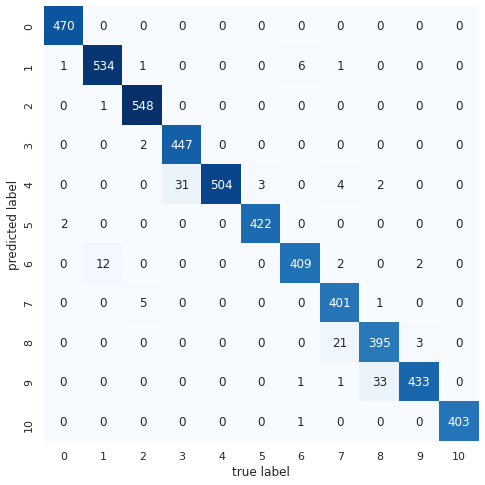

In [25]:
sns.set()
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.values.argmax(axis=1), predict_test.values.argmax(axis=1))
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=[0,1,2,3,4,5,6,7,8,9,10], yticklabels=[0,1,2,3,4,5,6,7,8,9, 10])
plt.xlabel('true label')
plt.ylabel('predicted label')

## 6.2 Validación (Näive Bayes)

In [26]:
report_NB = classification_report(y_train_1, predict_train_NB, [0,1,2,3,4,5,6,7,8,9,10])
print("Test Report for Näive Bayes train\n", report_NB)

report_NB = classification_report(y_test_1, predict_test_NB, [0,1,2,3,4,5,6,7,8,9,10])
print("Test Report for Näive Bayes test\n", report_NB)

Test Report for Näive Bayes train
               precision    recall  f1-score   support

           0       0.58      0.75      0.66      2321
           1       0.68      0.66      0.67      2806
           2       0.57      0.61      0.59      2740
           3       0.45      0.58      0.51      2845
           4       0.35      0.37      0.36      2859
           5       0.79      0.46      0.58      2588
           6       0.39      0.34      0.36      2316
           7       0.27      0.31      0.29      2584
           8       0.22      0.28      0.25      2483
           9       0.48      0.18      0.26      2340
          10       0.91      0.93      0.92      2176

    accuracy                           0.49     28058
   macro avg       0.52      0.50      0.49     28058
weighted avg       0.51      0.49      0.49     28058

Test Report for Näive Bayes test
               precision    recall  f1-score   support

           0       0.63      0.77      0.69       473
         

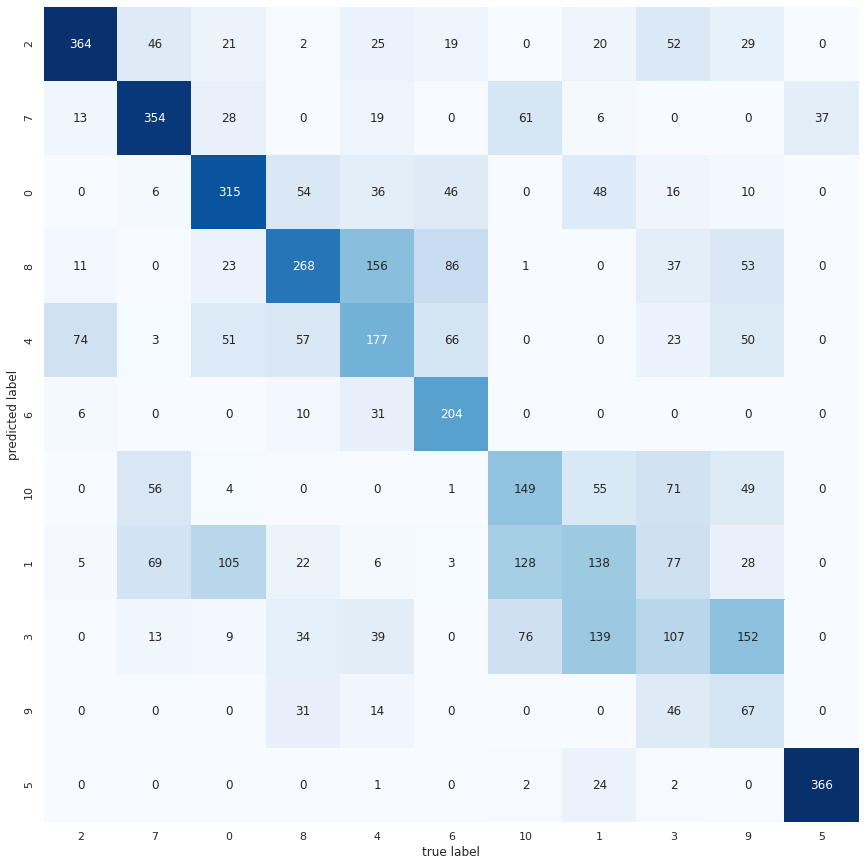

In [27]:
import seaborn as sns; sns.set()

plt.figure(figsize=(15,15))
mat = confusion_matrix(y_test_1, predict_test_NB)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=y_test_1.unique(),
            yticklabels=y_test_1.unique())
plt.xlabel('true label')
plt.ylabel('predicted label');

## 6.3 Validación (SVM)

In [28]:
report_svc = classification_report(y_train_1, predict_train_SVM, [0,1,2,3,4,5,6,7,8,9,10])
print("Test Report for SVC train with normalization\n", report_svc)

report_svc = classification_report(y_test_1, predict_test_SVM, [0,1,2,3,4,5,6,7,8,9,10])
print("Test Report for SVC test with normalization\n", report_svc)

Test Report for SVC train with normalization
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2321
           1       1.00      1.00      1.00      2806
           2       1.00      1.00      1.00      2740
           3       1.00      1.00      1.00      2845
           4       1.00      1.00      1.00      2859
           5       1.00      1.00      1.00      2588
           6       1.00      1.00      1.00      2316
           7       1.00      1.00      1.00      2584
           8       1.00      1.00      1.00      2483
           9       1.00      1.00      1.00      2340
          10       1.00      1.00      1.00      2176

    accuracy                           1.00     28058
   macro avg       1.00      1.00      1.00     28058
weighted avg       1.00      1.00      1.00     28058

Test Report for SVC test with normalization
               precision    recall  f1-score   support

           0       1.00      1.00      1.

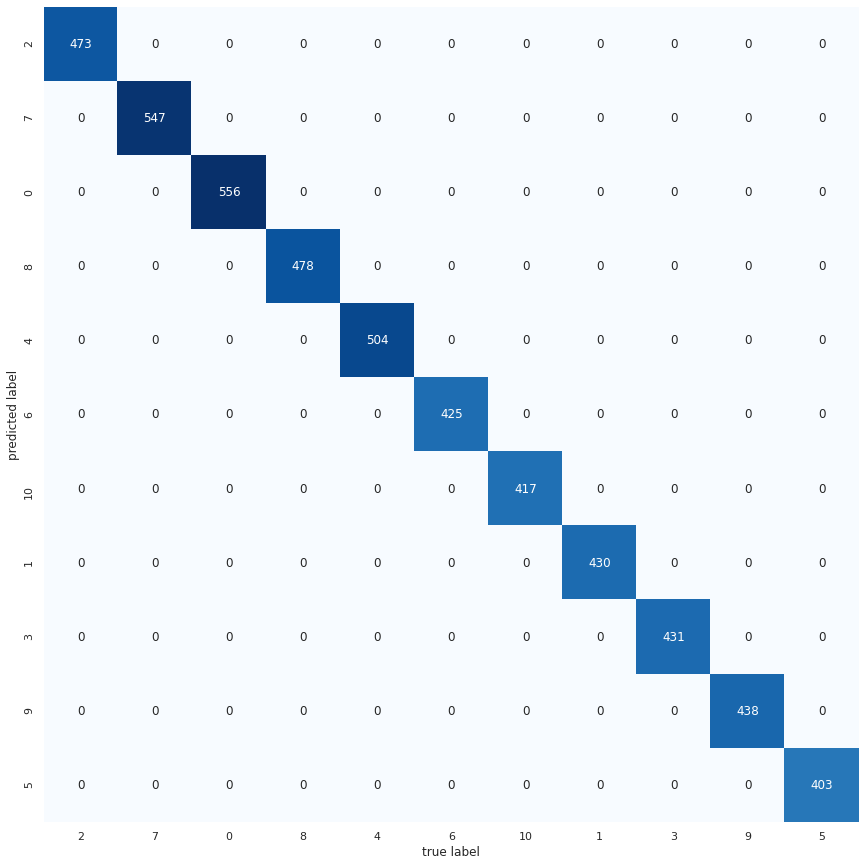

In [29]:
import seaborn as sns; sns.set()

plt.figure(figsize=(15,15))
mat = confusion_matrix(y_test_1, predict_test_SVM)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=y_test_1.unique(),
            yticklabels=y_test_1.unique())
plt.xlabel('true label')
plt.ylabel('predicted label');

## 6.4. Validación (Random Forest)

In [30]:
report_random_forest_clf_train = classification_report(y_train, y_predict_train)
report_random_forest_clf_test = classification_report(y_test, y_predict_test)
print("Test Report for train\n", report_random_forest_clf_train)
print("Test Report for test\n", report_random_forest_clf_test)

Test Report for train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2321
           1       1.00      1.00      1.00      2806
           2       1.00      1.00      1.00      2740
           3       1.00      1.00      1.00      2845
           4       1.00      1.00      1.00      2859
           5       1.00      1.00      1.00      2588
           6       1.00      1.00      1.00      2316
           7       1.00      1.00      1.00      2584
           8       1.00      1.00      1.00      2483
           9       1.00      1.00      1.00      2340
          10       1.00      1.00      1.00      2176

   micro avg       1.00      1.00      1.00     28058
   macro avg       1.00      1.00      1.00     28058
weighted avg       1.00      1.00      1.00     28058
 samples avg       1.00      1.00      1.00     28058

Test Report for test
               precision    recall  f1-score   support

           0       1.00      1.00

Text(54.260000000000005, 0.5, 'predicted label')

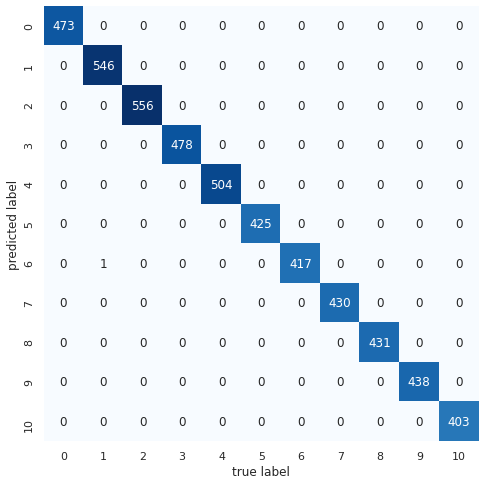

In [31]:
sns.set()
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.values.argmax(axis=1), y_predict_test.argmax(axis=1))
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=[0,1,2,3,4,5,6,7,8,9,10], yticklabels=[0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel('true label')
plt.ylabel('predicted label')

## 6.5. Validación (GDC Classifier)

In [32]:
report_sgd_clf = classification_report(y_test_1, y_predict)
print("Test Report\n", report_sgd_clf)

Test Report
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       473
           1       0.92      0.98      0.95       547
           2       0.95      0.98      0.97       556
           3       0.85      0.99      0.92       478
           4       0.74      0.91      0.82       504
           5       0.84      0.72      0.78       425
           6       0.98      0.89      0.93       417
           7       0.92      0.93      0.93       430
           8       0.80      0.81      0.80       431
           9       0.96      0.61      0.74       438
          10       1.00      1.00      1.00       403

    accuracy                           0.90      5102
   macro avg       0.90      0.89      0.89      5102
weighted avg       0.90      0.90      0.89      5102



Text(54.260000000000005, 0.5, 'predicted label')

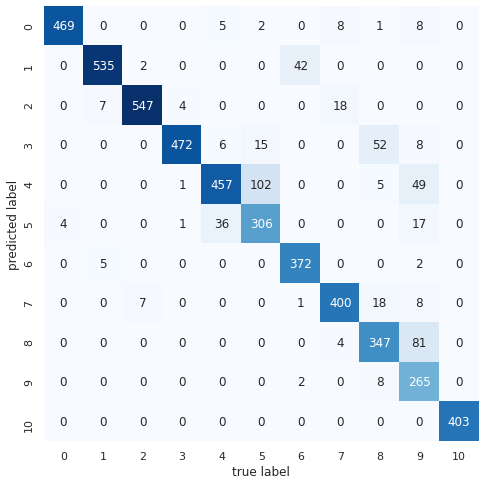

In [33]:
sns.set()
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test_1, y_predict)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=[0,1,2,3,4,5,6,7,8,9,10], yticklabels=[0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel('true label')
plt.ylabel('predicted label')

# 7. Conclusiones

* En este caso en particular, aumentar los datos nos permitió tener mejores resultados en la mayoría de los algoritmos probados, probablemente por un sobreajuste natural dado por la poca información suministrada.
* Se probaron cinco tipos diferentes de algoritmos con resultados variados, logrando en varios de ellos clasificaciones casi perfectas. Los de peor rendimiento fueron Bayes y el GDC Classifier. Mientras que los de mejor rendimiento fueron Random Forest, SVM, y el MLP.
* Por simplicidad a la hora de ser exportado (para implementaciones futuras), consideramos que el SVM y el random forest son los de mejor rendimiento, aunque no descartamos la viabilidad de uso de la red neuronal.
